<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Neural_Network/blob/main/Adversarial_Diffusion_Distillation_Last_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Method Description

The Adversarial Diffusion Distillation (ADD) is a novel approach that aims to efficently samples images in just a few steps.The idea is combine the power of Adversarial networks and the distillation technique in order to synthetize high quality images in a small number of iterations.

In the original paper Sauer et. al. the idea was to synthetize the images in 1-4 steps using pretrained models. Their analysis show that the models outperform the results of existing models and reach the performances of the State of the art (SDXL) in only 4 steps.

The original model is composed by 3 parts:


*   **ADD-student**: is a pretrained diffusion model that aims to synthetize the images in a few steps (1-4) starting from a noised version of the original image. So this model can use only from 1 to 4 iterations to denoise the input image. The parameters of this model are trainable.
*   **DM-teacher**: is also a pretrained diffusion model but differently from the student, it can use a larger number of iterations to denoise the input. It has fixed parameters.
*   **ViT Discriminator**: is a pretrained Vision Transformer that they adapt to use as a discriminator with trainable parameters.

The key idea for the training procedure is:

1.   Take a Real image
2.   Introduce some noise
3.   Pass the noised version of the original image through the ADD-student
4.   Pass the output of ADD-student through the discriminator and compute the Adversarial Loss
5.   Introduce some other noise to the resulting image from the ADD-student
6.   Pass it through the DM-teacher and compute the distillation loss using the outputs from the ADD-student and DM-teacher
7.   Compute the total loss summing up the two losses and backpropagate it to the ADD-student and to the discriminator

The two losses that have been computed are the Adversarial Loss and the Distillation Loss that are defined as follows:

Adversarial loss that is the loss of the adversarial process and is used to update the weights of the discriminator:


$$L_{adv}^G(\hat{x}_{\theta}(x_s, s), \phi) = -\mathbb{E}_{s,\epsilon,x_0} \left[ \sum_{k} D_{\phi,k} \left( F_k(\hat{x}_{\theta}(x_s, s)) \right) \right] $$

$$L_{adv}^D(\hat{x}_{\theta}(x_s, s), \phi) = \mathbb{E}_{x_0} \left[ \sum_{k} \max(0, 1 - D_{\phi,k}(F_k(x_0))) + \gamma R_1(\phi) \right] + \mathbb{E}_{\hat{x}_{\theta}} \left[ \sum_{k} \max(0, 1 + D_{\phi,k}(F_k(\hat{x}_{\theta}))) \right]
$$


Distillation loss:

$$L_{\text{distill}}(\hat{x}_{\theta}(x_s, s), \psi) = \mathbb{E}_{t,\epsilon'} \left[ c(t) \cdot d(\hat{x}_{\theta}, \hat{x}_{\psi}(s, g(\hat{x}_{\theta}, t); t)) \right]$$



The total loss is:

$$L_{total} = L_{adv}^D(\hat{x}_{\theta}(x_s, s), \phi) + L_{\text{distill}}(\hat{x}_{\theta}(x_s, s), \psi)$$



In my project I decided to not use pretrained models, so I built a diffusion model and a ViT model and i pretrained them on my dataset and use the pretrained model for the final training.


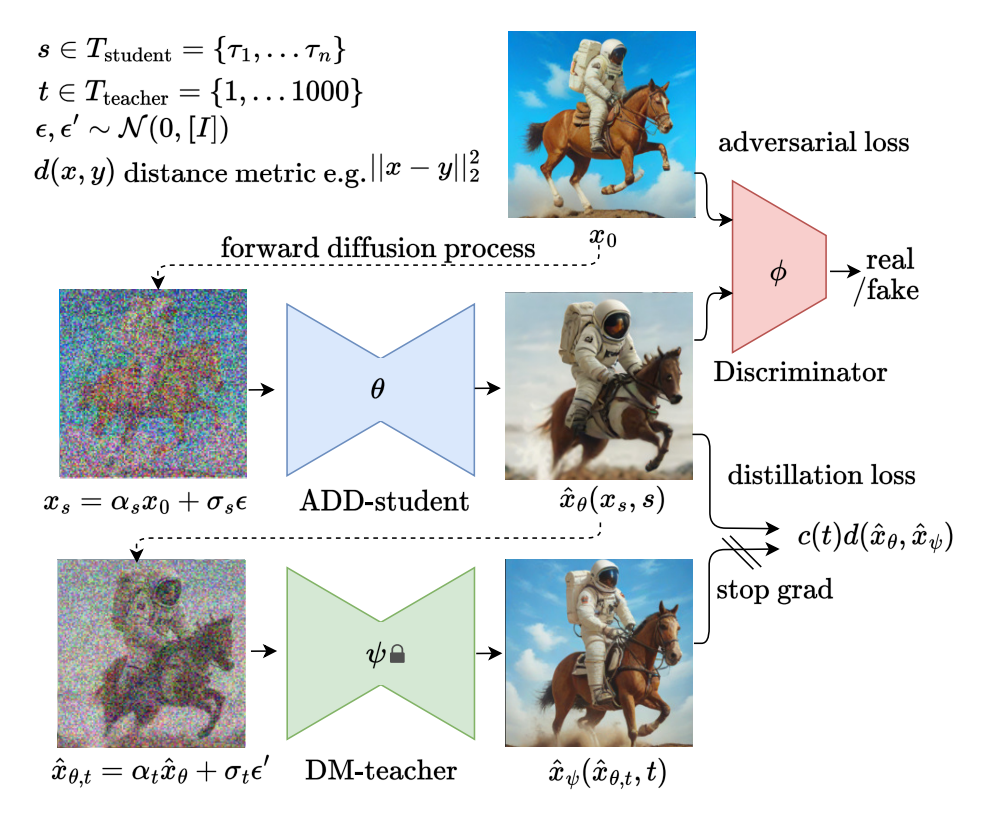

https://static1.squarespace.com/static/6213c340453c3f502425776e/t/65663480a92fba51d0e1023f/1701197769659/adversarial_diffusion_distillation.pdf

https://arxiv.org/pdf/2006.11239.pdf


## Import the pretrained models


Here you can download the pretrained models for the ADD-student, DM-teacher and ViT discriminator from the github and use them later to test the results.

In [1]:
!rm -r Neural_Network
!git clone https://github.com/FedericoRaschiatore0123/Neural_Network
%cd Neural_Network
!unzip models.zip -d models

rm: cannot remove 'Neural_Network': No such file or directory
Cloning into 'Neural_Network'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 126 (delta 97), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (126/126), 51.21 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (97/97), done.
/content/Neural_Network
Archive:  models.zip
  inflating: models/models/diffusion_model_last_version.pth  
  inflating: models/models/discriminator_model_last_version.pth  
  inflating: models/models/student_model_last_version.pth  


#Imports
the project has been built using the following libraries

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U einops datasets matplotlib tqdm

import math
import torch as torch
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import einsum
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import os
import torch.nn as nn
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid , save_image
import random
from torchvision import datasets
from torch.optim import Adam
from pathlib import Path

BATCH_SIZE=64

device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


#Dataset and transformations
In this section it's imported the dataset and are applied the following transformations.

In [3]:
transform = tt.Compose([
            tt.RandomHorizontalFlip(),
            tt.ToTensor(),
            tt.Lambda(lambda t: (t * 2) - 1)
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

print(dataset)
# create dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 234301959.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60356598.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 90685943.15it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21574777.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
           )


In [4]:
def show_batch(images):
    fig, ax = plt.subplots(figsize=(24, 24))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0))

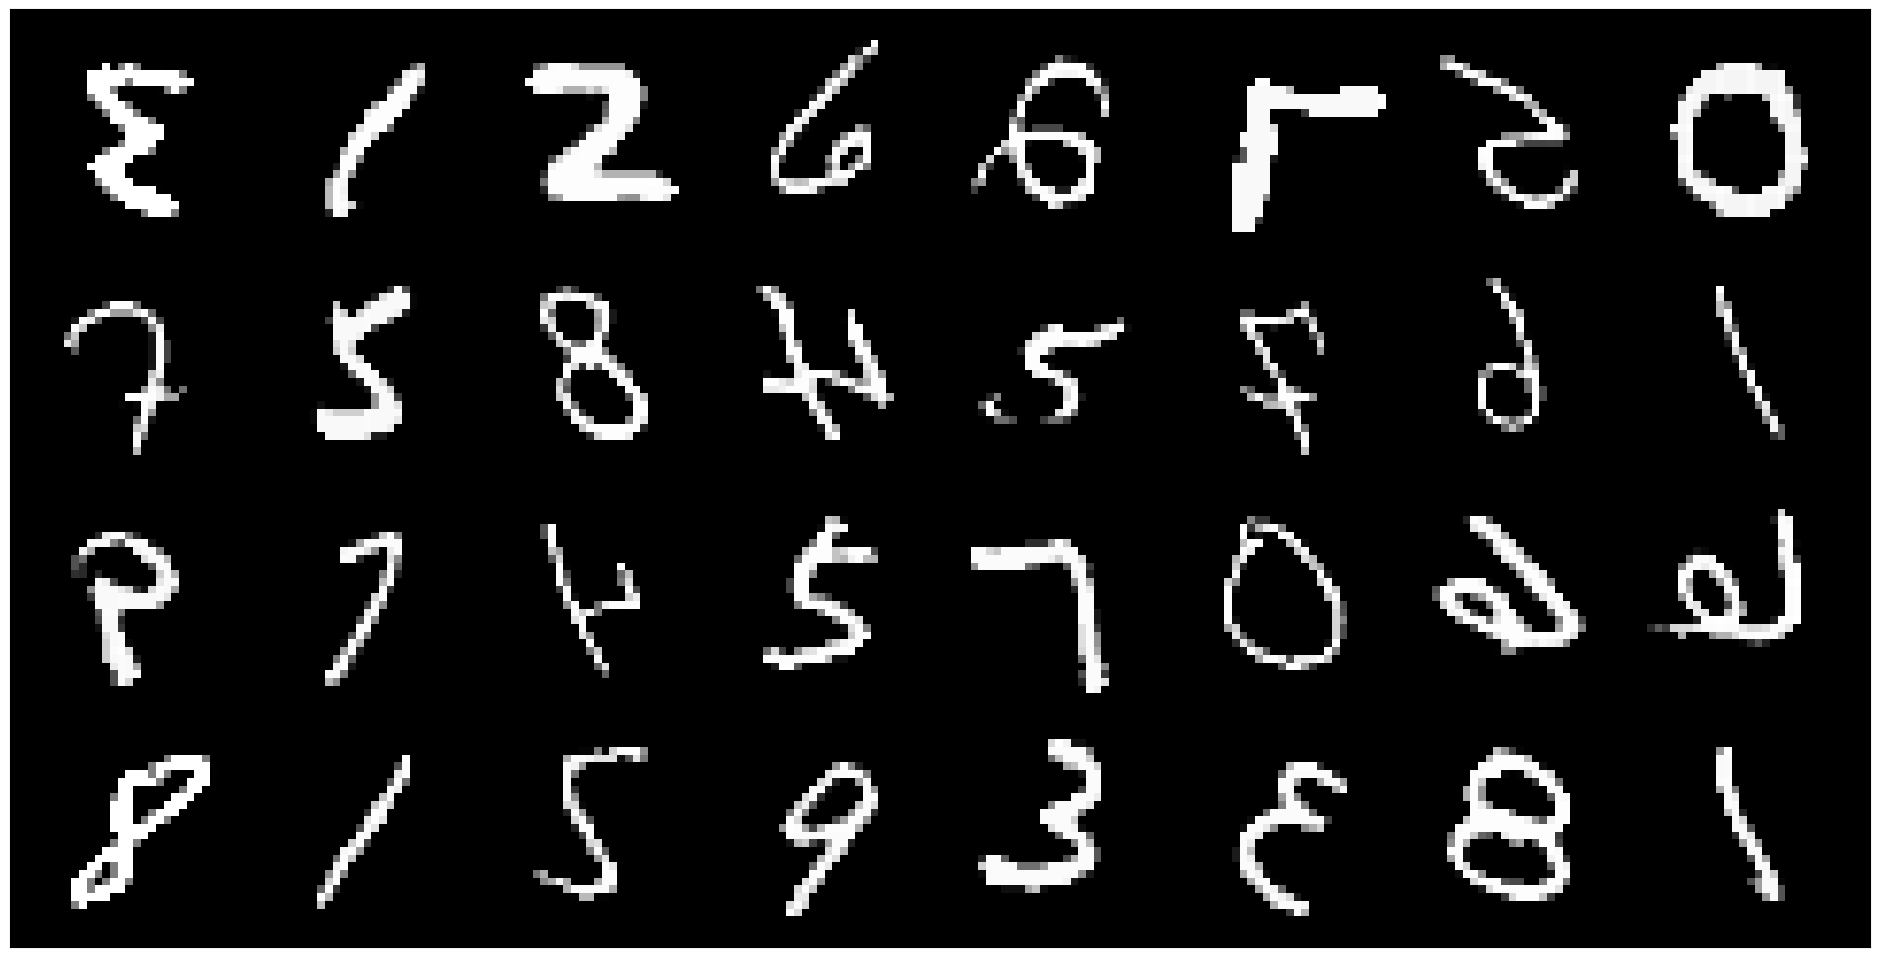

In [ ]:
show_batch(next(iter(dataloader))[0])

#Forward process
This section contains the function necessary to the diffusion process and the needed constants. I used a schedule based on the number of timesteps specified (in this case 800)

In [5]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

timesteps = 800

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. -  betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [6]:
def show_tensor_image(image):
    reverse_transforms = tt.Compose([
        tt.Lambda(lambda t: (t + 1) / 2),
        tt.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        tt.Lambda(lambda t: t * 255.),
        tt.Lambda(lambda t: t.numpy().astype(np.uint8)),
        tt.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


torch.Size([64, 1, 28, 28])


<ipython-input-7-f27da4a9ee29>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


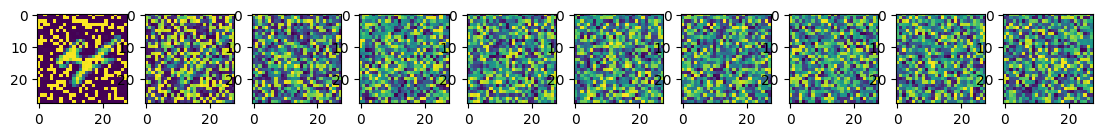

In [7]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
print(image.shape)

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(1, timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = q_sample(image, t)
    show_tensor_image(img)

# Diffusion Model

La UNet viene utilizzata per fare in modo che il modello impari solo le parti più importanti dell'immagini tralasciando i dettagli



##UNeT

In [8]:
#Utilities
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [9]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [10]:
class UNet_Block(nn.Module):
  def __init__(self, dim_input, dim_output, groups=4):
    super().__init__()
    self.proj = nn.Conv2d(dim_input, dim_output, 3, padding = 1)
    self.normalization= nn.GroupNorm( groups, dim_output)
    self.act= nn.SiLU()

  def forward(self, x):
    x = self.proj(x)
    x = self.normalization(x)
    x = self.act(x)

    return x

class UNet_ResNet(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=4):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = UNet_Block(dim, dim_out, groups=groups)
        self.block2 = UNet_Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

In [11]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.num_heads = num_heads
        hidden_dim = dim_head * num_heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.num_heads), qkv
        )
        #batch, num_heads, dim_features, x, y
        #organizza le informazioni ottenute dalla proiezione lineare in q, k, e v nel formato appropriato
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k) #specifica come fare la moltiplicazione tra il vettore q (batch, num_heads, dim_features, index(i)) e k(batch, num_heads, dim_features, index(j))
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [12]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=1,
        with_time_emb=True,
        resnet_block_groups=4,
        convnext_mult=2,
    ):
        super().__init__()

        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] #dim * [1,2,4,8]
        in_out = list(zip(dims[:-1], dims[1:]))  #dim * [1,2,4,8,4,2,1]

        block_klass = partial(UNet_ResNet, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),


                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )


    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

##Train

In [ ]:
image_size = 28
channels = 1
batch_size = 64

diffusion_model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
diffusion_model.to(device)


Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): UNet_ResNet(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=28, bias=True)
        )
        (block1): UNet_Block(
          (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): UNet_Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride

In [ ]:
epochs = 10

optimizer = Adam(diffusion_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t = torch.randint(0, timesteps, (batch_size,), device=device).long()
      noise=torch.randn_like(batch)
      x_noisy = q_sample(x_start=batch, t=t, noise=noise)
      predicted_noise = diffusion_model(x_noisy[0], t)

      loss = F.smooth_l1_loss(noise, predicted_noise)

      if step % 200 == 0:
        print("Epoch: " + str(epoch)+ "   Loss:", loss.item())

      loss.backward()
      optimizer.step()

    scheduler.step(loss)

Epoch: 0   Loss: 0.47786423563957214
Epoch: 0   Loss: 0.031613025814294815
Epoch: 0   Loss: 0.021020693704485893
Epoch: 0   Loss: 0.016482125967741013
Epoch: 0   Loss: 0.01786305569112301
Epoch: 1   Loss: 0.01804881915450096
Epoch: 1   Loss: 0.021129949018359184
Epoch: 1   Loss: 0.019465584307909012
Epoch: 1   Loss: 0.015356360003352165
Epoch: 1   Loss: 0.014584672637283802
Epoch: 2   Loss: 0.012611252255737782
Epoch: 2   Loss: 0.01488986425101757
Epoch: 2   Loss: 0.014702427200973034
Epoch: 2   Loss: 0.016041772440075874
Epoch: 2   Loss: 0.010167320258915424
Epoch: 3   Loss: 0.016576694324612617
Epoch: 3   Loss: 0.011605627834796906
Epoch: 3   Loss: 0.015910865738987923
Epoch: 3   Loss: 0.01325977873057127
Epoch: 3   Loss: 0.014526808634400368
Epoch: 4   Loss: 0.017064455896615982
Epoch: 4   Loss: 0.01342833787202835
Epoch: 4   Loss: 0.01312881801277399
Epoch: 4   Loss: 0.013553043827414513
Epoch: 4   Loss: 0.015214980579912663
Epoch: 5   Loss: 0.012683223001658916
Epoch: 5   Loss: 0.

In [ ]:
#path = '/content/drive/MyDrive/diffusion_model.pth'

# Salva il modello
#torch.save(diffusion_model.state_dict(), path)

##Generate new samples

In [13]:
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


def p_sample_loop(model,img, shape, timesteps):
    device = next(model.parameters()).device

    b = shape[0]
    imgs = []

    for i in reversed(range(0, timesteps)):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img)
    return imgs

def sample(model, img, image_size, timestep, batch_size=BATCH_SIZE, channels=1):
    return p_sample_loop(model, img,  shape=(batch_size, channels, image_size, image_size), timesteps=timestep)

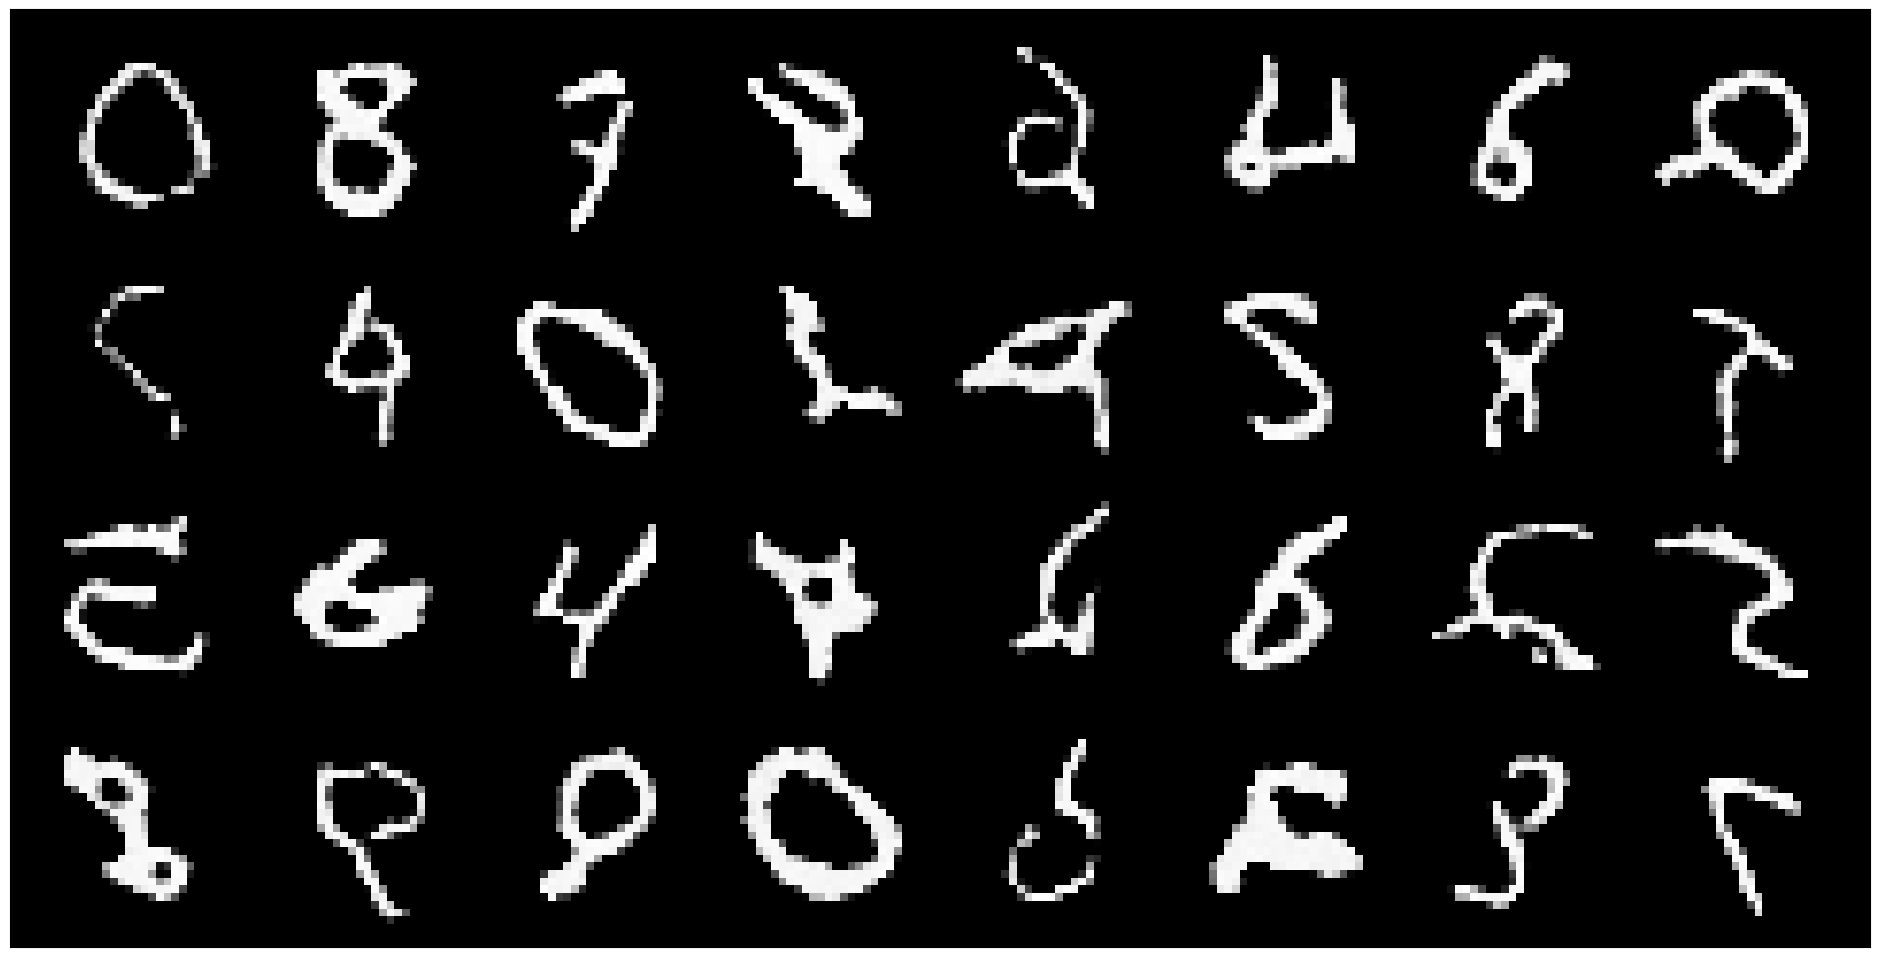

In [ ]:
with torch.no_grad():
  pure_noise = torch.rand([64,1,28,28]).to(device)
  sample_data = sample(diffusion_model, pure_noise, image_size=image_size, timestep=800,  batch_size=BATCH_SIZE, channels=1)
  show_batch(sample_data[-1].cpu().detach())

# Discriminator

##ViT

In [14]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
from einops import repeat


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size,  emb_size = 64):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        )
        self.linear= nn.Linear(patch_size * patch_size * in_channels, emb_size).to(device)

    def forward(self, x):
        x = self.projection(x)
        x = self.linear(x)
        return x


In [15]:
class DiscResidual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class DiscPreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


In [16]:
class DiscAttention(nn.Module):
  def __init__(self, emb_dim, num_heads):
    super(DiscAttention, self).__init__()
    self.emb_dim=emb_dim
    self.num_heads = num_heads

    self.attention = nn.MultiheadAttention(self.emb_dim, self.num_heads, dropout=0.1)

    self.q = nn.Linear(emb_dim, emb_dim)
    self.k = nn.Linear(emb_dim, emb_dim)
    self.v = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attention, attention_weights = self.attention(q, k, v)
    return attention

In [17]:
class ViT(nn.Module):
  def __init__(self, emb_dim, hidden_dim, out_dim, channels, input_channels=1, patch_size = 7,  n_layers = 3,  img_size=28, dropout=0.1, num_heads = 8):
    super(ViT, self).__init__()
    self.emb_dim = emb_dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.dropout = dropout
    self.channels = channels
    self.img_width = img_size
    self.img_height = img_size
    self.n_layers = n_layers

    self.patch_embedding = PatchEmbedding(channels, patch_size= patch_size,  emb_size = emb_dim)

    #self.patch_extraction = PatchExtractionBlock(input_channels, output_channels)

    # Learnable params
    num_patches = (img_size // patch_size) ** 2
    self.positional_emb = nn.Parameter(torch.randn(emb_dim, num_patches + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

    self.layers = nn.ModuleList([])
    for _ in range(n_layers):
      block = nn.Sequential(

          DiscResidual(DiscPreNorm(emb_dim, DiscAttention(emb_dim, num_heads))),

          DiscResidual(DiscPreNorm(emb_dim, nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                                  nn.LeakyReLU(),
                                                  nn.Dropout(dropout),
                                                  nn.Linear(hidden_dim, emb_dim),
                                                  nn.Dropout(dropout)
                                              )))
      )
      self.layers.append(block)

    self.classification_head = nn.Sequential(nn.LayerNorm(emb_dim* (num_patches + 1)), nn.Linear(emb_dim* (num_patches + 1), out_dim))
    self.sigmoid = nn.Sigmoid()
    self.projection = nn.Sequential(
            Rearrange('b h p -> b (h p)')
        )

  def forward(self, batch):
      #images = self.patch_extraction(images)
      x = self.patch_embedding(batch)
      b, n, _ = x.shape

      # Add cls token to inputs
      cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
      x = torch.cat([cls_tokens, x], dim=1)
      x += self.positional_emb[:, :(n+1),:]
      for layer in self.layers:
        x = layer(x)
      x = self.projection(x)
      return self.sigmoid(self.classification_head(x[:, :]))

losses = []
discriminator_model = ViT(64, 512, 1, 1).to(device)

##Training

In [ ]:
num_epochs=1
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=1e-4)

for epoch in range(num_epochs):

    for step, batch in enumerate(dataloader):

        if step ==10:
          break

        optimizer.zero_grad()

        t = torch.randint(0, timesteps, (batch[0].shape[0],), device=device).long().to(device)

        noise=torch.randn_like(batch[0]).to(device) #crea rumore con la stessa dimensione del batch
        x_noisy = q_sample(x_start=batch[0].to(device), t=t, noise=noise)
        predicted_noise = diffusion_model(x_noisy[0], t)
        with torch.no_grad():
          fake_data = sample( diffusion_model, x_noisy[0], image_size, timestep=timesteps,  batch_size=BATCH_SIZE, channels=channels)

        # Preparazione dei dati
        real_data = batch

        # Etichette per esempi reali e falsi
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
        if real_data[0].shape[0] == BATCH_SIZE:
          output_real = discriminator_model(real_data[0].to(device))
          loss_real = criterion(output_real, real_labels)
        else:
          break

        # Forward pass per esempi falsi
        output_fake = discriminator_model(fake_data[-1].detach())  # Detach per evitare di propagare il gradiente al generatore
        loss_fake = criterion(output_fake, fake_labels)

        # Calcolo totale della loss
        total_loss = loss_real + loss_fake
        print(loss_real)
        print(loss_fake)
        print("Epoch: " + str(epoch)+ "   Loss:", total_loss)

        total_loss.backward()
        optimizer.step()

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4116, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>

In [ ]:
#path = '/content/drive/MyDrive/discriminator_model.pth'

# Salva il modello
#torch.save(discriminator_model.state_dict(), path)

# Full Train

In [18]:
image_size = 28
channels = 1
batch_size = 64
student_timesteps = 10
teacher_timesteps= 400

disc_loss = nn.BCELoss()
disc_loss2 = nn.BCELoss()
dis_loss = nn.MSELoss()
l = 2.5
regularization_term = 2

In [ ]:
# path to load the pretrained models
diffusion_path = '../Neural_Network/models/models/diffusion_model_last_version.pth'
discriminator_path = '../Neural_Network/models/models/discriminator_model_last_version.pth'
student_path = '../Neural_Network/models/models/student_model_last_version.pth'


# Load the teacher_model
teacher_model = Unet(  dim=image_size,  channels=channels,  dim_mults=(1, 2, 4,))
teacher_model.load_state_dict(torch.load(diffusion_path))
teacher_model.eval()
teacher_model.to(device)

# Load the discriminator_model
discriminator_model = ViT(64, 512, 1, 1)
discriminator_model.load_state_dict(torch.load(discriminator_path))
discriminator_model.train()
discriminator_model.to(device)

# Load the student_model
student_model = Unet( dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
#if you want to restart the train from scratch set this path to diffusion_path
student_model.load_state_dict(torch.load(student_path))
student_model.train()
student_model.to(device)

Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): UNet_ResNet(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=28, bias=True)
        )
        (block1): UNet_Block(
          (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): UNet_Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride

Il training consiste nel:


*   Fase 1: trainare con poco noise (0, timestep) lo student e il teacher partendo dalla stessa immagine con aggiunto rumore in modo che il teacher accompagni lo student nella prima fase di training
*   Fase 2: aumentare il rumore (0, timestep *2)
*   Fase 3: fare in modo che il teacher prenda in ingresso l'output dello student con poco rumore (0, timestep) e invece il rumore tra dati reali e input dello student sia più alto(timestep, timestep*2)
*   Fase 4: aumentare il rumore tra output dello student e input del teacher (0, timestep*2)
*   Fase 5: Dare in ingresso allo student rumore puro e inserire abbastanza rumore (0, timestep*2) tra lo student e il teacher in modo da evitare mode collapse





##Pretrain

Epoch: 0  Adversarial Loss:tensor(1.4323, device='cuda:0', grad_fn=<AddBackward0>)


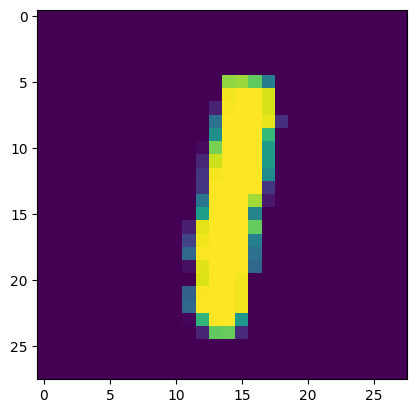

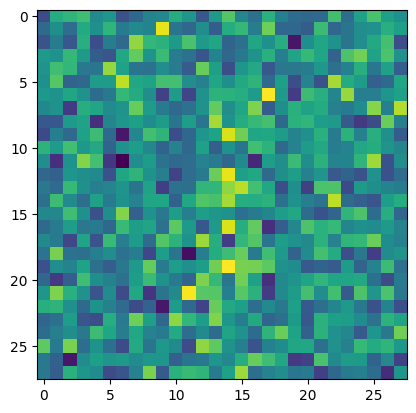

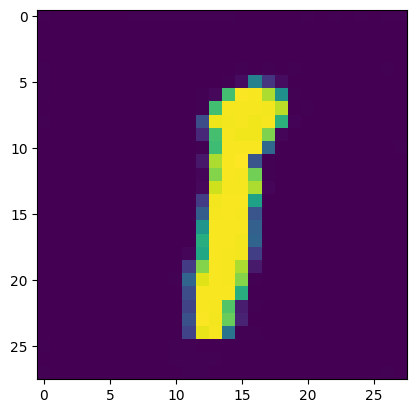

Epoch: 0   Loss: tensor(3.3488, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(1.0706, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.6724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.4323, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(3.0094, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.9616, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.6055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.4323, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(2.7227, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.8558, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.4323, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(2

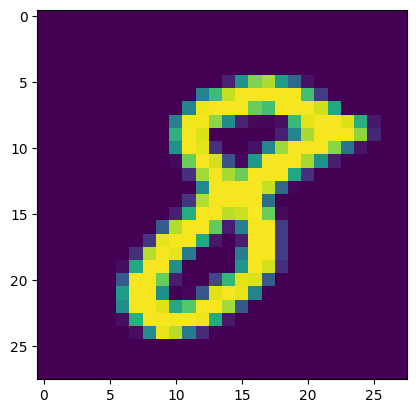

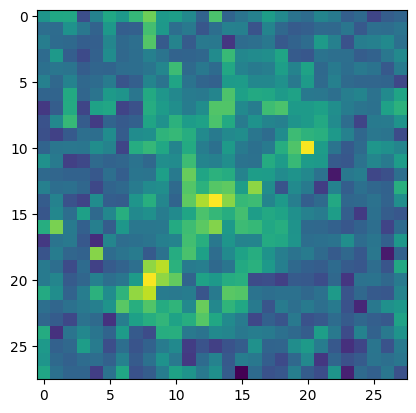

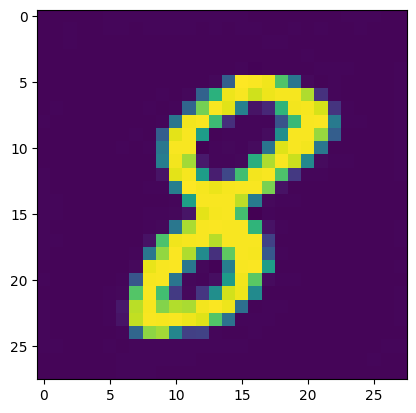

Epoch: 1   Loss: tensor(0.9869, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3513, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(1.5360, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.8721, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3034, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(1.5360, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.7902, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2709, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(1.5360, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0

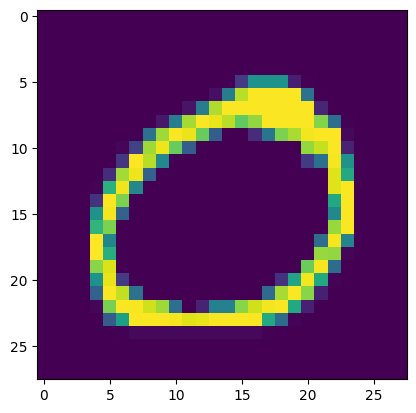

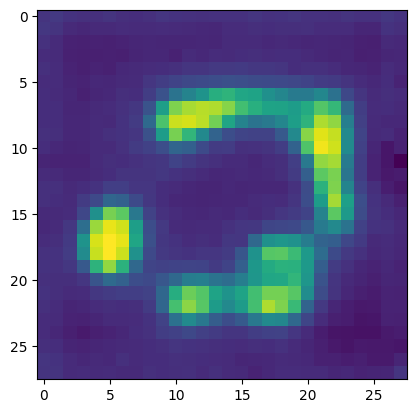

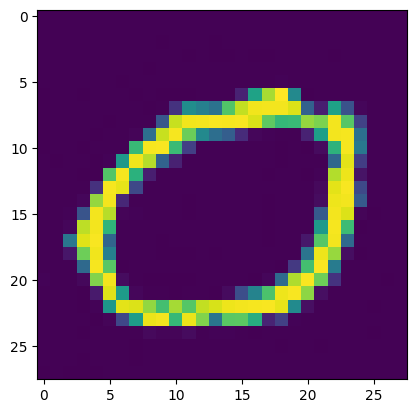

Epoch: 2   Loss: tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1704, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.4842, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2   Loss: tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1736, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.4842, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2   Loss: tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1947, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.4842, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2   Loss: tensor(0

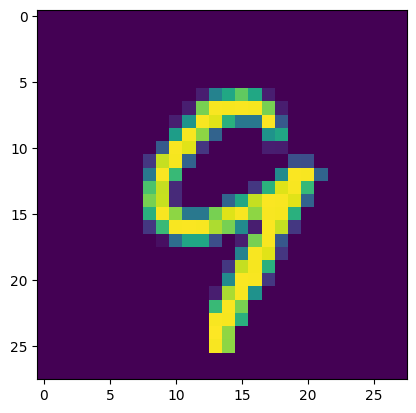

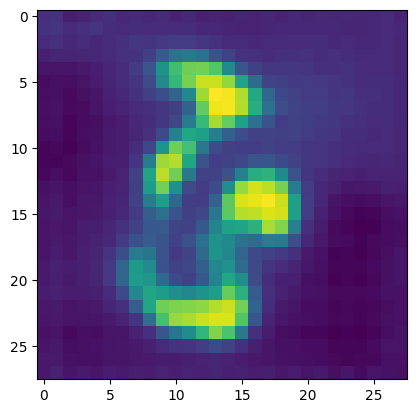

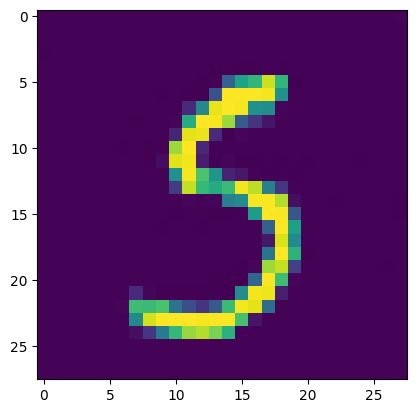

Epoch: 3   Loss: tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1628, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(3.3190, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3   Loss: tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1754, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(3.3190, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3   Loss: tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1809, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(3.3190, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3   Loss: tensor(0

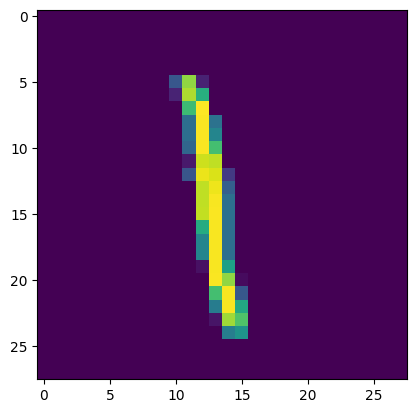

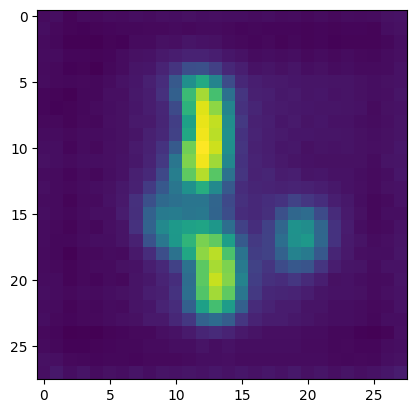

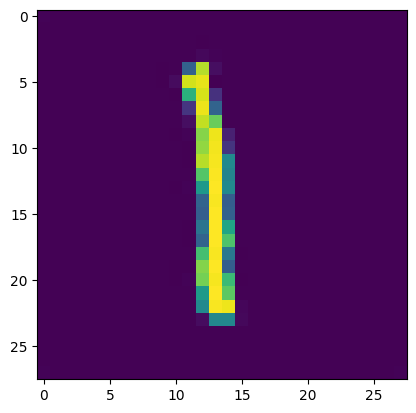

Epoch: 4   Loss: tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1519, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.7135, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4   Loss: tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1468, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.7135, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4   Loss: tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1630, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.7135, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4   Loss: tensor(0

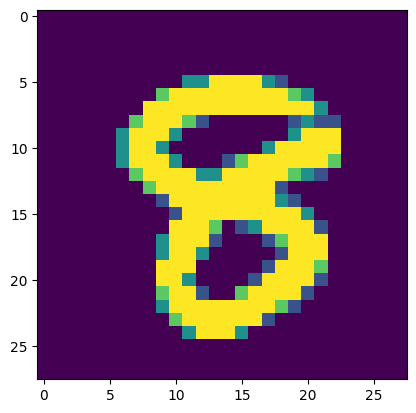

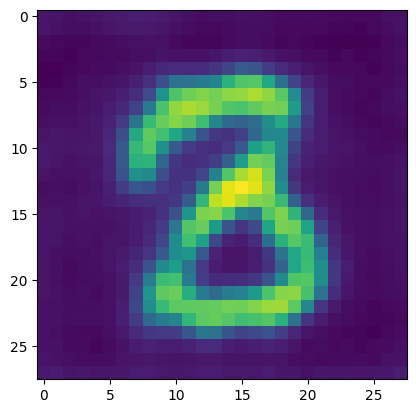

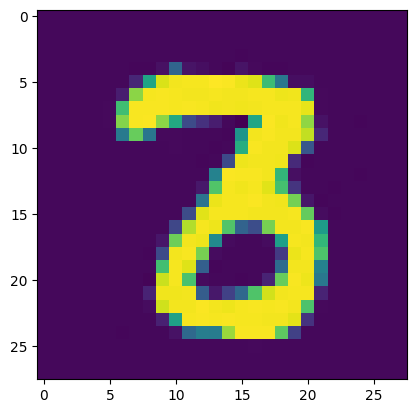

Epoch: 5   Loss: tensor(0.4012, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1499, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(3.7229, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5   Loss: tensor(0.4134, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1538, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(3.7229, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5   Loss: tensor(0.3764, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1384, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(3.7229, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5   Loss: tensor(0

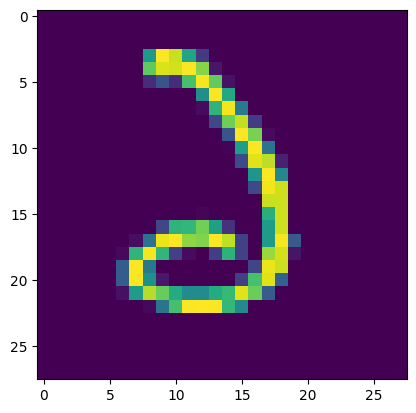

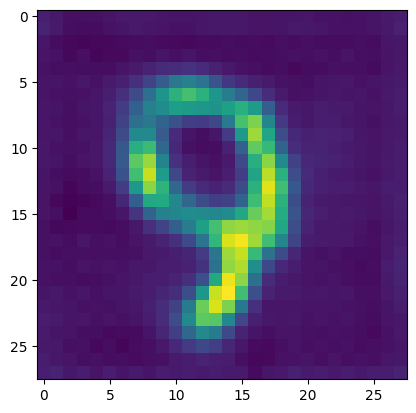

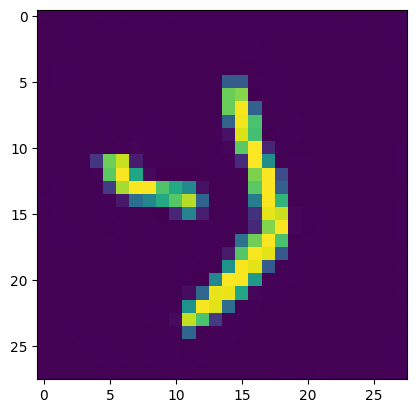

Epoch: 6   Loss: tensor(0.3539, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1310, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(3.7180, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6   Loss: tensor(0.3695, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1369, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(3.7180, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6   Loss: tensor(0.3657, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1350, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(3.7180, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6   Loss: tensor(0

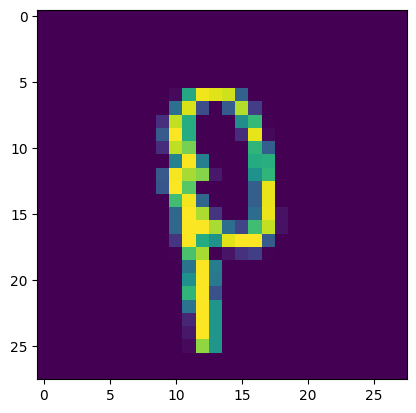

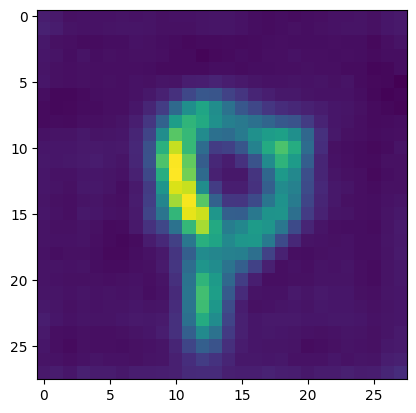

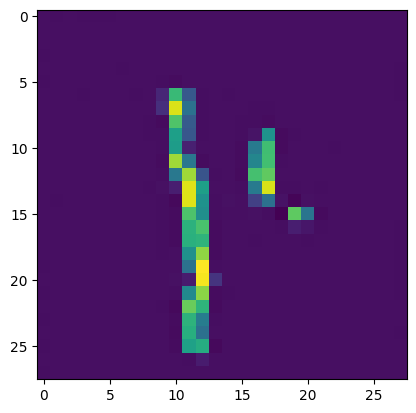

Epoch: 7   Loss: tensor(0.3604, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1331, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(3.6426, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7   Loss: tensor(0.3813, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1413, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(3.6426, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7   Loss: tensor(0.3554, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1305, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(3.6426, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7   Loss: tensor(0

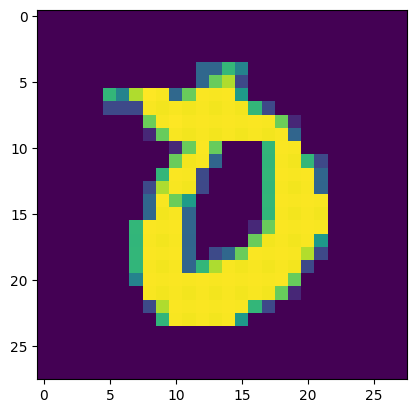

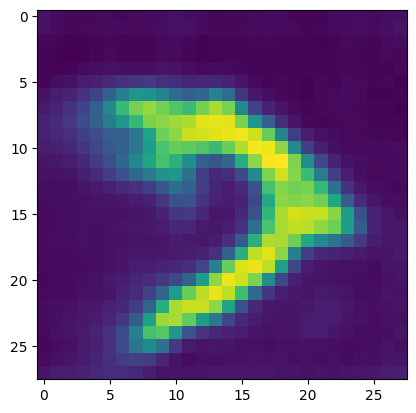

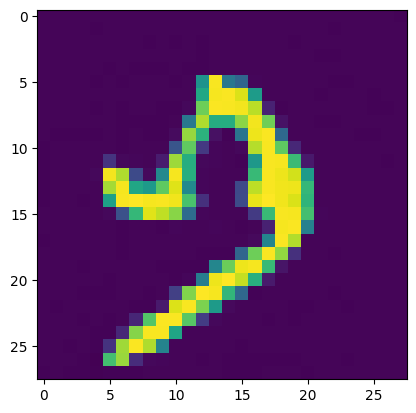

Epoch: 8   Loss: tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1489, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(3.6195, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8   Loss: tensor(0.3808, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1405, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(3.6195, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8   Loss: tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1495, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(3.6195, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8   Loss: tensor(0

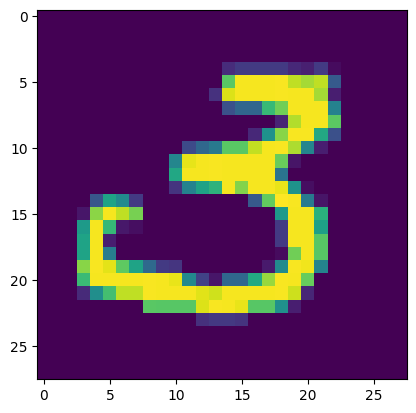

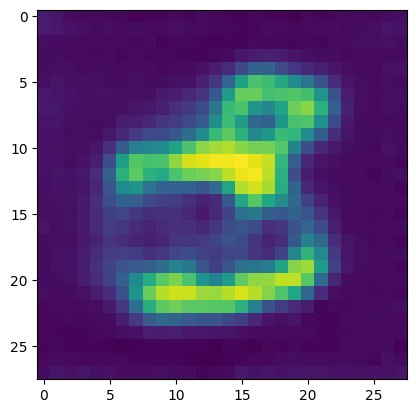

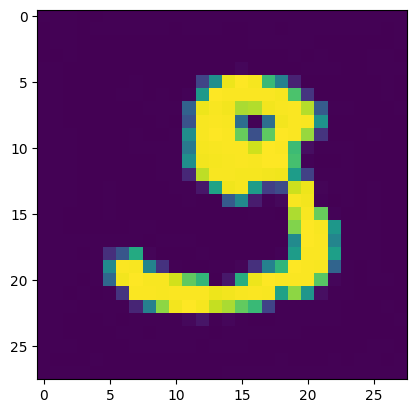

Epoch: 9   Loss: tensor(0.3804, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1411, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(3.6612, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9   Loss: tensor(0.3605, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1328, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(3.6612, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9   Loss: tensor(0.3598, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1325, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(3.6612, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9   Loss: tensor(0

In [ ]:
torch.cuda.empty_cache()
epochs = 10

student_optimizer = Adam(student_model.parameters(), lr=1e-3, weight_decay=1e-5)
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=2, factor=0.05)
scheduler_discriminator = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, 'min', patience=2, factor=0.05)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 10:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(teacher_timesteps-1, teacher_timesteps, (batch_size,), device=device).long()
      t_teacher = torch.randint(teacher_timesteps-1, teacher_timesteps, (batch_size,), device=device).long()

      noise = torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy_student = q_sample(x_start=batch, t=t_student, noise=noise)

      student_data = sample( student_model, x_noisy_student[0] , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      output_real = discriminator_model(batch)
      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, fake_labels)

      if step % 10==0:
        # Calcolo totale della loss
        adversarial_loss = loss_real + loss_fake
        adversarial_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_student[0], image_size, timestep=teacher_timesteps,  batch_size=batch_size, channels=channels)

      if step % 10 == 0:
        #show the results
        random_index = random.randint(0, 63)
        image_data0 = batch[random_index].cpu().numpy().reshape(image_size, image_size, channels)
        image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
        image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
        plt.imshow(image_data0)
        plt.show()
        plt.imshow(image_data1)
        plt.show()
        plt.imshow(image_data3)
        plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])
      loss = l*distill_loss + loss_fake
      losses.append(loss)

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)
    scheduler_discriminator.step(adversarial_loss)

## ADD train

Epoch: 0  Adversarial Loss:tensor(3.5875, device='cuda:0', grad_fn=<AddBackward0>)


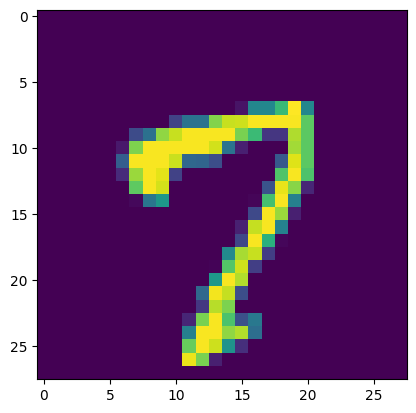

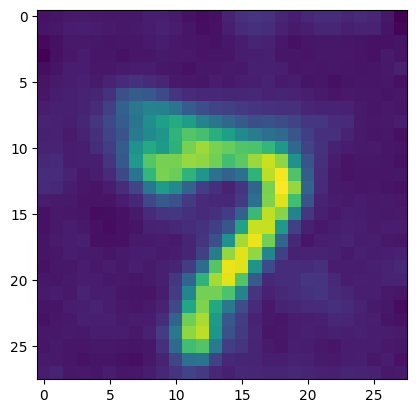

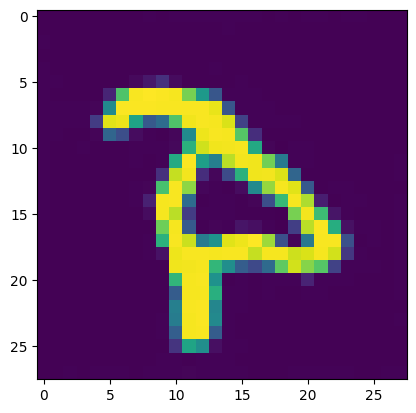

Epoch: 0  Total Loss: tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2173, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.5875, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0  Total Loss: tensor(0.9814, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3711, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.5875, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0  Total Loss: tensor(0.8219, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3097, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.5875, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0  

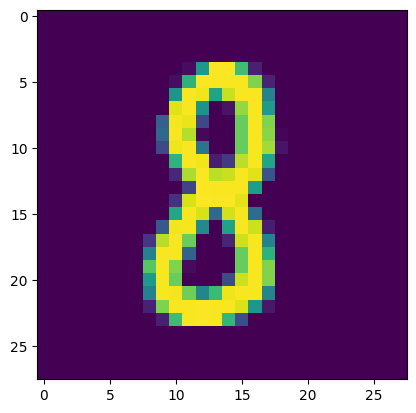

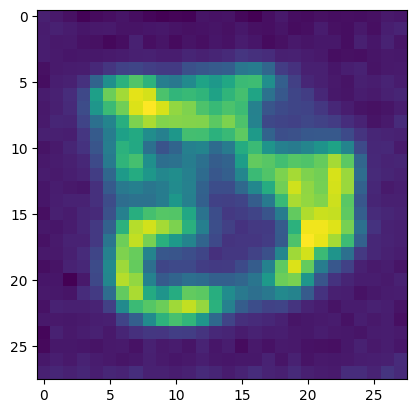

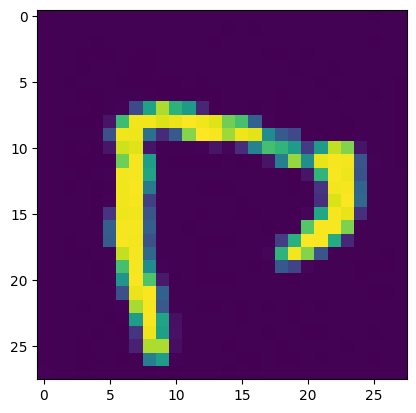

Epoch: 1  Total Loss: tensor(0.6673, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2506, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(3.4400, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1  Total Loss: tensor(0.6857, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2566, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(3.4400, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1  Total Loss: tensor(0.6781, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2530, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(3.4400, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1  

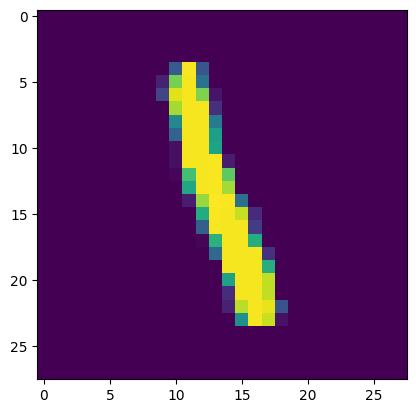

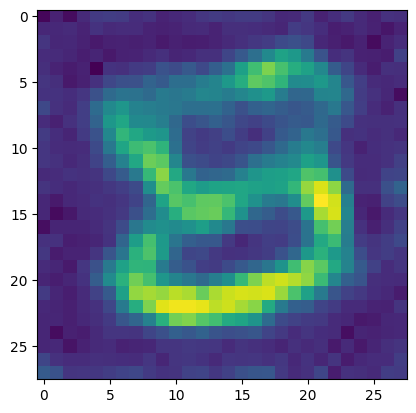

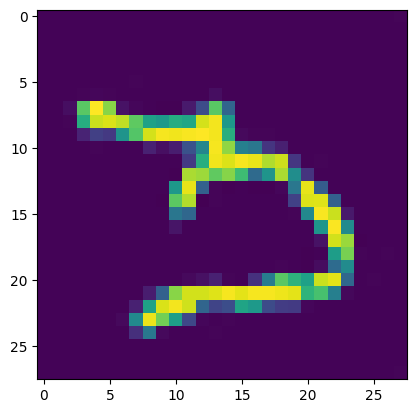

Epoch: 2  Total Loss: tensor(0.6397, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2362, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(3.2763, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2  Total Loss: tensor(0.6452, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2382, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0497, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(3.2763, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2  Total Loss: tensor(0.6596, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2432, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(3.2763, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2  

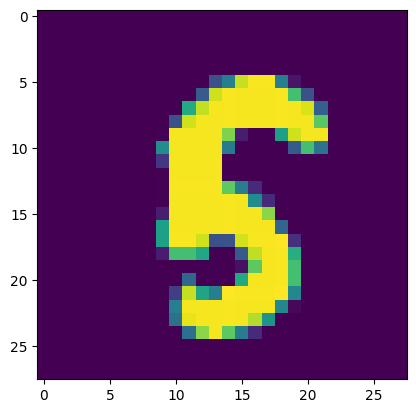

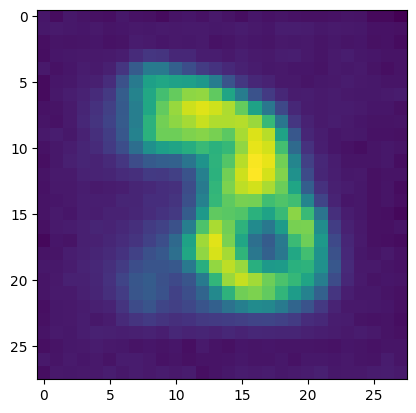

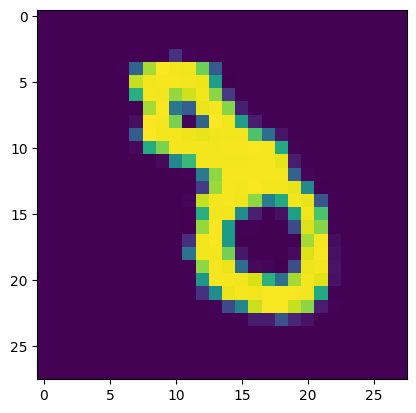

Epoch: 3  Total Loss: tensor(0.6367, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2328, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(3.1576, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3  Total Loss: tensor(0.6163, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2232, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(3.1576, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3  Total Loss: tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2210, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(3.1576, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3  

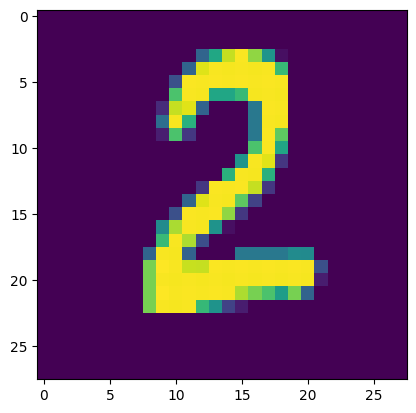

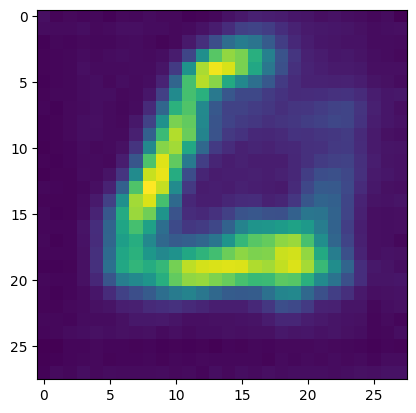

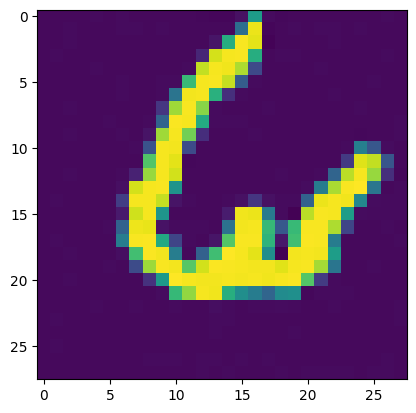

Epoch: 4  Total Loss: tensor(0.6174, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2211, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.0039, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4  Total Loss: tensor(0.6951, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2507, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.0039, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4  Total Loss: tensor(0.6607, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2364, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.0039, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4  

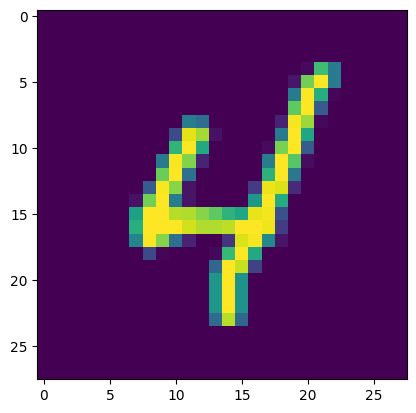

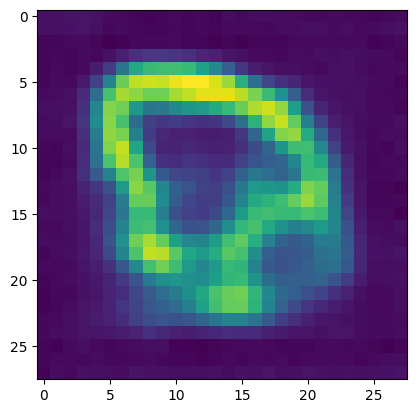

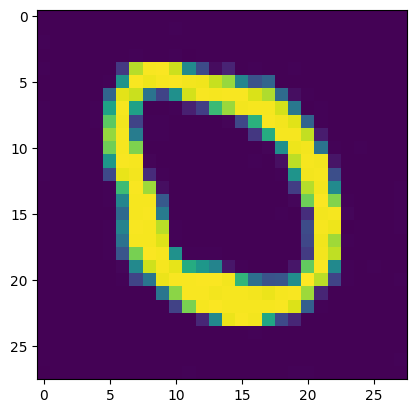

Epoch: 5  Total Loss: tensor(0.6167, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2168, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(2.8845, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5  Total Loss: tensor(0.6286, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2213, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(2.8845, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5  Total Loss: tensor(0.6466, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2257, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(2.8845, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5  

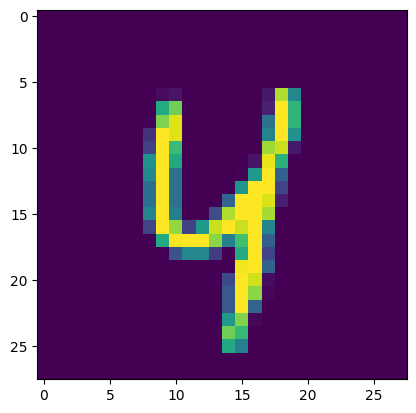

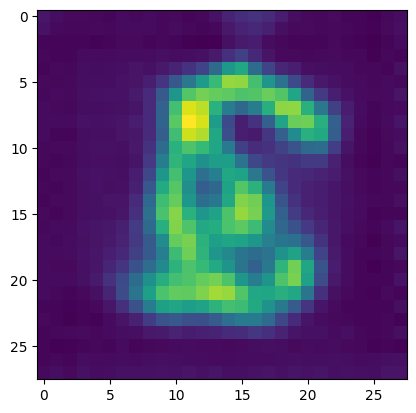

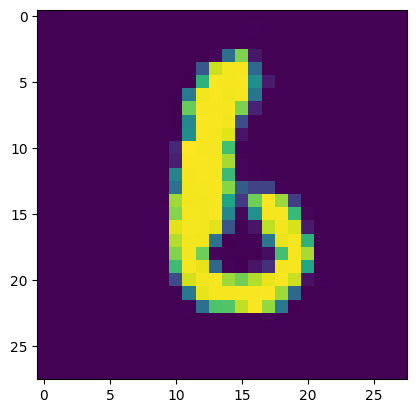

Epoch: 6  Total Loss: tensor(0.6346, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2196, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(2.7340, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6  Total Loss: tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2140, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(2.7340, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6  Total Loss: tensor(0.6444, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2222, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(2.7340, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6  

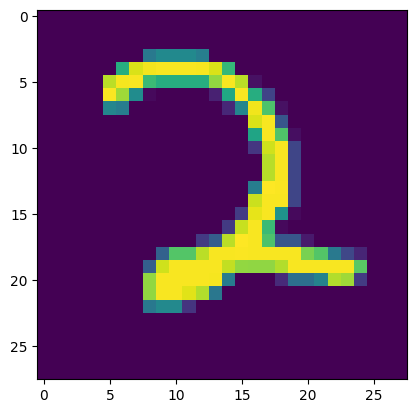

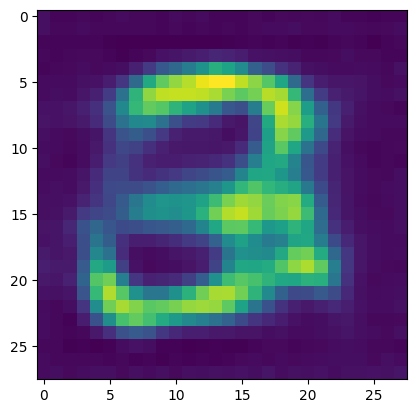

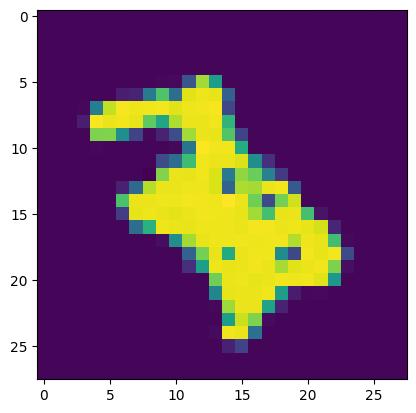

Epoch: 7  Total Loss: tensor(0.6236, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2104, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(2.5682, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7  Total Loss: tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2245, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(2.5682, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7  Total Loss: tensor(0.6997, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2399, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(2.5682, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7  

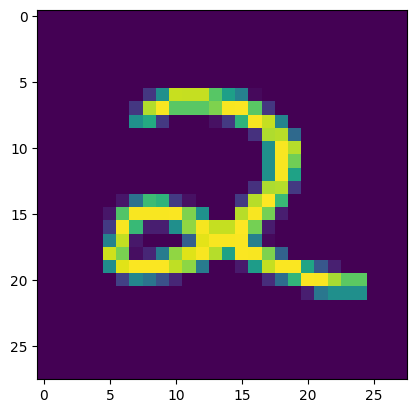

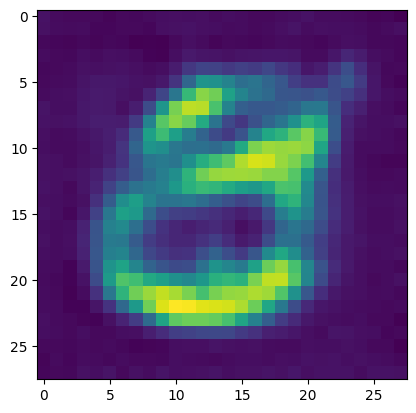

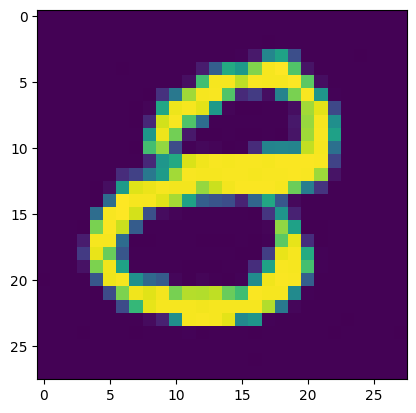

Epoch: 8  Total Loss: tensor(0.6219, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2050, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(2.4710, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8  Total Loss: tensor(0.6776, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2274, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(2.4710, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8  Total Loss: tensor(0.6930, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2338, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(2.4710, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8  

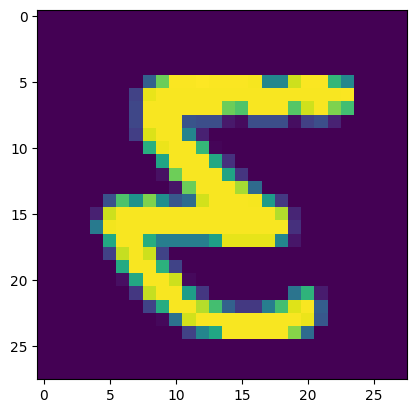

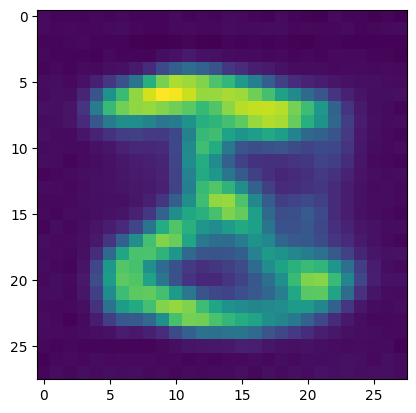

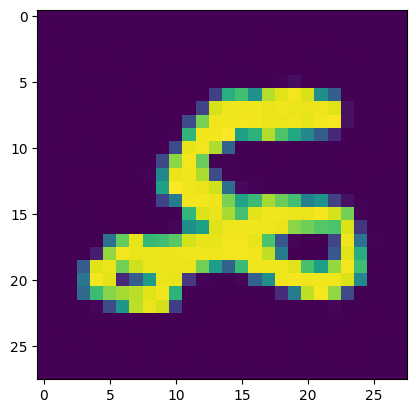

Epoch: 9  Total Loss: tensor(0.6732, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2230, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(2.3823, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9  Total Loss: tensor(0.6942, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2304, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(2.3823, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9  Total Loss: tensor(0.6370, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2078, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(2.3823, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9  

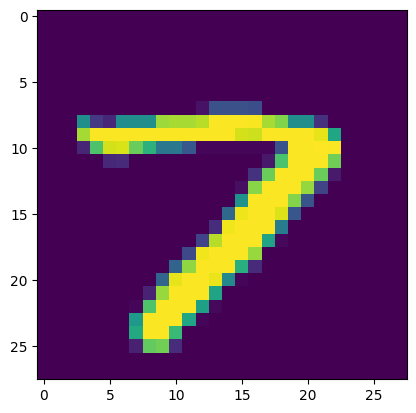

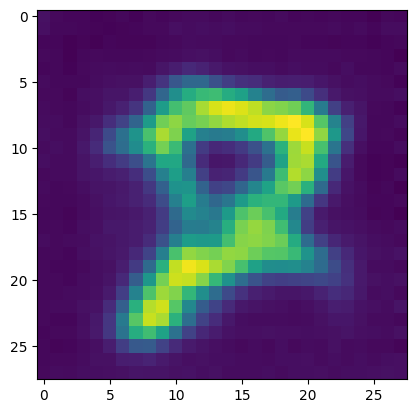

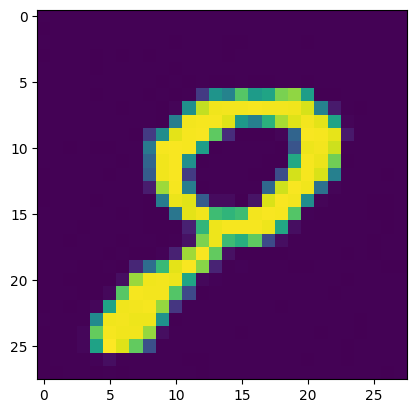

Epoch: 10  Total Loss: tensor(0.6574, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2141, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(2.3313, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 10  Total Loss: tensor(0.6980, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2310, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(2.3313, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 10  Total Loss: tensor(0.6721, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2195, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(2.3313, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

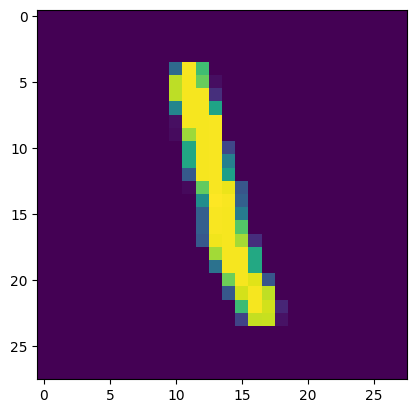

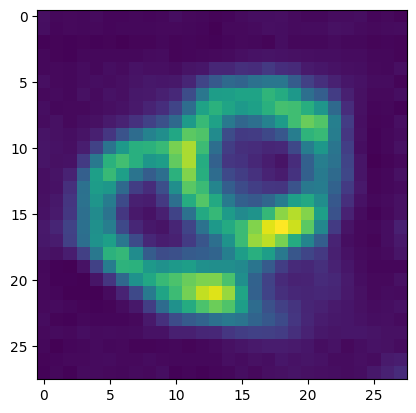

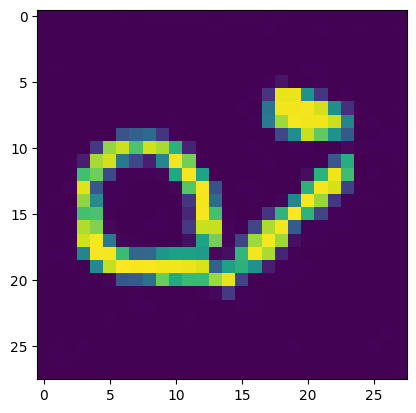

Epoch: 11  Total Loss: tensor(0.6799, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2236, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(2.2744, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 11  Total Loss: tensor(0.6813, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2246, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(2.2744, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 11  Total Loss: tensor(0.6955, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2293, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(2.2744, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

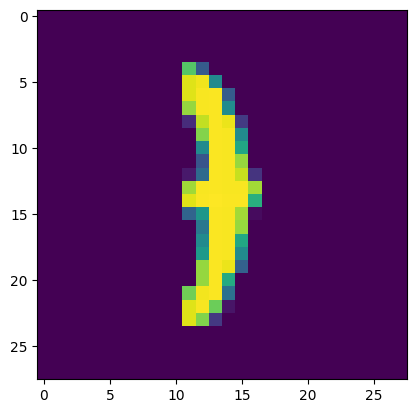

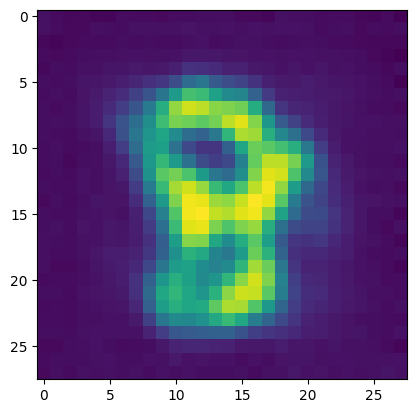

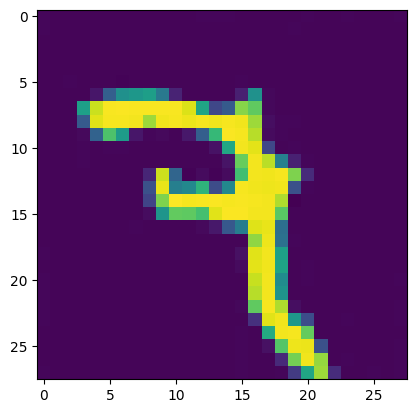

Epoch: 12  Total Loss: tensor(0.6983, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2305, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(2.3089, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 12  Total Loss: tensor(0.6538, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2152, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(2.3089, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 12  Total Loss: tensor(0.6965, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2310, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(2.3089, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

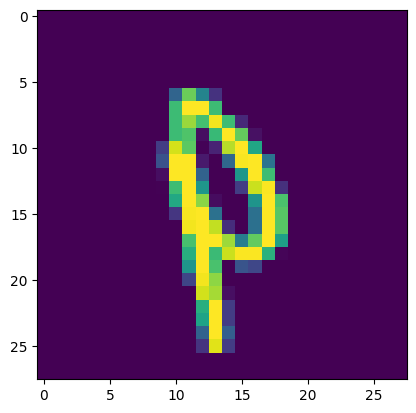

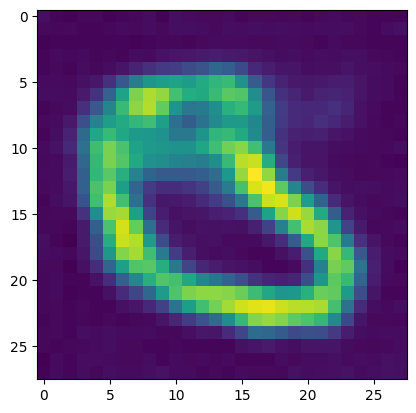

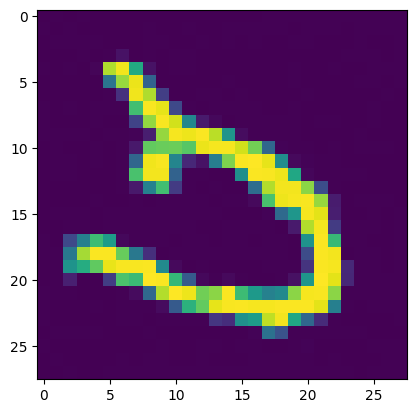

Epoch: 13  Total Loss: tensor(0.6645, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2198, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(2.3175, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 13  Total Loss: tensor(0.6626, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2199, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(2.3175, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 13  Total Loss: tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2237, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(2.3175, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

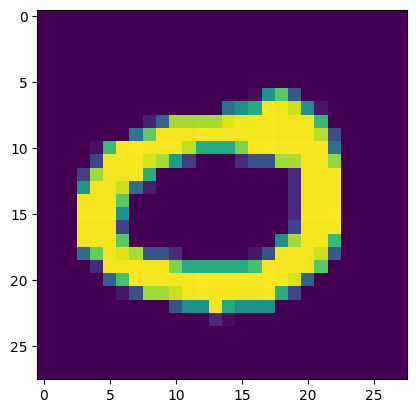

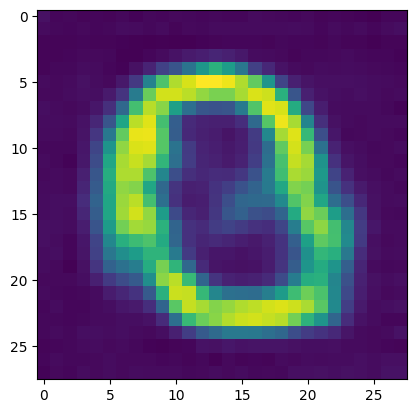

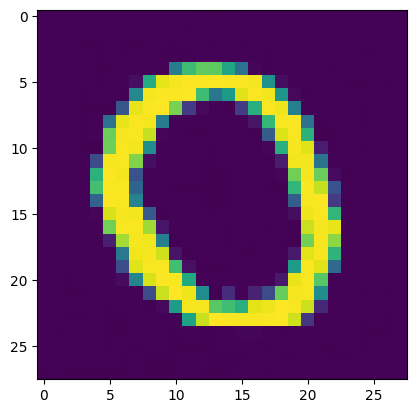

Epoch: 14  Total Loss: tensor(0.6739, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2262, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(2.3946, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 14  Total Loss: tensor(0.6875, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2318, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(2.3946, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 14  Total Loss: tensor(0.6345, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2098, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(2.3946, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

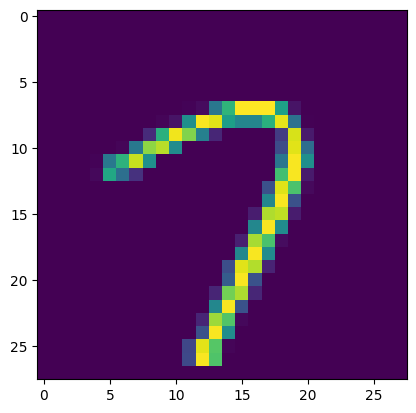

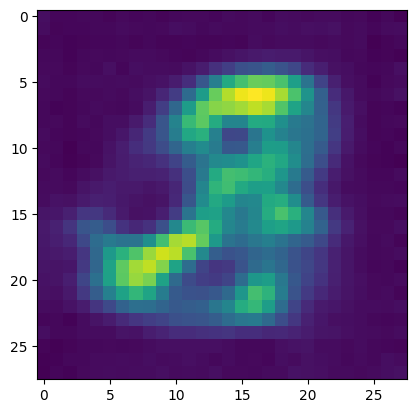

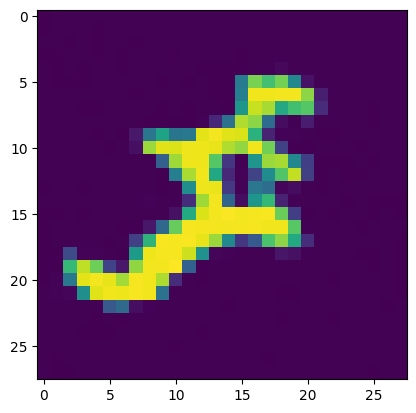

Epoch: 15  Total Loss: tensor(0.6428, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2145, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 15  Adversarial Loss:tensor(2.4031, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 15  Total Loss: tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2253, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 15  Adversarial Loss:tensor(2.4031, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 15  Total Loss: tensor(0.6632, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2232, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 15  Adversarial Loss:tensor(2.4031, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

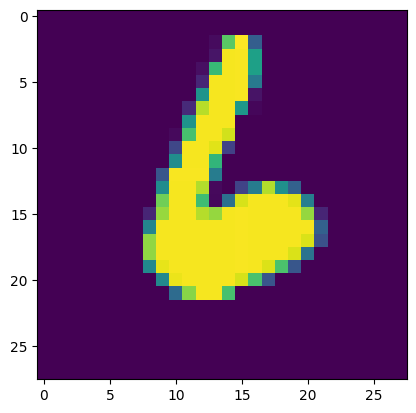

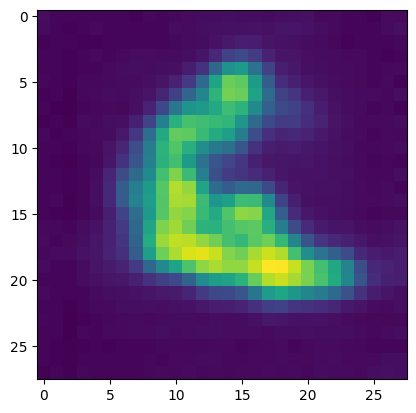

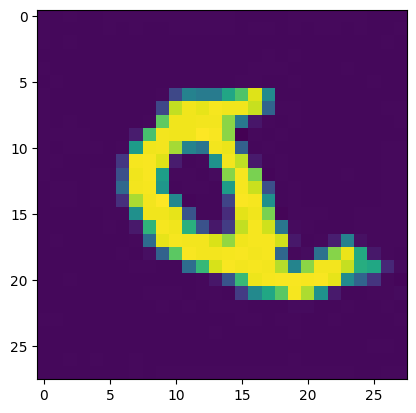

Epoch: 16  Total Loss: tensor(0.6643, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2223, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 16  Adversarial Loss:tensor(2.3985, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 16  Total Loss: tensor(0.6456, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2162, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 16  Adversarial Loss:tensor(2.3985, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 16  Total Loss: tensor(0.6584, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2210, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 16  Adversarial Loss:tensor(2.3985, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

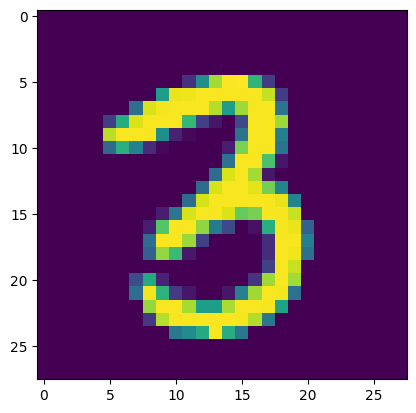

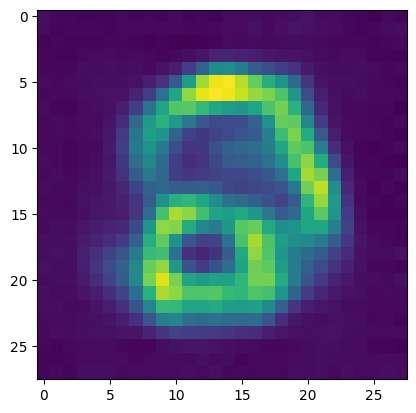

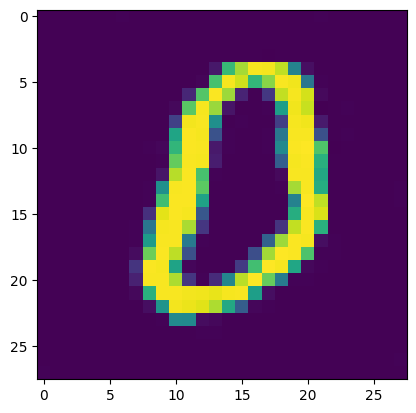

Epoch: 17  Total Loss: tensor(0.6560, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2202, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 17  Adversarial Loss:tensor(2.4021, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 17  Total Loss: tensor(0.6480, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2163, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 17  Adversarial Loss:tensor(2.4021, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 17  Total Loss: tensor(0.6476, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2174, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 17  Adversarial Loss:tensor(2.4021, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

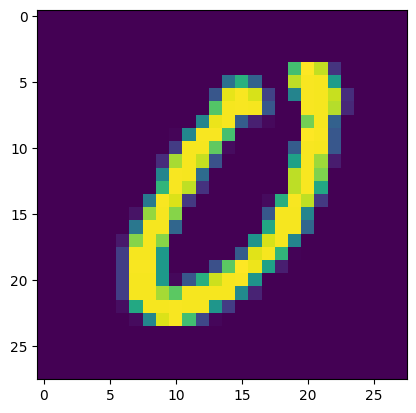

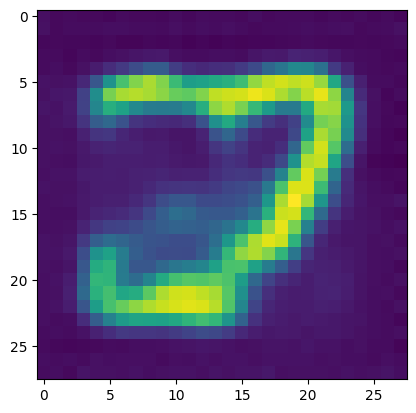

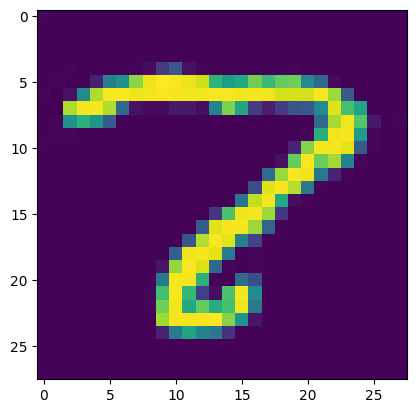

Epoch: 18  Total Loss: tensor(0.6474, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2172, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 18  Adversarial Loss:tensor(2.4318, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 18  Total Loss: tensor(0.6528, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2188, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 18  Adversarial Loss:tensor(2.4318, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 18  Total Loss: tensor(0.6526, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2190, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 18  Adversarial Loss:tensor(2.4318, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

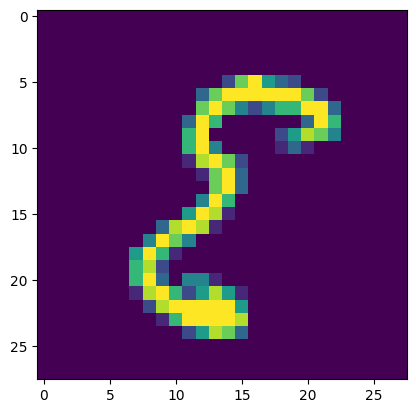

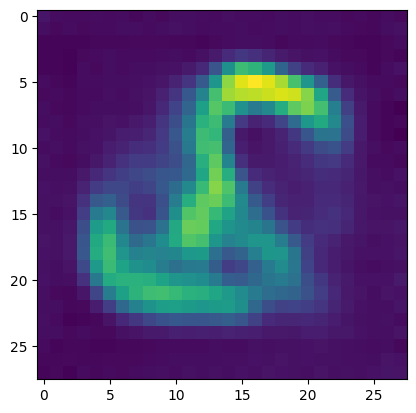

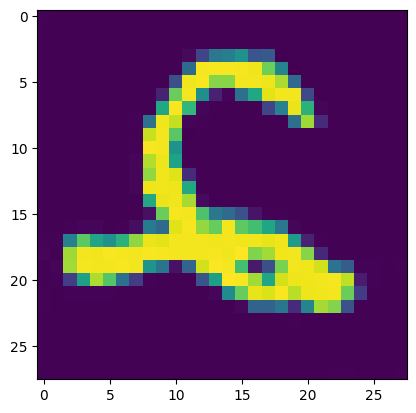

Epoch: 19  Total Loss: tensor(0.6880, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2331, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 19  Adversarial Loss:tensor(2.4010, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 19  Total Loss: tensor(0.6276, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2086, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 19  Adversarial Loss:tensor(2.4010, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 19  Total Loss: tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2261, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 19  Adversarial Loss:tensor(2.4010, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

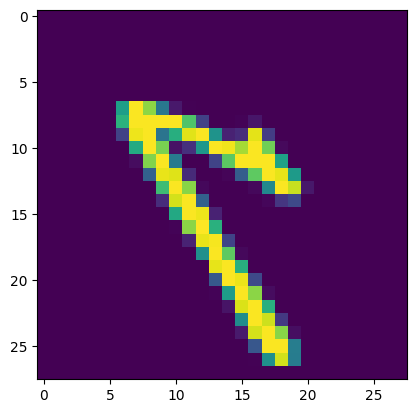

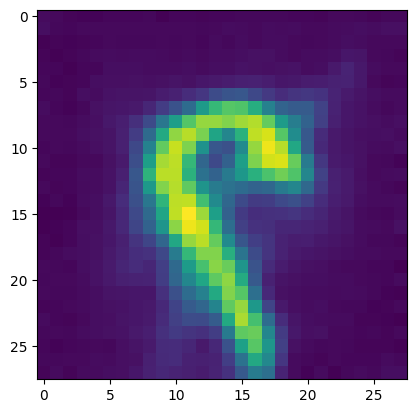

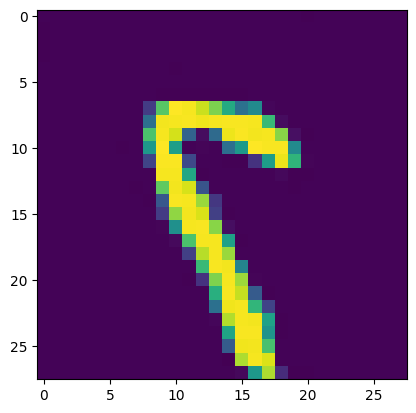

Epoch: 20  Total Loss: tensor(0.6575, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2205, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 20  Adversarial Loss:tensor(2.4228, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 20  Total Loss: tensor(0.6735, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2276, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 20  Adversarial Loss:tensor(2.4228, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 20  Total Loss: tensor(0.6487, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2158, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 20  Adversarial Loss:tensor(2.4228, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

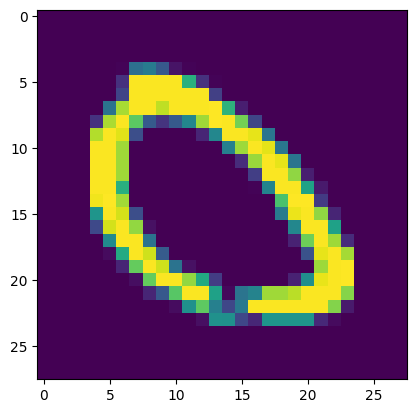

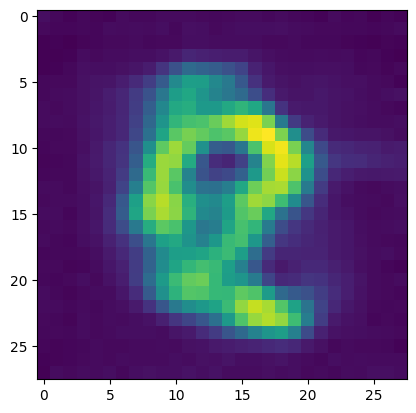

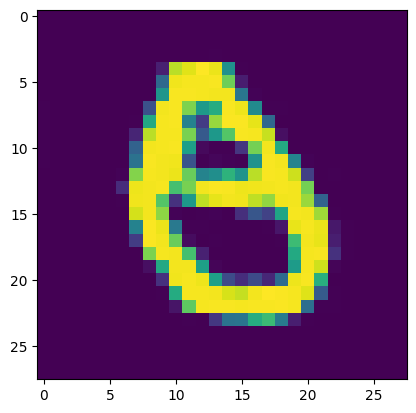

Epoch: 21  Total Loss: tensor(0.6564, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2193, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 21  Adversarial Loss:tensor(2.3947, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 21  Total Loss: tensor(0.6880, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2328, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 21  Adversarial Loss:tensor(2.3947, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 21  Total Loss: tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2228, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 21  Adversarial Loss:tensor(2.3947, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

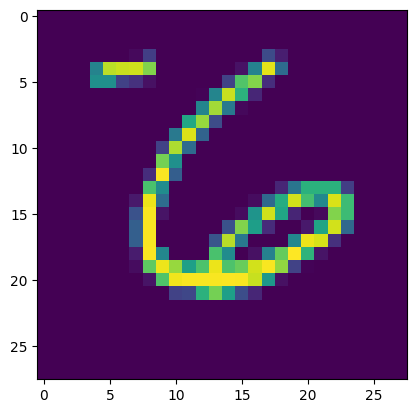

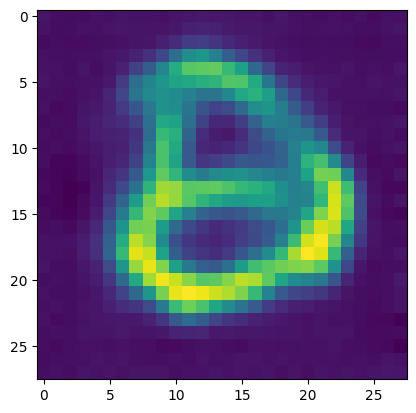

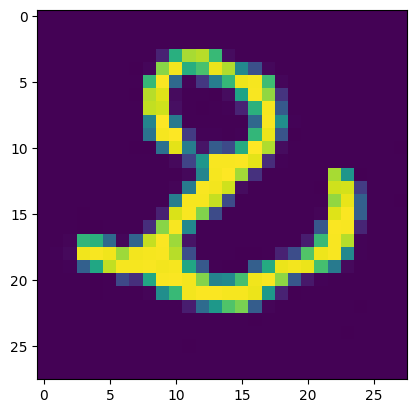

Epoch: 22  Total Loss: tensor(0.6820, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2295, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 22  Adversarial Loss:tensor(2.4109, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 22  Total Loss: tensor(0.6493, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2164, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 22  Adversarial Loss:tensor(2.4109, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 22  Total Loss: tensor(0.6911, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2339, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 22  Adversarial Loss:tensor(2.4109, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

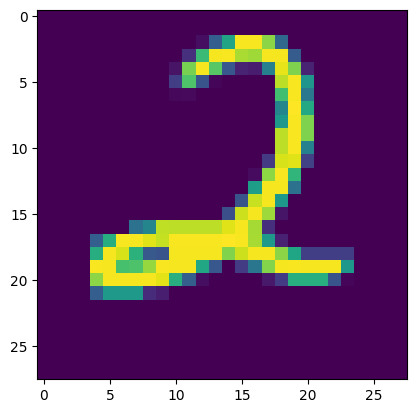

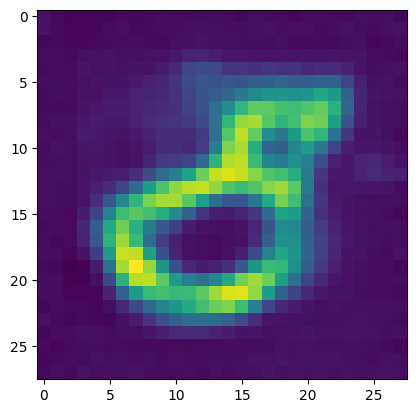

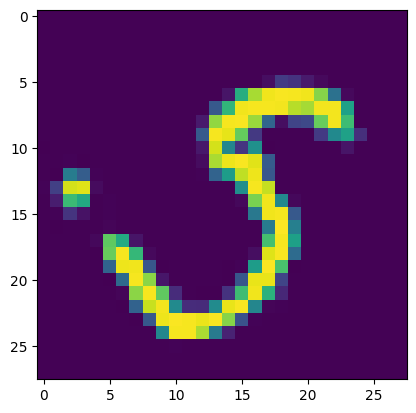

Epoch: 23  Total Loss: tensor(0.6676, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2245, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 23  Adversarial Loss:tensor(2.4122, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 23  Total Loss: tensor(0.7017, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2374, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 23  Adversarial Loss:tensor(2.4122, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 23  Total Loss: tensor(0.6690, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2245, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 23  Adversarial Loss:tensor(2.4122, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

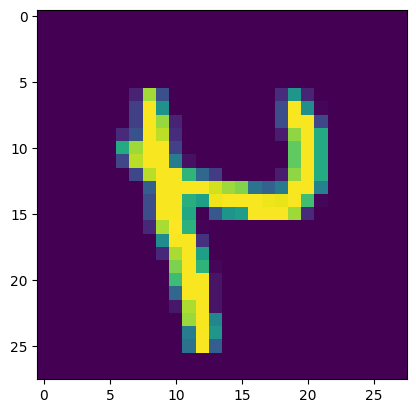

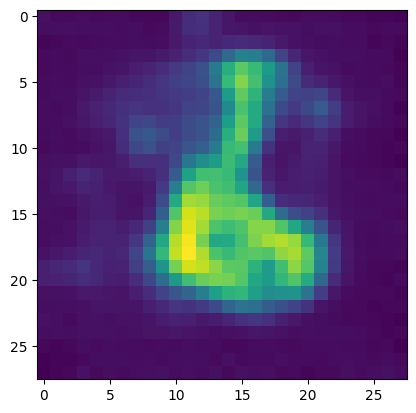

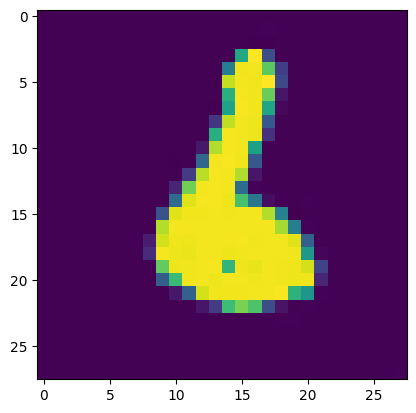

Epoch: 24  Total Loss: tensor(0.6514, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2177, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 24  Adversarial Loss:tensor(2.4011, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 24  Total Loss: tensor(0.6600, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2215, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 24  Adversarial Loss:tensor(2.4011, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 24  Total Loss: tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2128, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 24  Adversarial Loss:tensor(2.4011, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

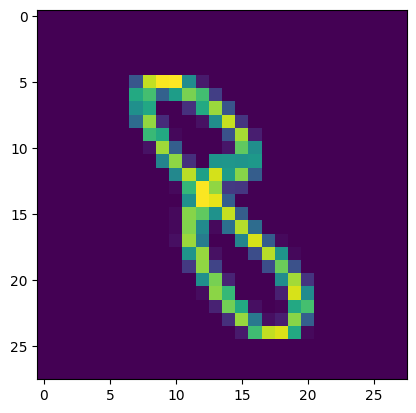

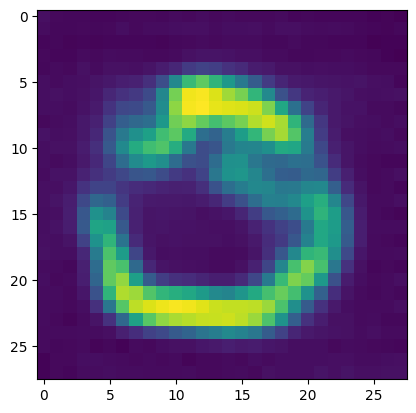

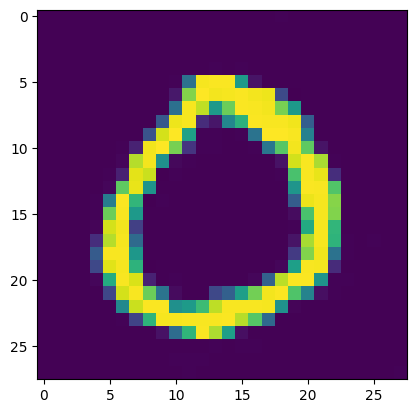

Epoch: 25  Total Loss: tensor(0.6428, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2141, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 25  Adversarial Loss:tensor(2.3904, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 25  Total Loss: tensor(0.6835, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2306, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 25  Adversarial Loss:tensor(2.3904, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 25  Total Loss: tensor(0.6413, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2146, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 25  Adversarial Loss:tensor(2.3904, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

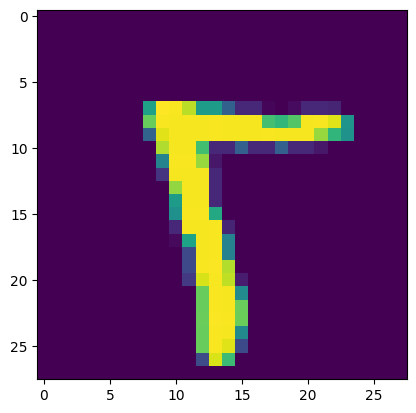

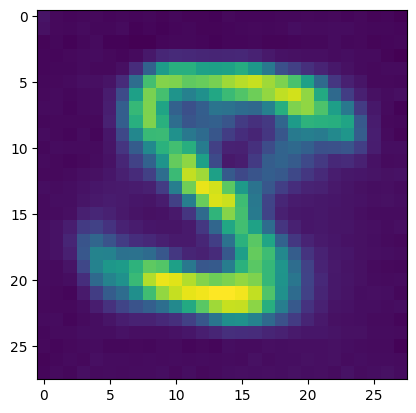

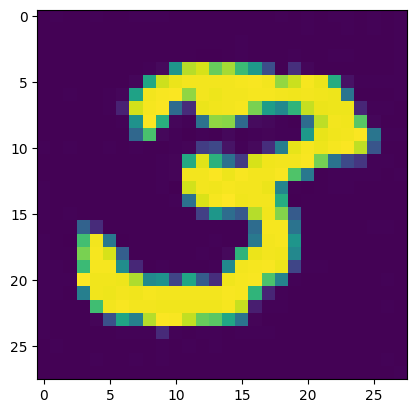

Epoch: 26  Total Loss: tensor(0.6661, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2240, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 26  Adversarial Loss:tensor(2.4291, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 26  Total Loss: tensor(0.6750, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2275, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 26  Adversarial Loss:tensor(2.4291, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 26  Total Loss: tensor(0.6534, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2187, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 26  Adversarial Loss:tensor(2.4291, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

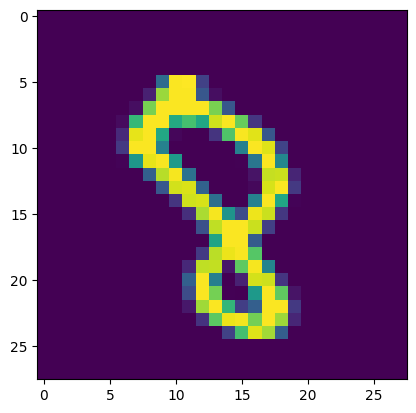

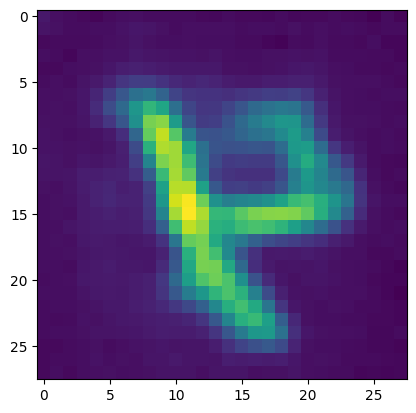

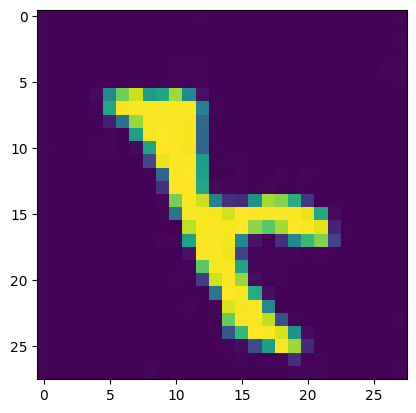

Epoch: 27  Total Loss: tensor(0.6633, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2221, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 27  Adversarial Loss:tensor(2.3968, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 27  Total Loss: tensor(0.6645, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2226, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 27  Adversarial Loss:tensor(2.3968, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 27  Total Loss: tensor(0.6870, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2328, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 27  Adversarial Loss:tensor(2.3968, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

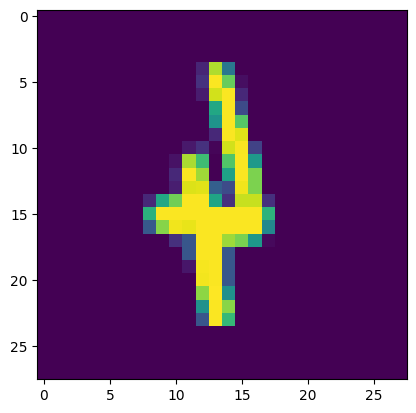

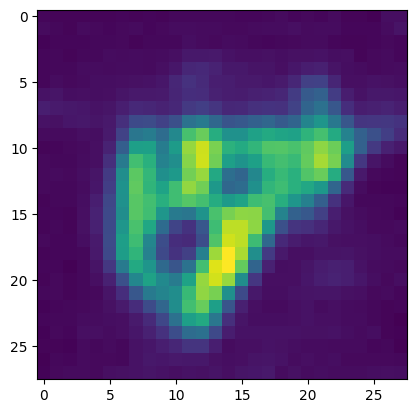

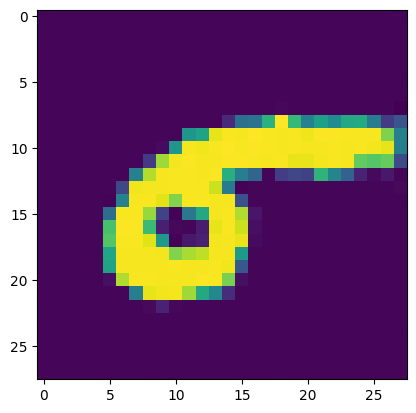

Epoch: 28  Total Loss: tensor(0.6325, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2096, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 28  Adversarial Loss:tensor(2.3771, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 28  Total Loss: tensor(0.6624, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2223, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 28  Adversarial Loss:tensor(2.3771, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 28  Total Loss: tensor(0.6487, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2166, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 28  Adversarial Loss:tensor(2.3771, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

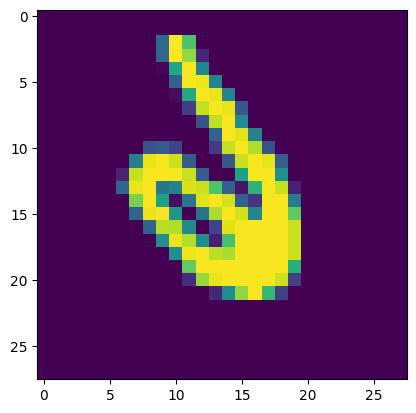

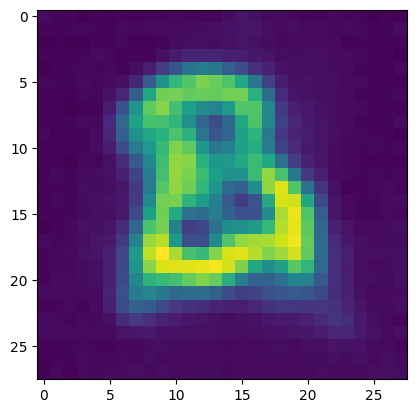

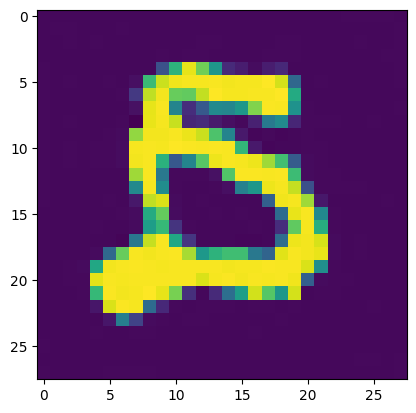

Epoch: 29  Total Loss: tensor(0.7256, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2483, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 29  Adversarial Loss:tensor(2.4053, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 29  Total Loss: tensor(0.6537, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2197, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 29  Adversarial Loss:tensor(2.4053, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 29  Total Loss: tensor(0.6765, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2284, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 29  Adversarial Loss:tensor(2.4053, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

In [ ]:
torch.cuda.empty_cache()
epochs = 30

student_optimizer = Adam(student_model.parameters(), lr=1e-3, weight_decay=1e-5)
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=2, factor=0.05)
scheduler_discriminator = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, 'min', patience=2, factor=0.05)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 10:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(teacher_timesteps, teacher_timesteps*2, (batch_size,), device=device).long()
      t_teacher = torch.randint(teacher_timesteps, teacher_timesteps*2, (batch_size,), device=device).long()

      noise = torch.randn_like(batch)
      x_noisy_student = q_sample(x_start=batch, t=t_student, noise=noise)

      student_data = sample( student_model, x_noisy_student[0] , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      output_real = discriminator_model(batch)
      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, fake_labels)

      if step % 10==0:
        # Calcolo totale della loss
        adversarial_loss = loss_real + loss_fake
        adversarial_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_teacher[0], image_size, timestep=teacher_timesteps,  batch_size=batch_size, channels=channels)

      if step % 10 == 0:
          random_index = random.randint(0, 63)
          #show the results
          image_data0 = batch[random_index].cpu().numpy().reshape(image_size, image_size, channels)
          image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
          image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
          plt.imshow(image_data0)
          plt.show()
          plt.imshow(image_data1)
          plt.show()
          plt.imshow(image_data3)
          plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])

      loss = l*distill_loss + loss_fake
      losses.append(loss)

      print("Epoch: " + str(epoch) + "  Total Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)
    scheduler_discriminator.step(adversarial_loss)

In [ ]:
#discriminator_path = '/content/drive/MyDrive/discriminator_model.pth'
#student_path = '/content/drive/MyDrive/student_model.pth'

# Salva il modello
#torch.save(discriminator_model.state_dict(), discriminator_path)
#torch.save(student_model.state_dict(), student_path)

## Train from Noise

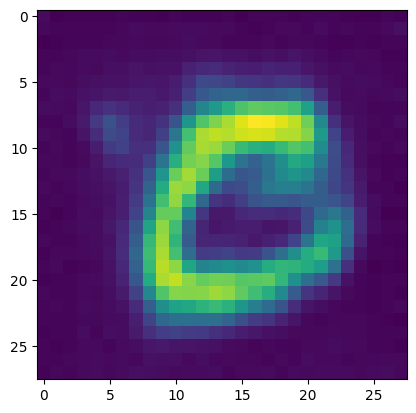

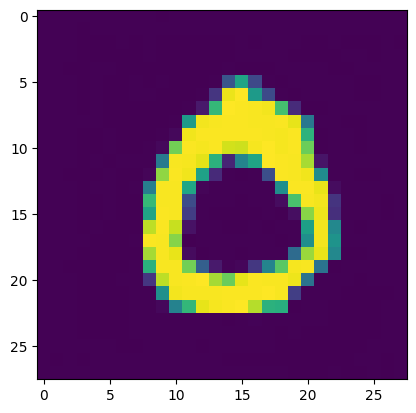

Regularization Term    tensor(-0.1997, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1784, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


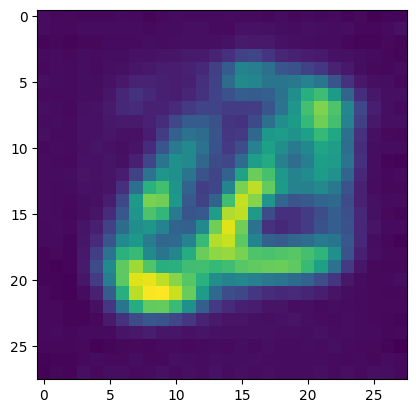

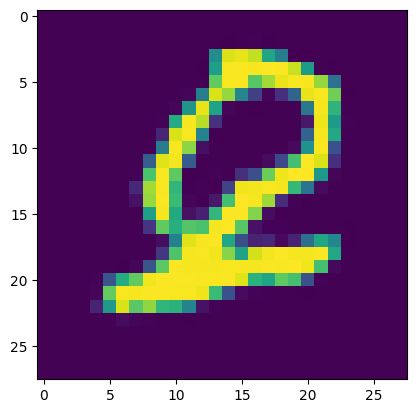

Regularization Term    tensor(-0.2019, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1813, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


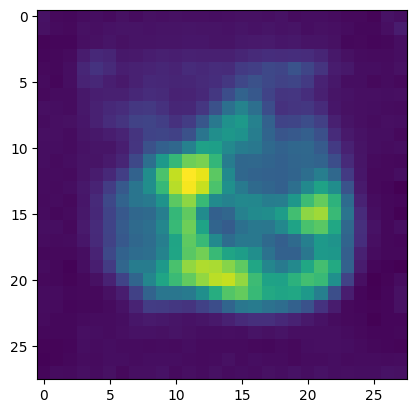

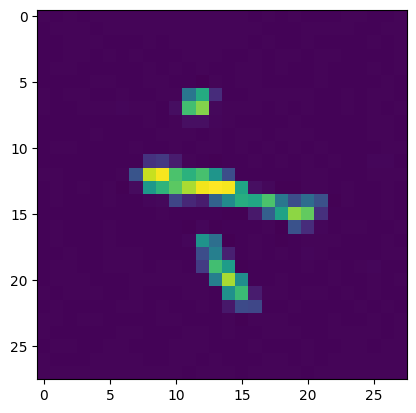

Regularization Term    tensor(-0.1941, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1705, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


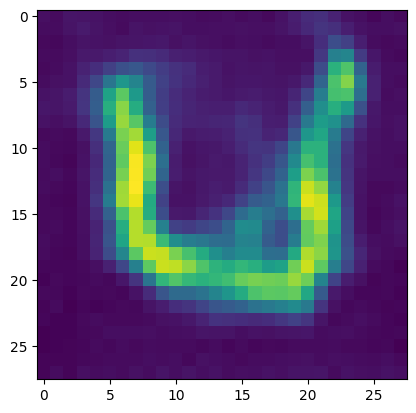

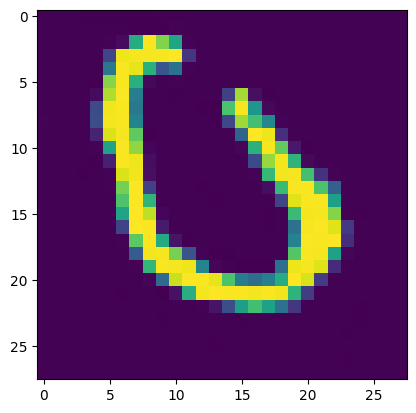

Regularization Term    tensor(-0.1961, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1751, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


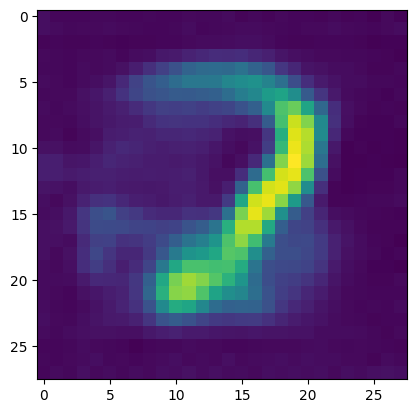

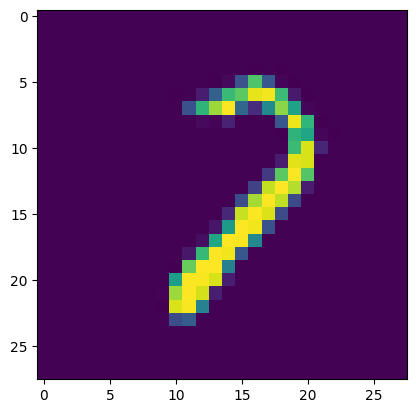

Regularization Term    tensor(-0.1892, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5526, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1793, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


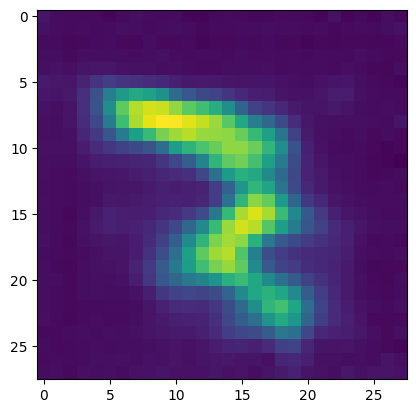

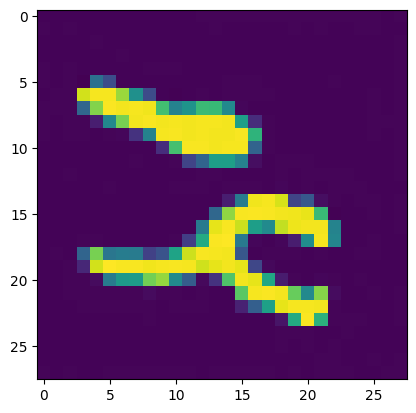

Regularization Term    tensor(-0.1915, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5203, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1673, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


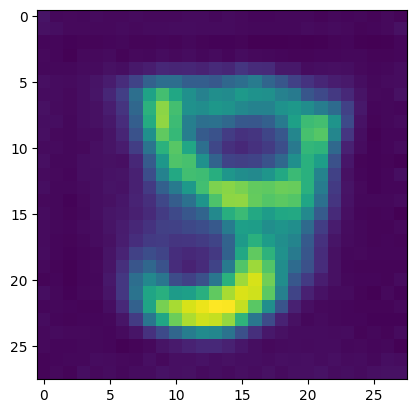

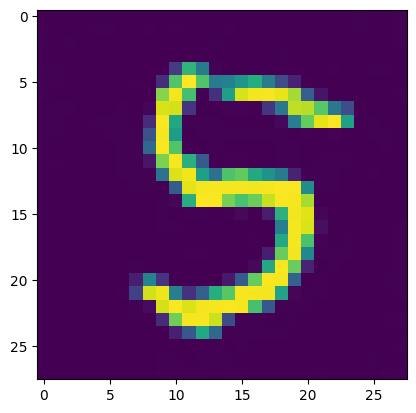

Regularization Term    tensor(-0.1873, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5400, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1756, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


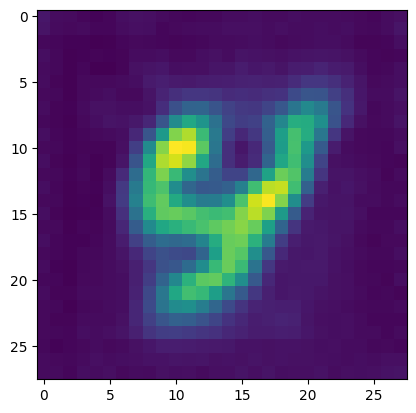

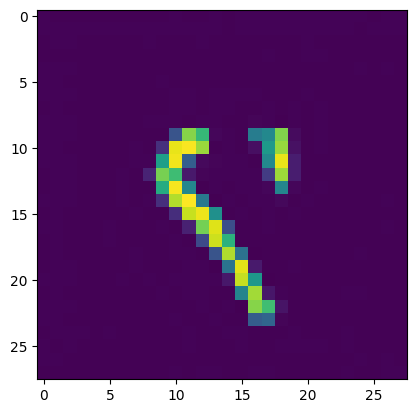

Regularization Term    tensor(-0.1762, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1793, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


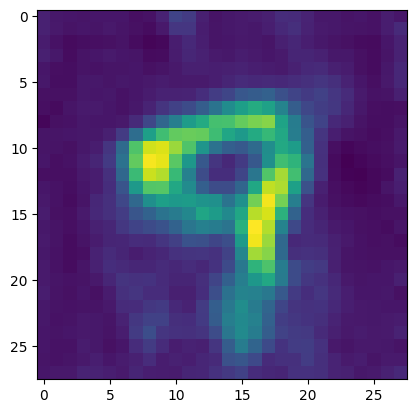

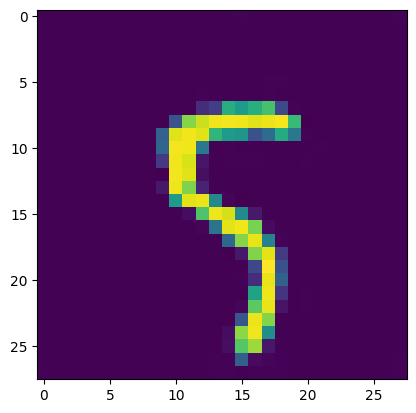

Regularization Term    tensor(-0.1730, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1791, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


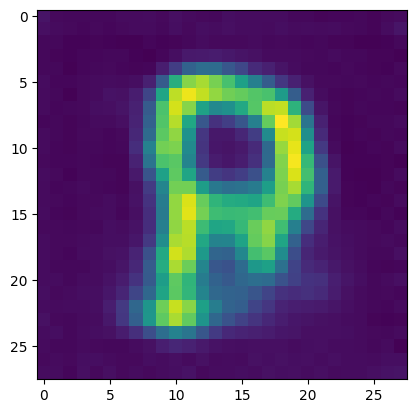

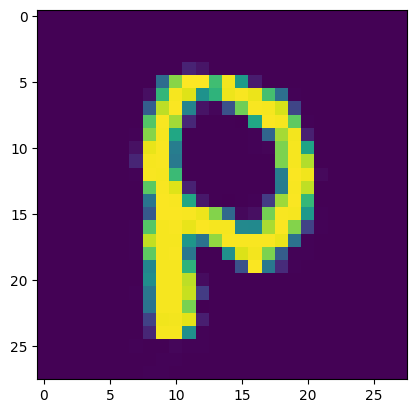

Regularization Term    tensor(-0.1700, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1649, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


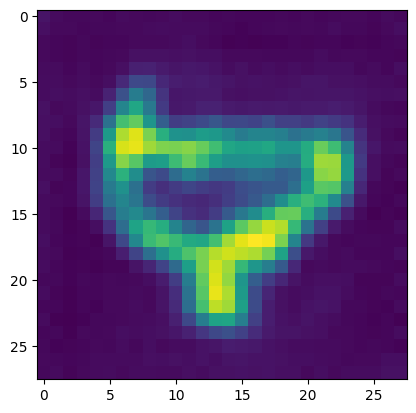

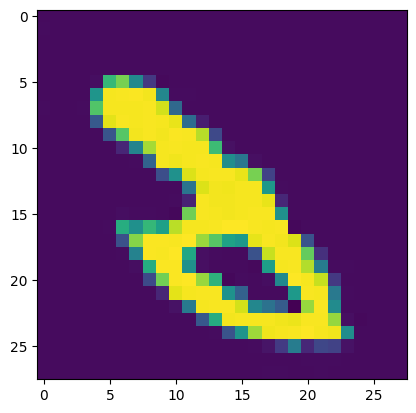

Regularization Term    tensor(-0.1631, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1658, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


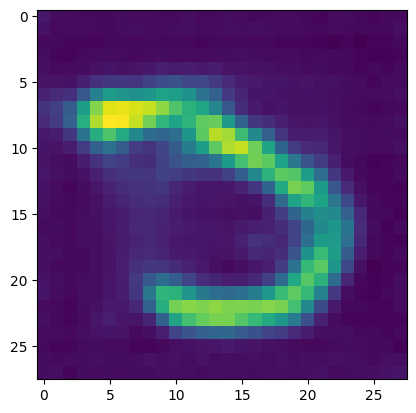

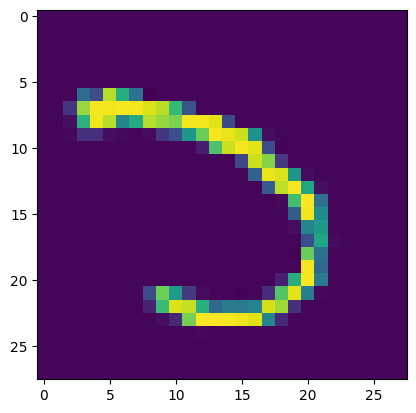

Regularization Term    tensor(-0.1670, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1628, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


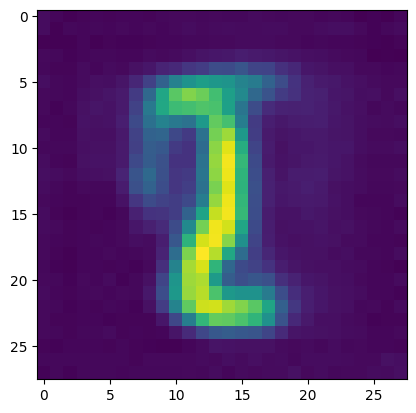

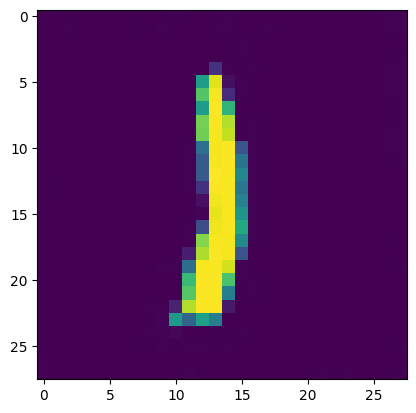

Regularization Term    tensor(-0.1655, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1714, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


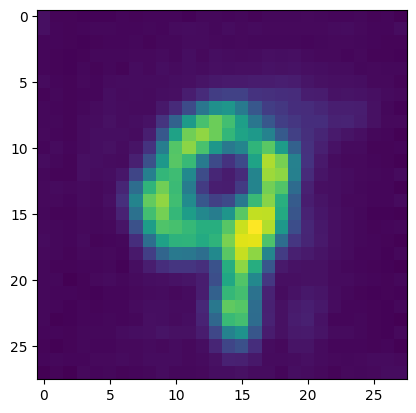

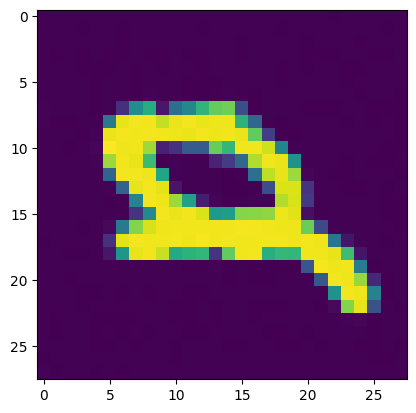

Regularization Term    tensor(-0.1621, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1884, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


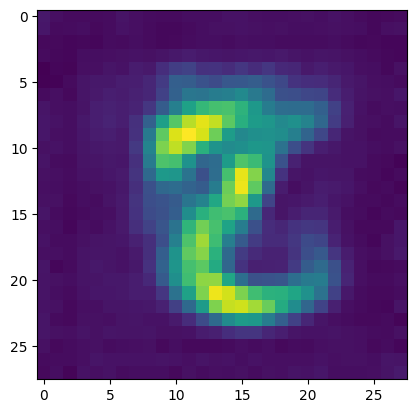

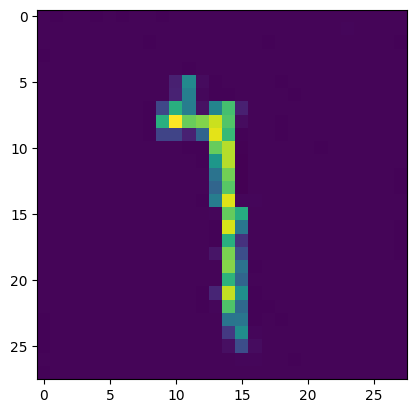

Regularization Term    tensor(-0.1654, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1802, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


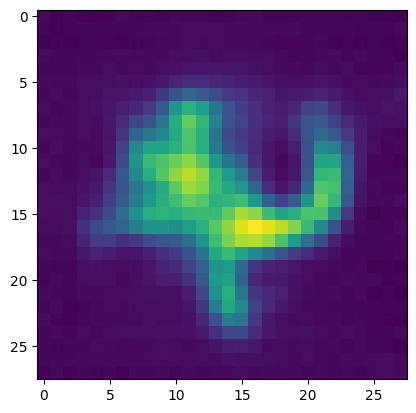

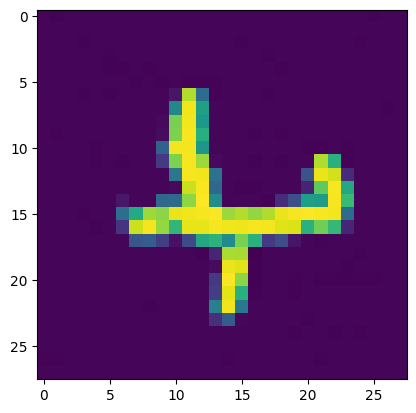

Regularization Term    tensor(-0.1708, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1565, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


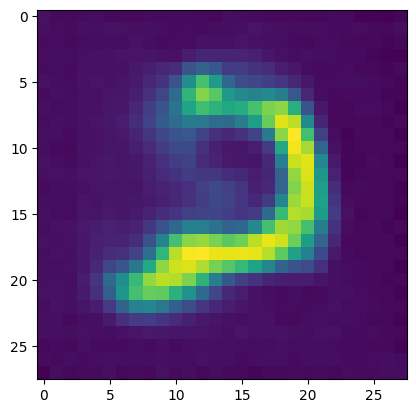

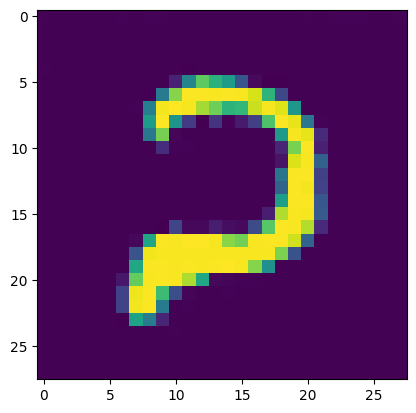

Regularization Term    tensor(-0.1679, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1684, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


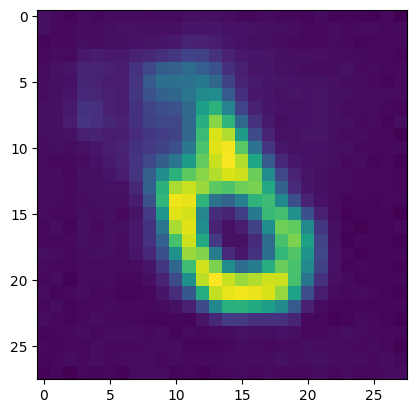

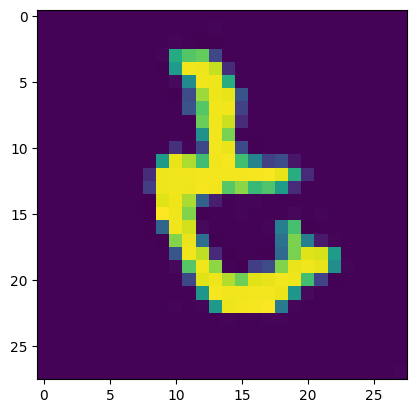

Regularization Term    tensor(-0.1823, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.5258, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1691, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


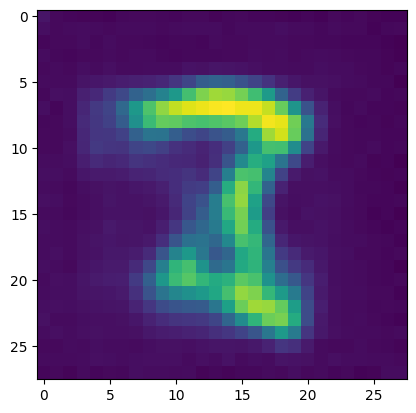

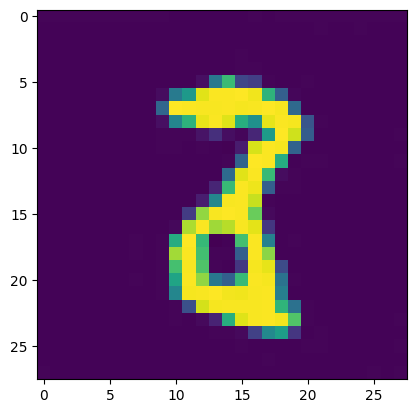

Regularization Term    tensor(-0.1626, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1707, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


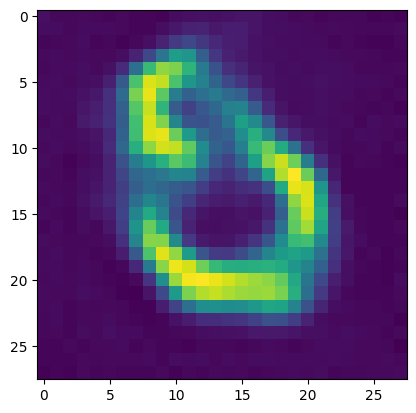

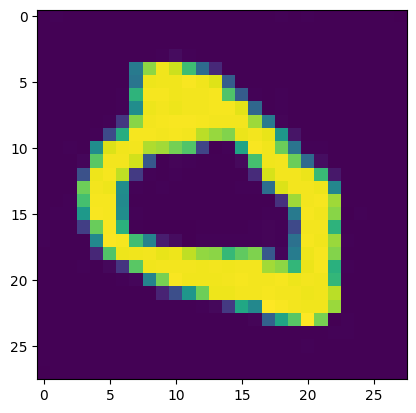

Regularization Term    tensor(-0.1778, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.5025, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1607, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


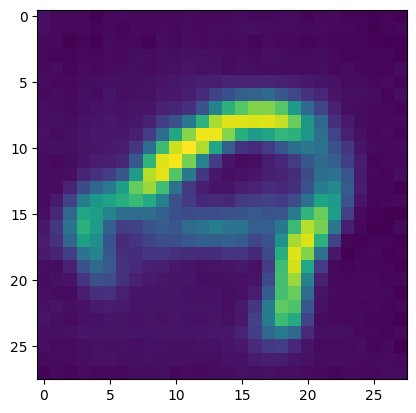

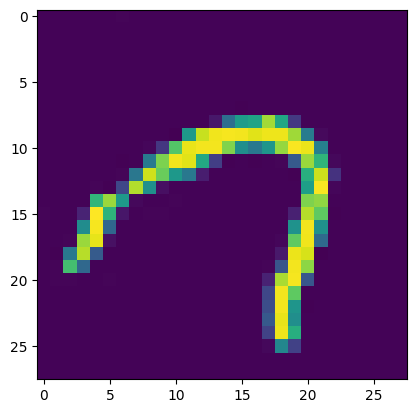

Regularization Term    tensor(-0.1854, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.5214, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1670, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


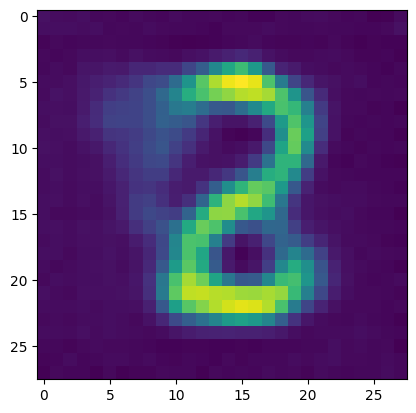

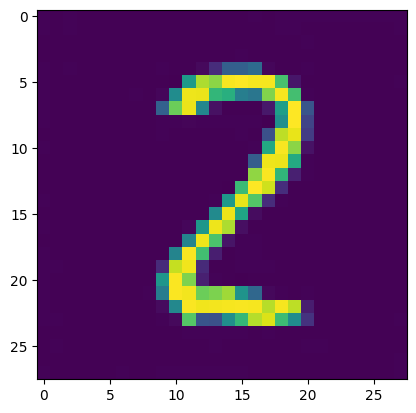

Regularization Term    tensor(-0.1820, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1543, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


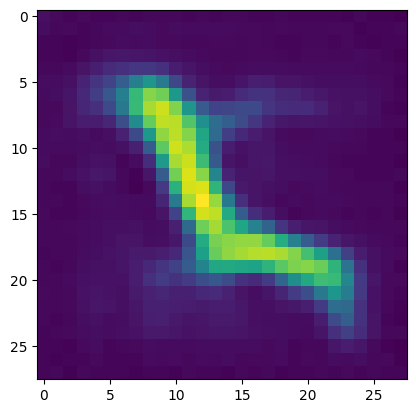

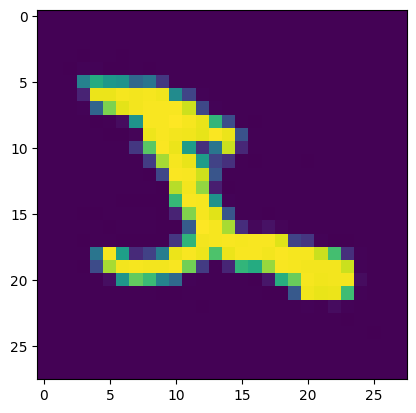

Regularization Term    tensor(-0.1896, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1623, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


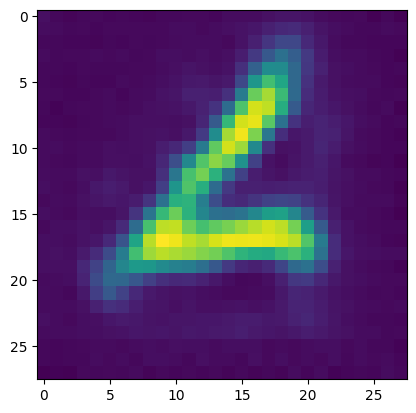

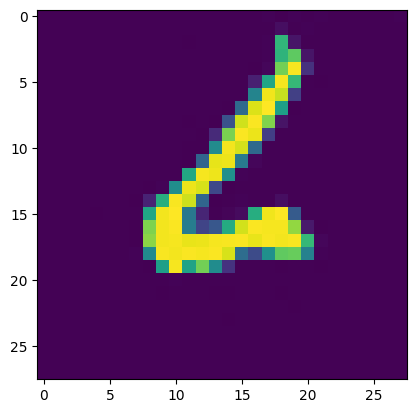

Regularization Term    tensor(-0.1944, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1731, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


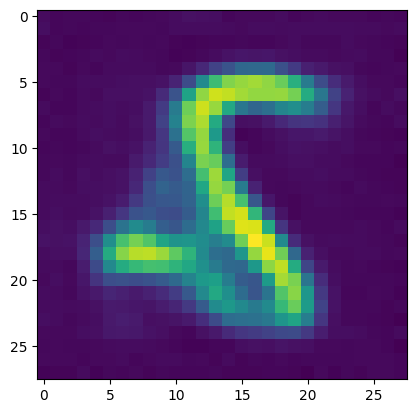

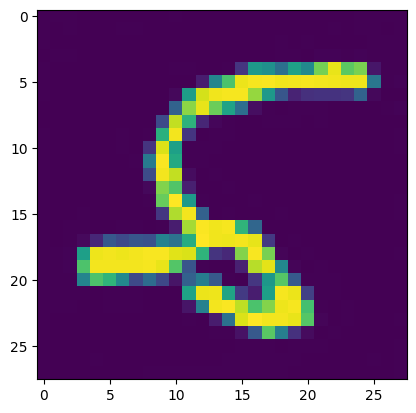

Regularization Term    tensor(-0.2045, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.5159, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1662, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


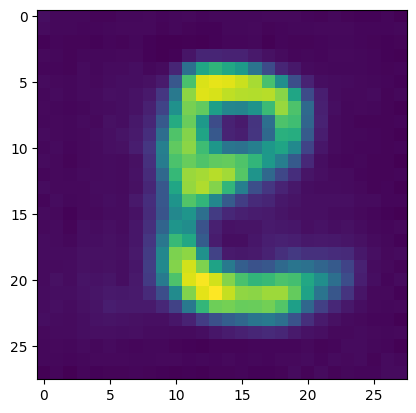

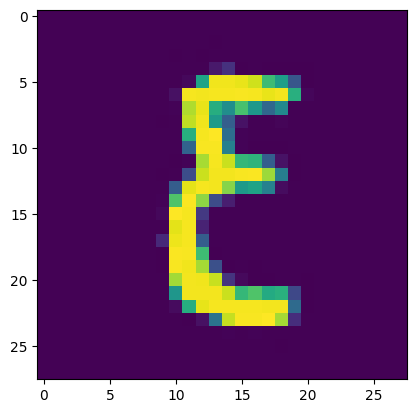

Regularization Term    tensor(-0.1988, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.5162, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1667, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


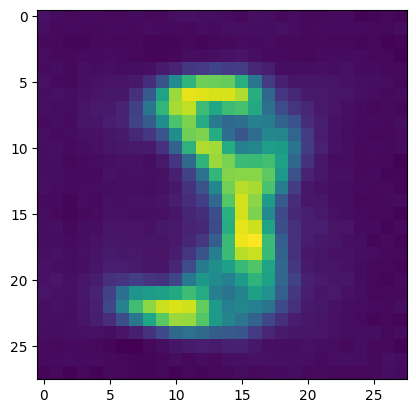

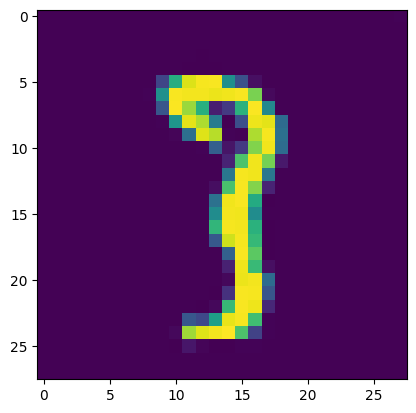

Regularization Term    tensor(-0.2083, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1663, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


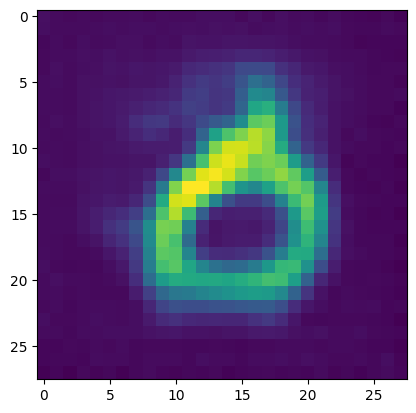

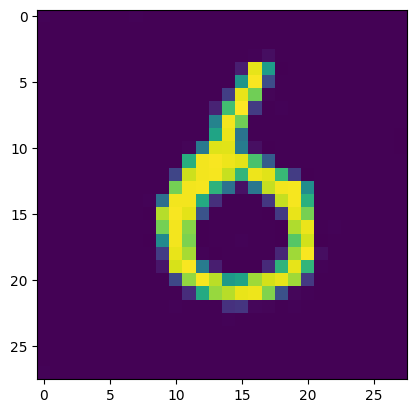

Regularization Term    tensor(-0.2123, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1515, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


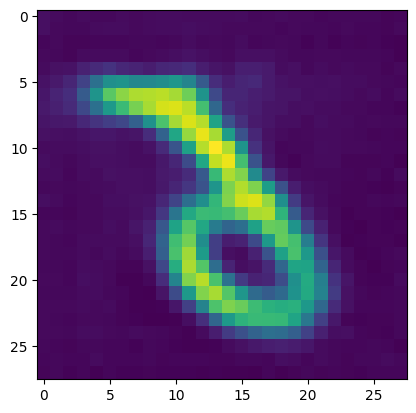

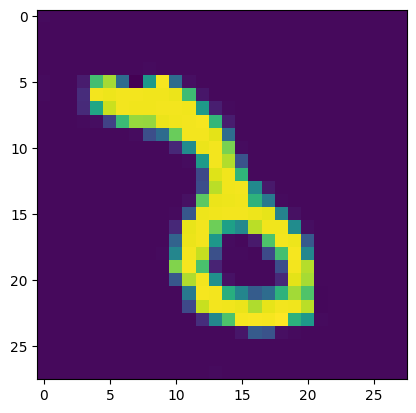

Regularization Term    tensor(-0.1996, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.4803, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1528, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


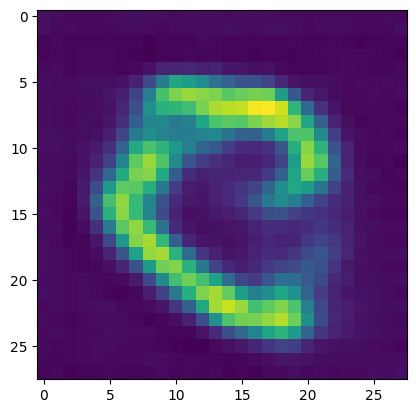

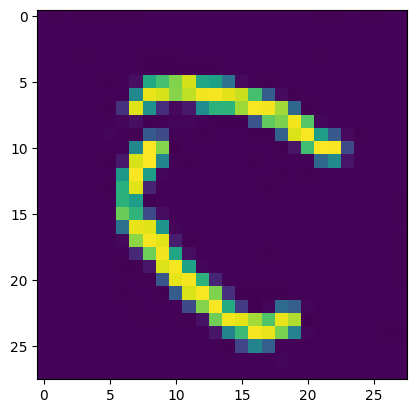

Regularization Term    tensor(-0.2153, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1572, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


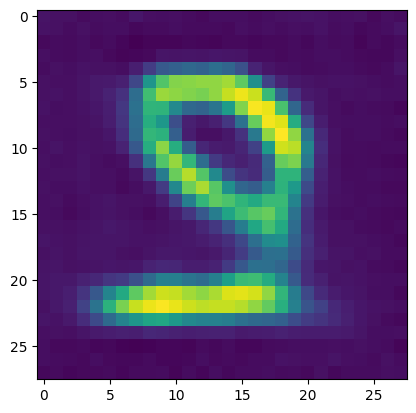

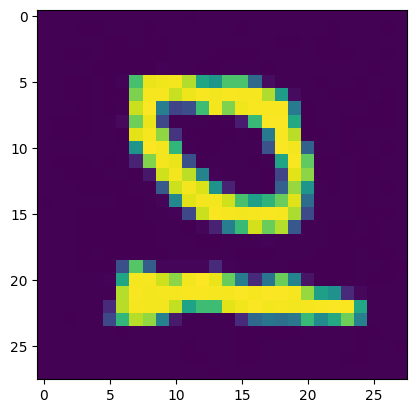

Regularization Term    tensor(-0.2177, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1563, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


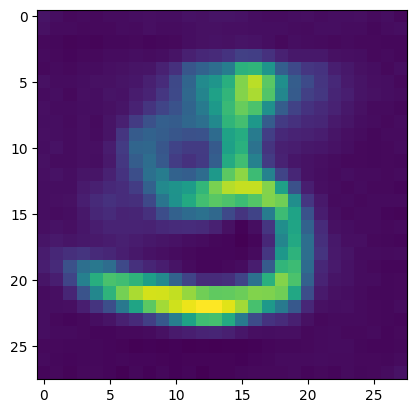

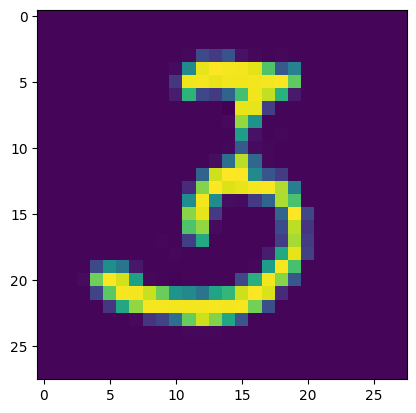

Regularization Term    tensor(-0.2178, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1564, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


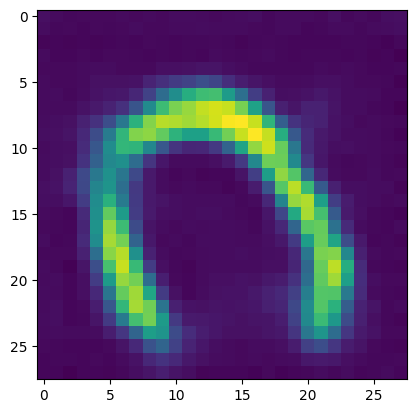

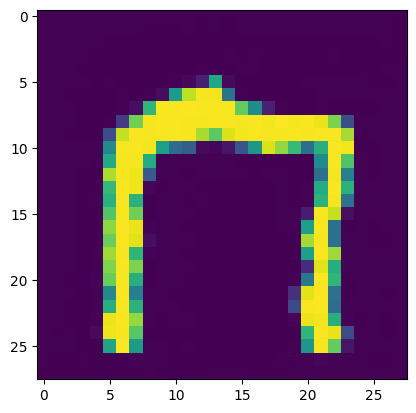

Regularization Term    tensor(-0.2228, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1600, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


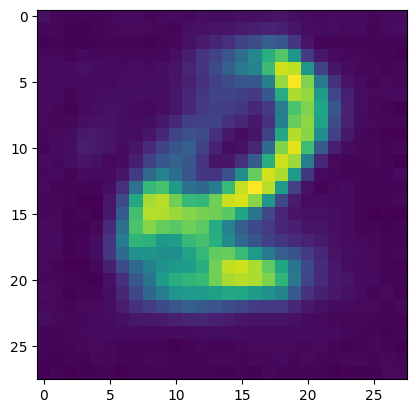

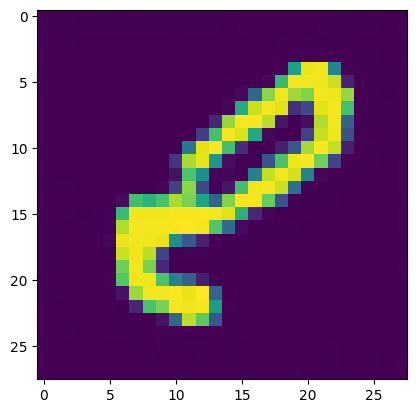

Regularization Term    tensor(-0.2173, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1522, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


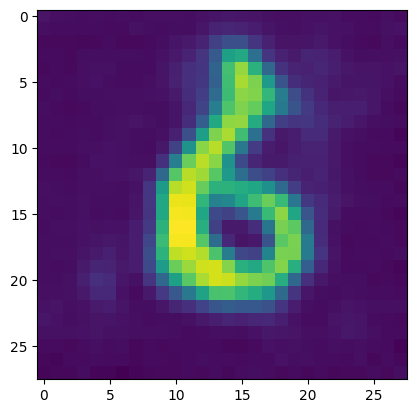

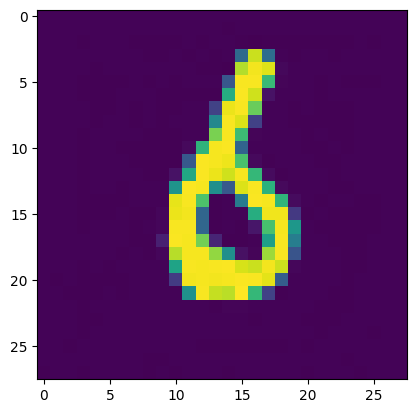

Regularization Term    tensor(-0.2162, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1623, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


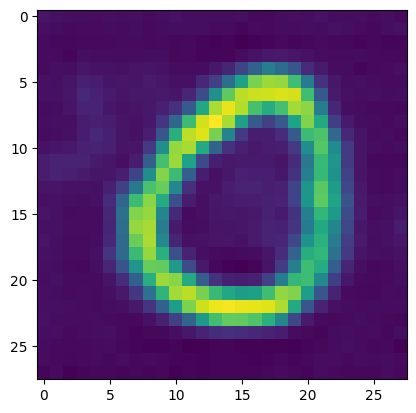

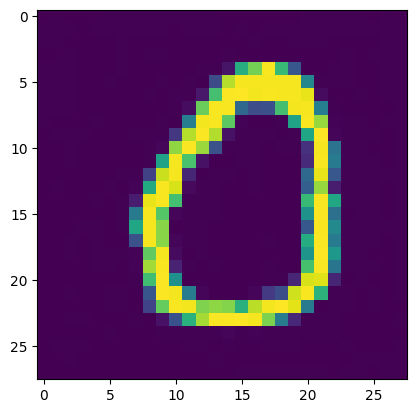

Regularization Term    tensor(-0.2205, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1396, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


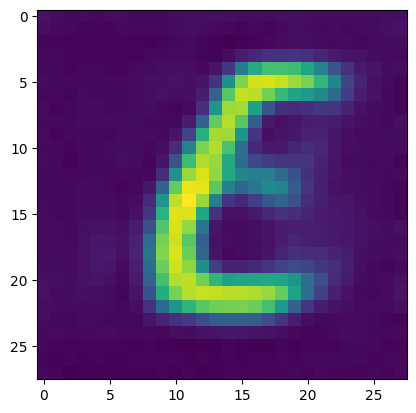

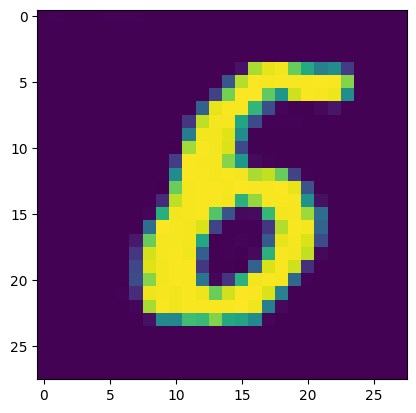

Regularization Term    tensor(-0.2204, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1534, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


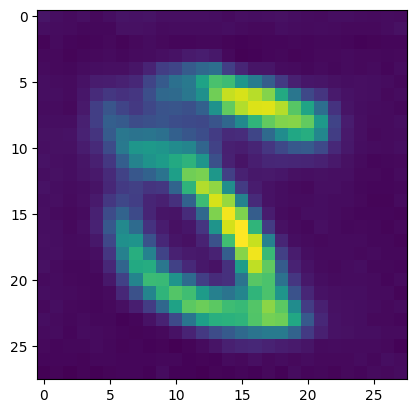

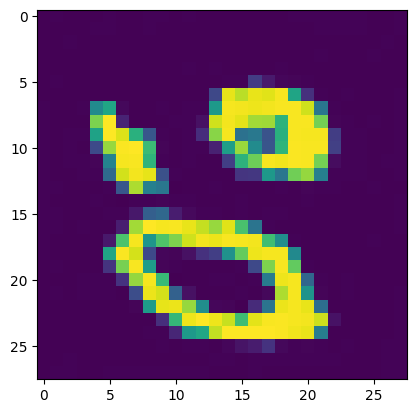

Regularization Term    tensor(-0.2213, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1568, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


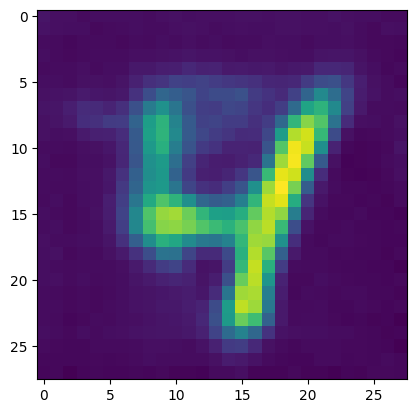

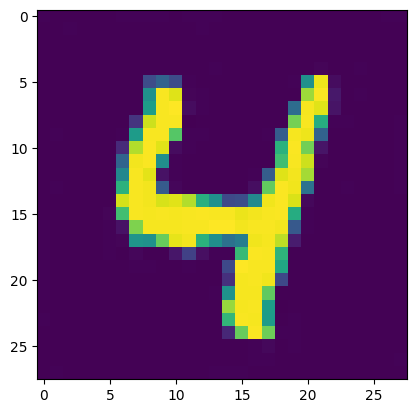

Regularization Term    tensor(-0.2112, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1367, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


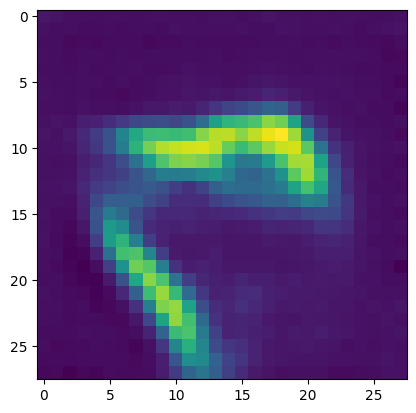

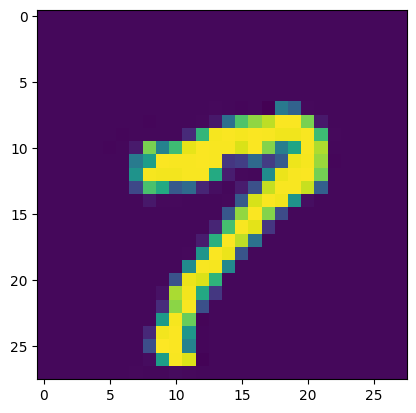

Regularization Term    tensor(-0.2212, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1493, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


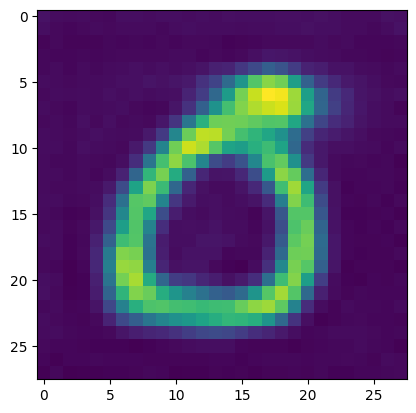

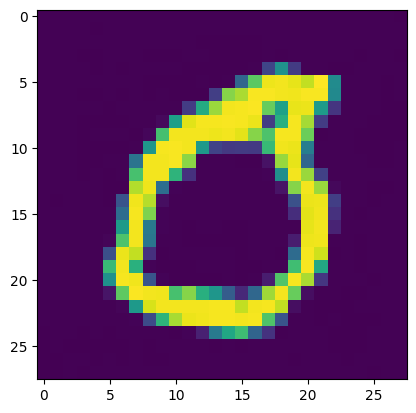

Regularization Term    tensor(-0.2095, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1446, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


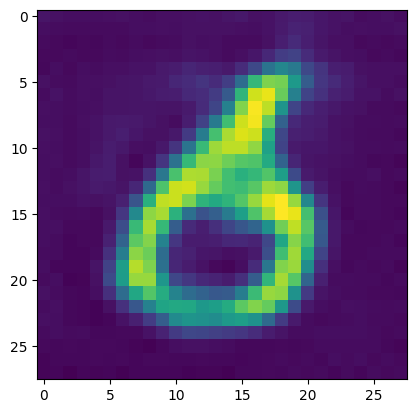

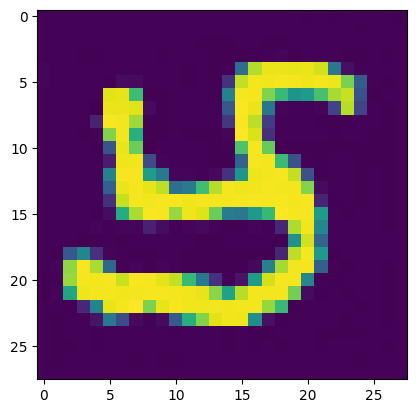

Regularization Term    tensor(-0.2025, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.5400, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1751, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


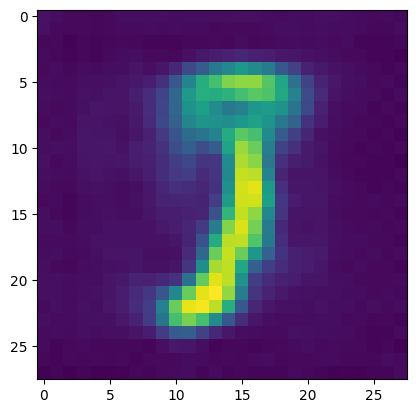

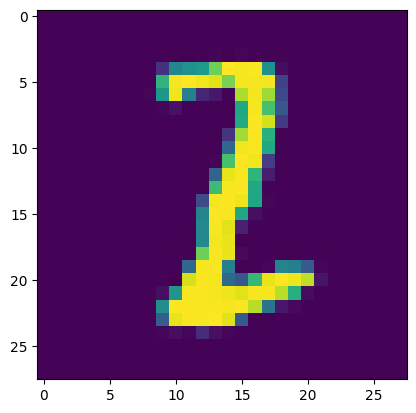

Regularization Term    tensor(-0.2112, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1530, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


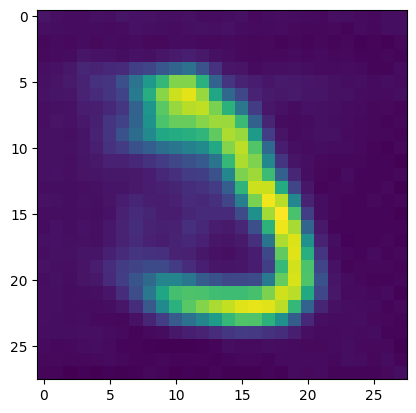

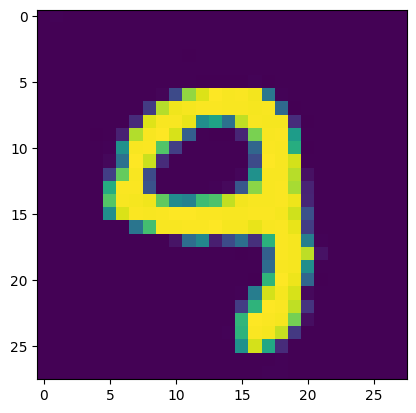

Regularization Term    tensor(-0.2084, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.4724, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1493, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


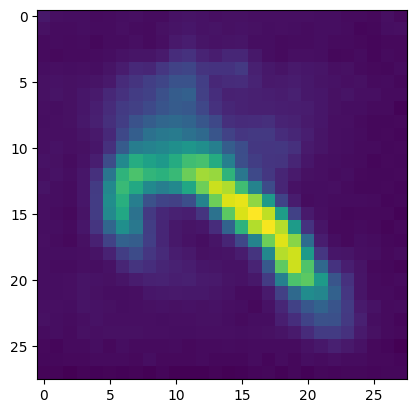

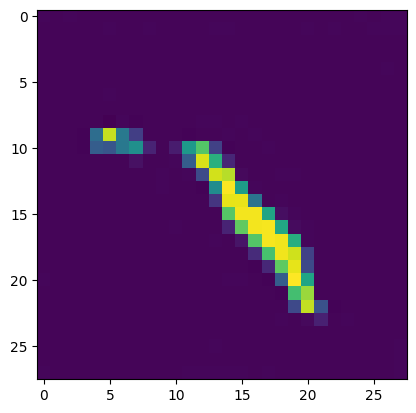

Regularization Term    tensor(-0.2133, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1501, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


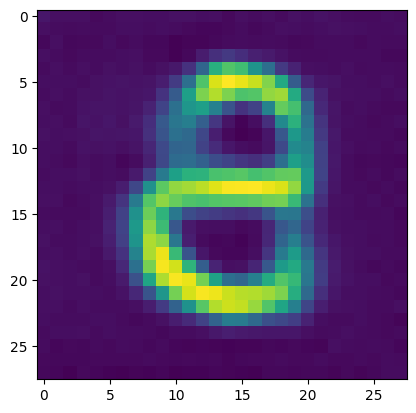

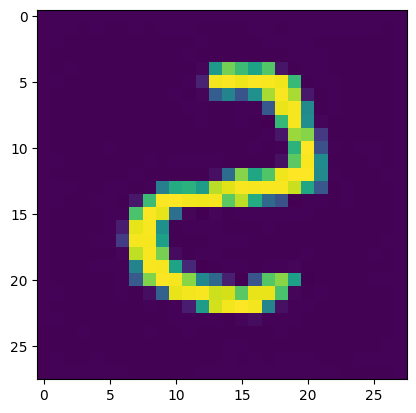

Regularization Term    tensor(-0.2194, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1442, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


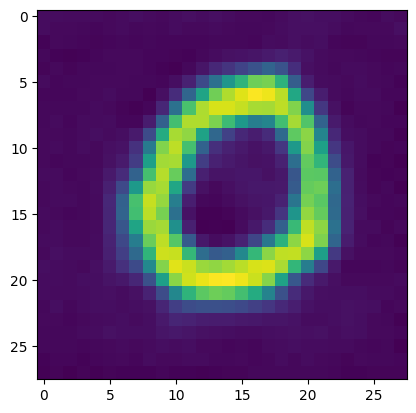

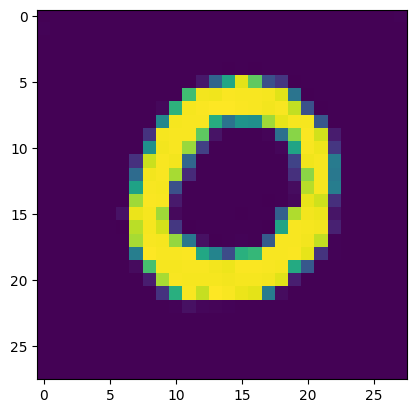

Regularization Term    tensor(-0.2081, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1806, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0968, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


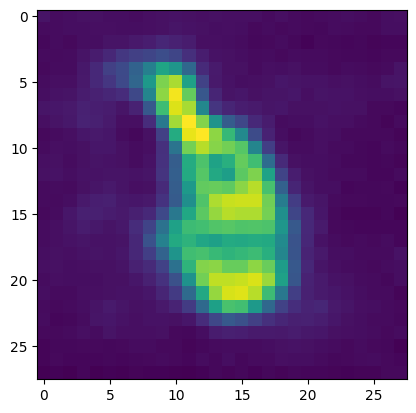

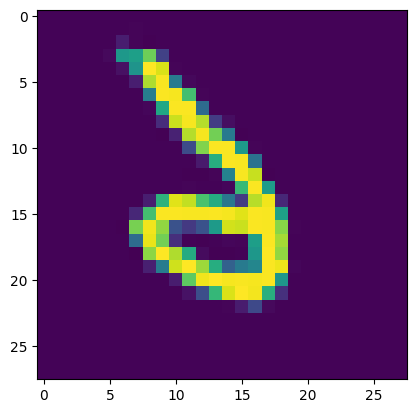

Regularization Term    tensor(-0.2021, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1587, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


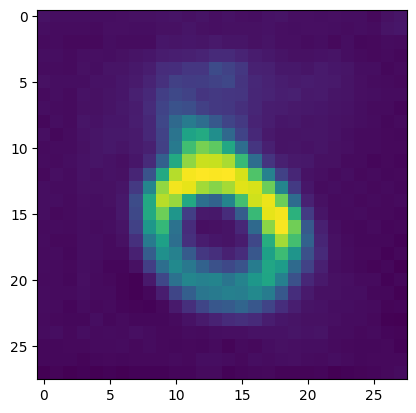

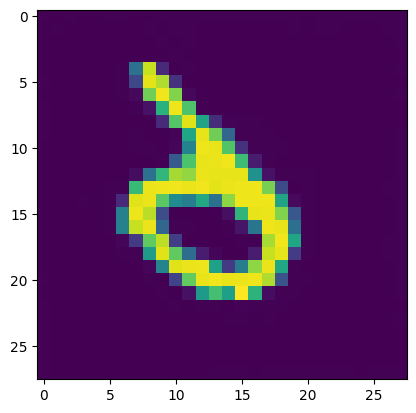

Regularization Term    tensor(-0.2108, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.5630, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1856, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


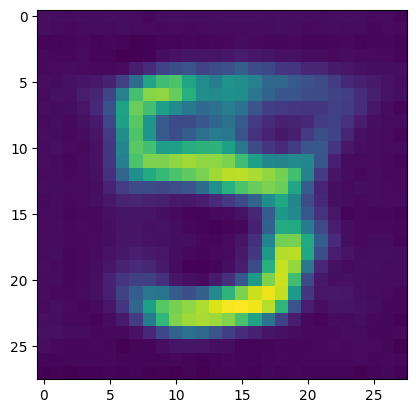

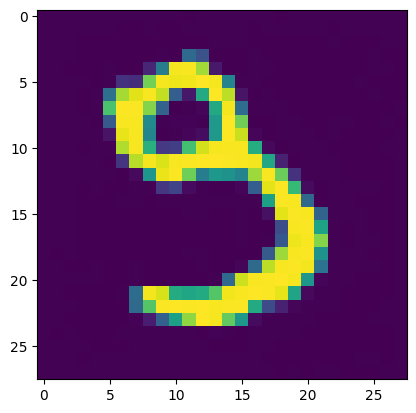

Regularization Term    tensor(-0.2102, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 4   Loss: tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1510, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


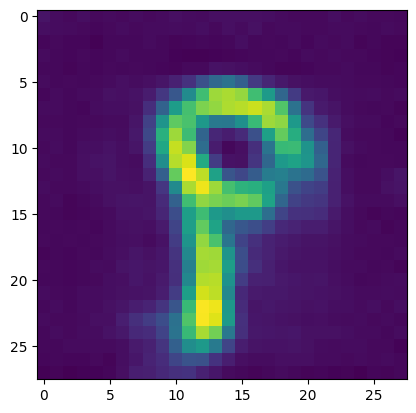

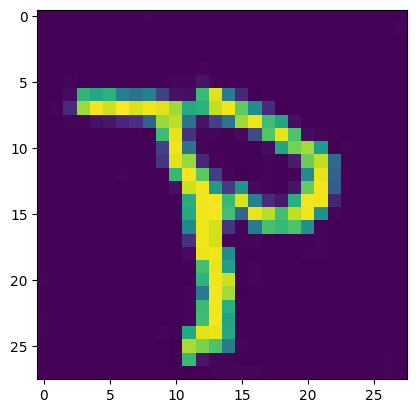

Regularization Term    tensor(-0.1999, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1549, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


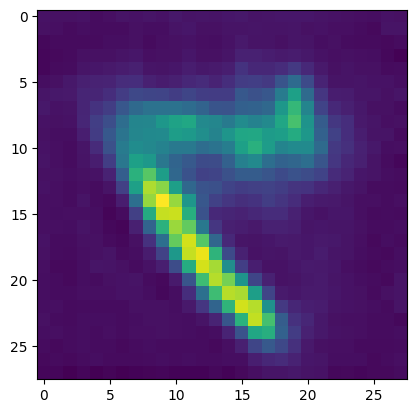

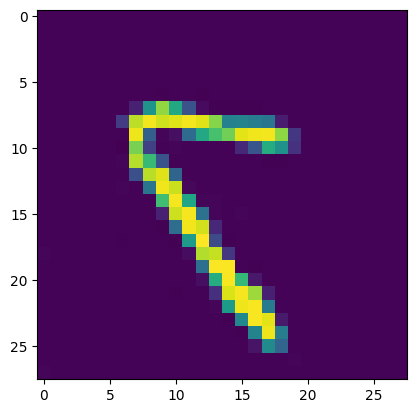

Regularization Term    tensor(-0.1897, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1532, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


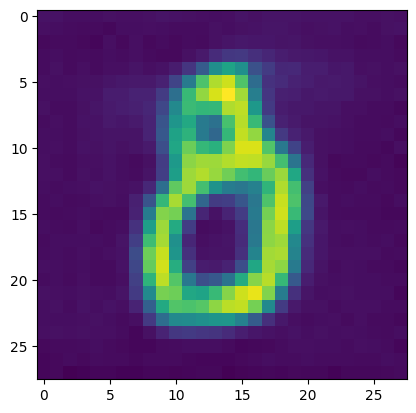

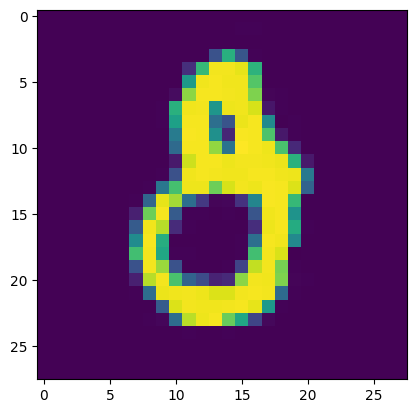

Regularization Term    tensor(-0.2129, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1579, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


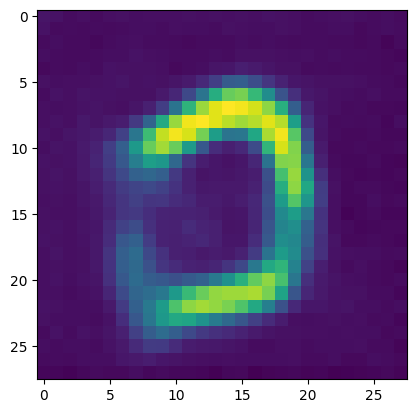

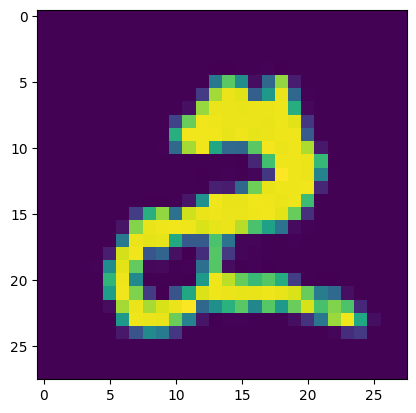

Regularization Term    tensor(-0.1985, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1648, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


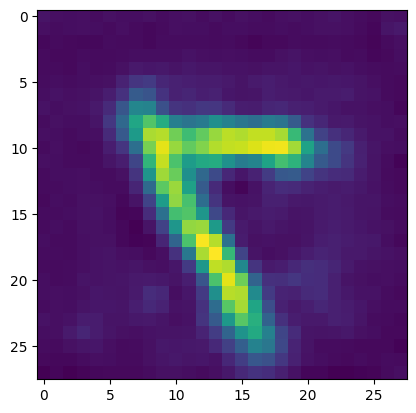

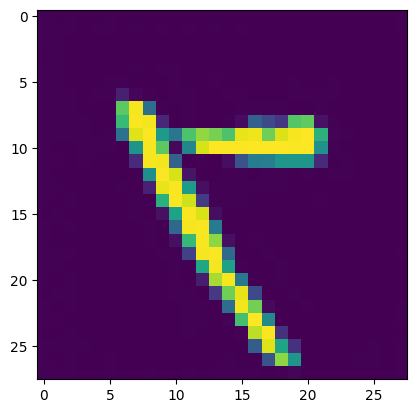

Regularization Term    tensor(-0.2045, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1477, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


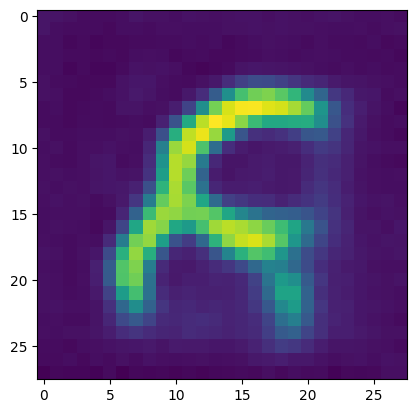

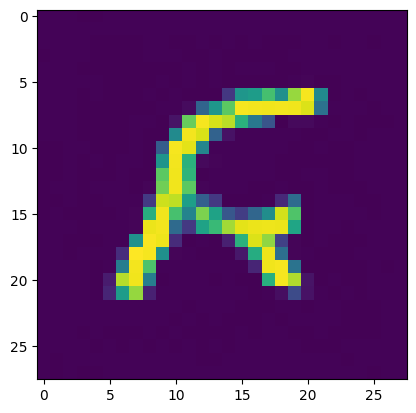

Regularization Term    tensor(-0.2022, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1476, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


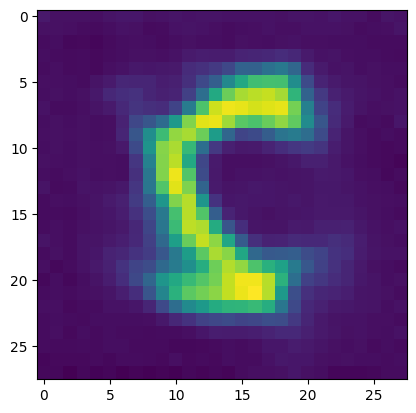

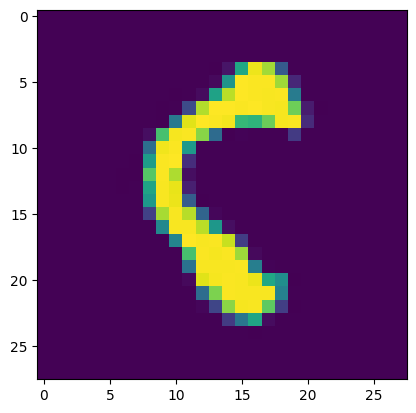

Regularization Term    tensor(-0.1965, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1450, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


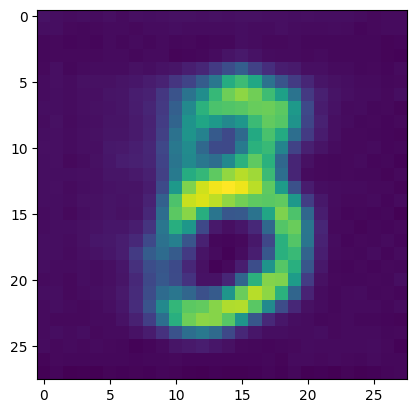

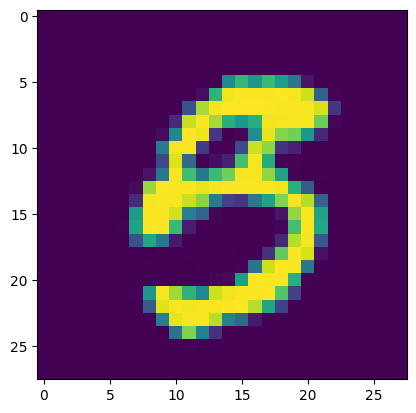

Regularization Term    tensor(-0.1977, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1645, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


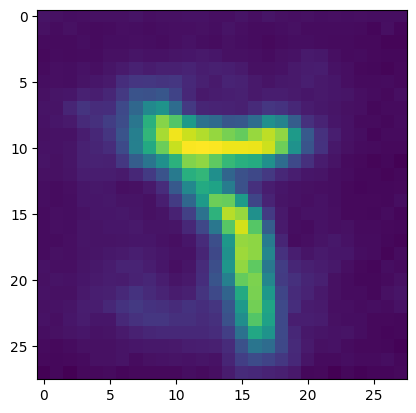

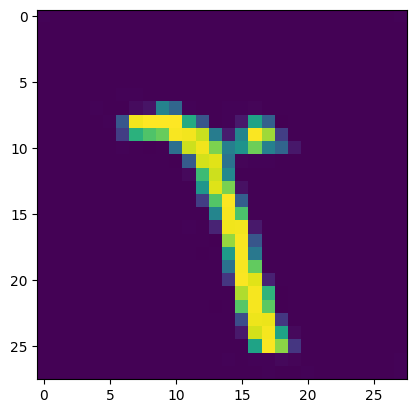

Regularization Term    tensor(-0.1951, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1456, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


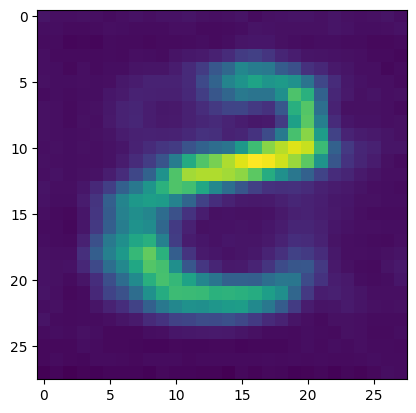

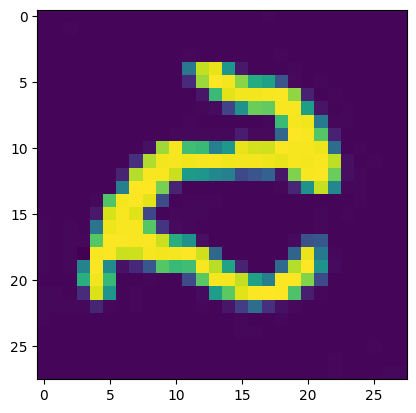

Regularization Term    tensor(-0.2068, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 5   Loss: tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1614, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


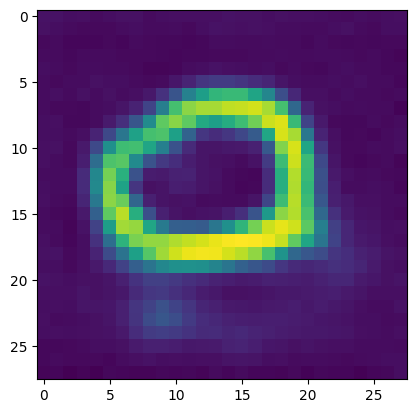

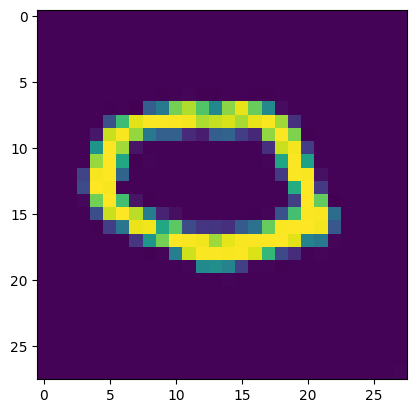

Regularization Term    tensor(-0.2057, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1536, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


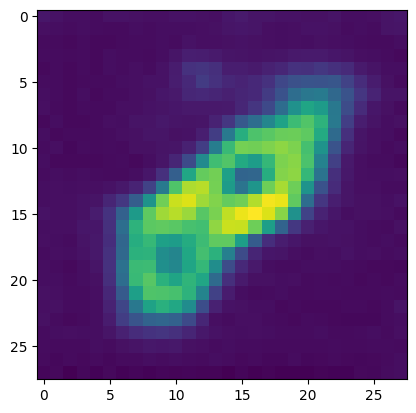

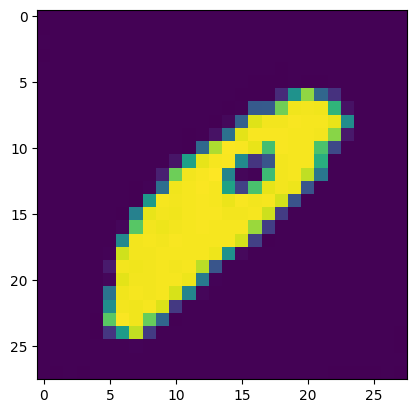

Regularization Term    tensor(-0.2057, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1609, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


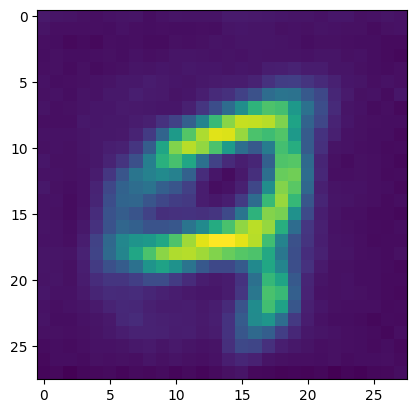

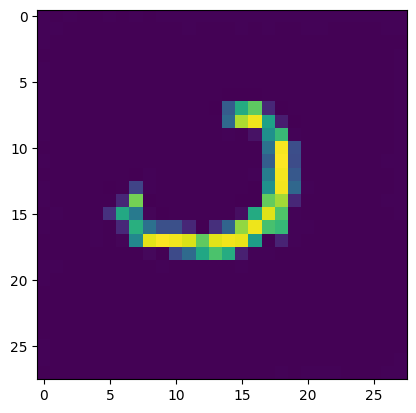

Regularization Term    tensor(-0.1993, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1474, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


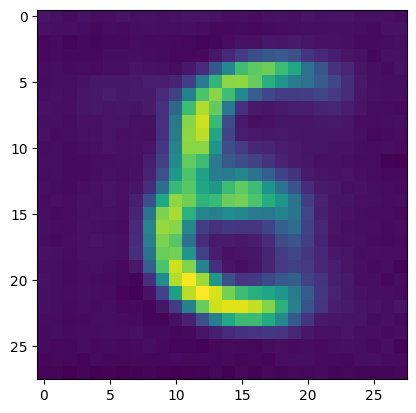

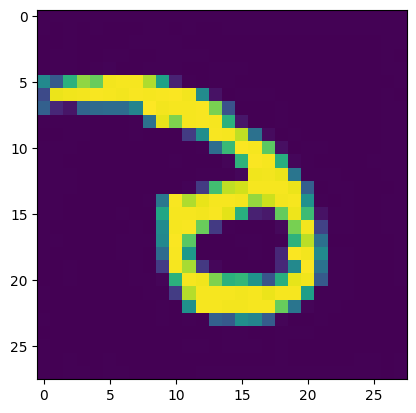

Regularization Term    tensor(-0.2091, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.4720, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1491, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


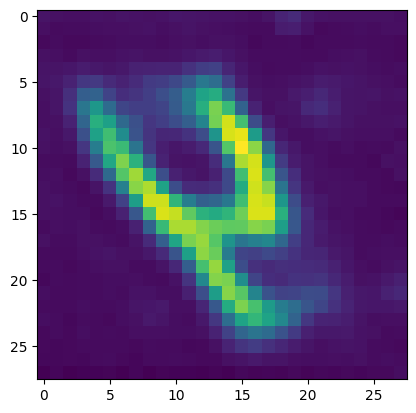

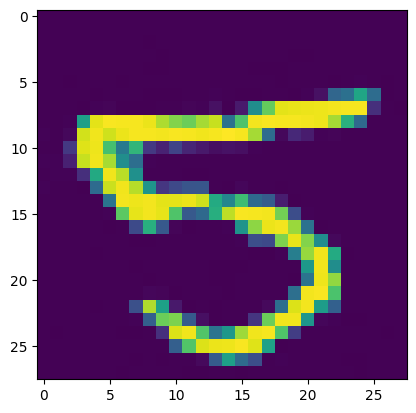

Regularization Term    tensor(-0.1996, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1583, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


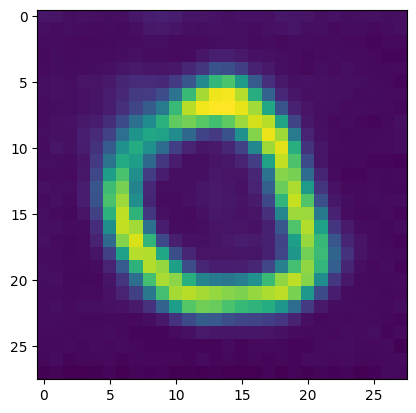

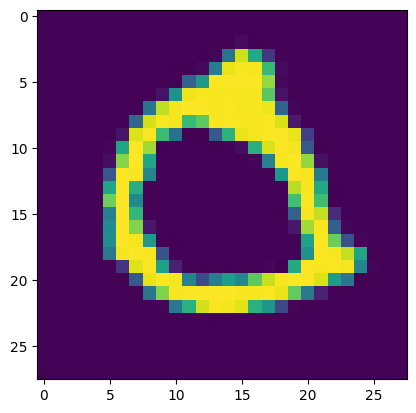

Regularization Term    tensor(-0.2158, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1454, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


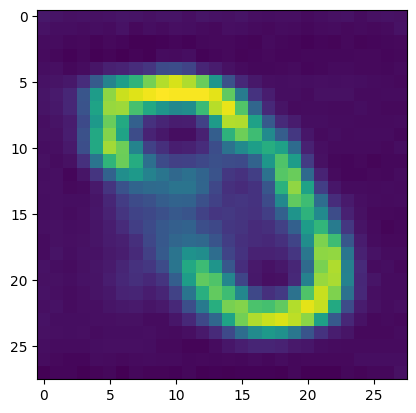

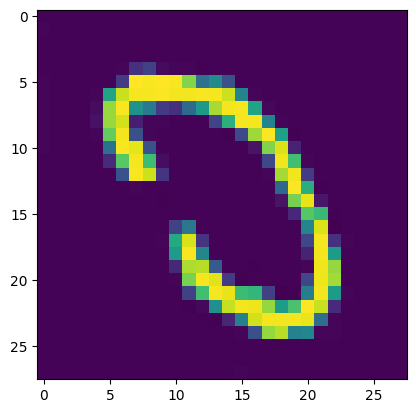

Regularization Term    tensor(-0.2096, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1623, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


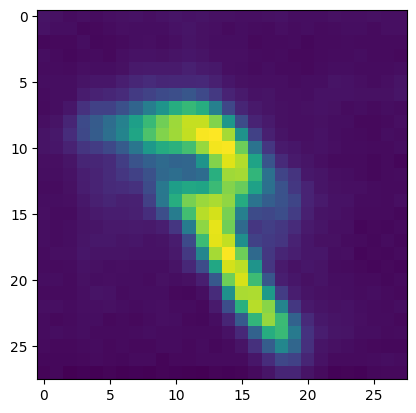

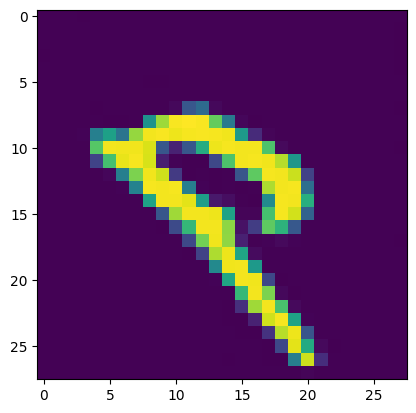

Regularization Term    tensor(-0.2078, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1625, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


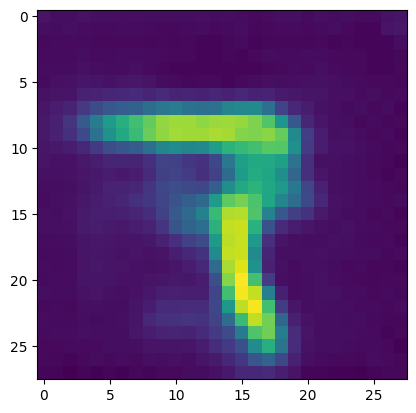

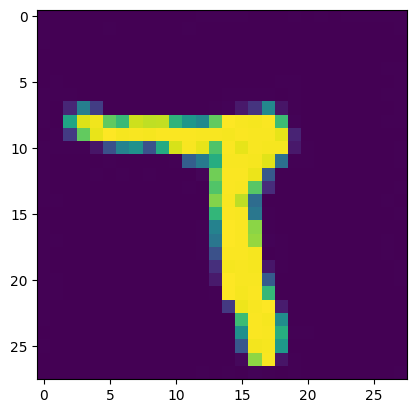

Regularization Term    tensor(-0.2229, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1579, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


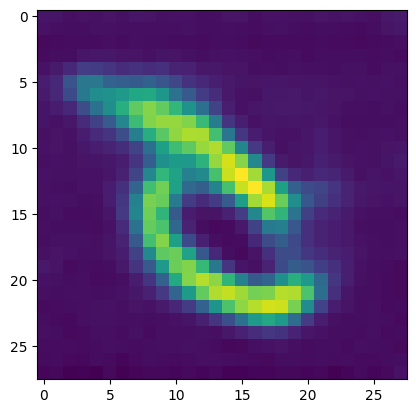

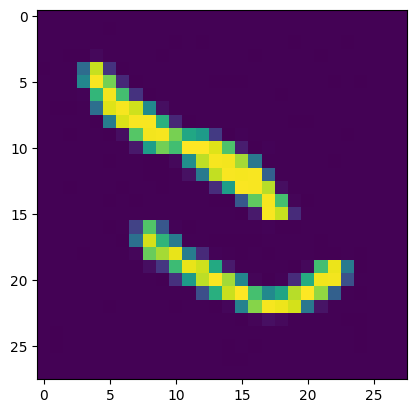

Regularization Term    tensor(-0.2171, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 6   Loss: tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1497, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


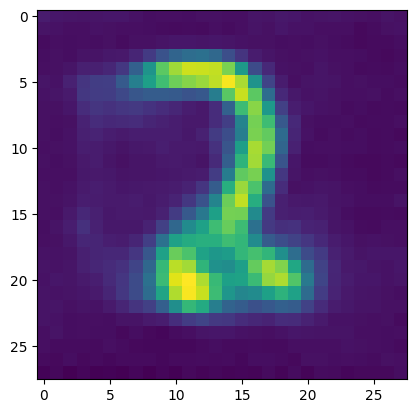

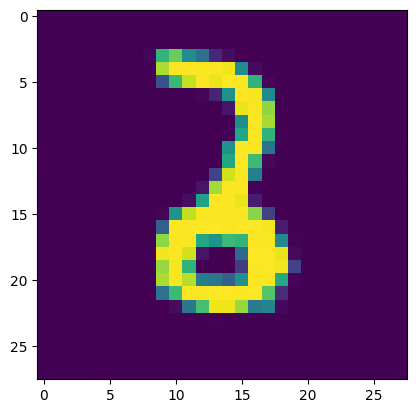

Regularization Term    tensor(-0.2169, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1651, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


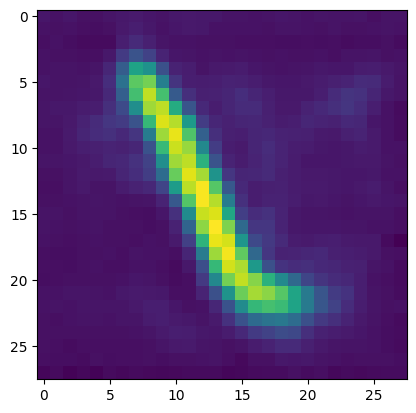

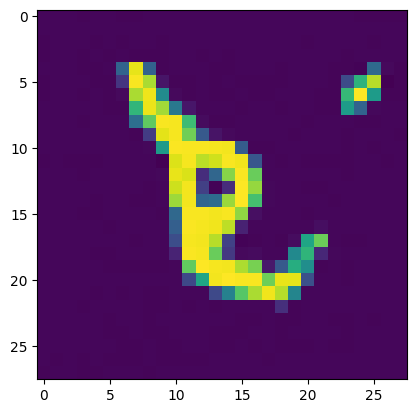

Regularization Term    tensor(-0.2138, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1606, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


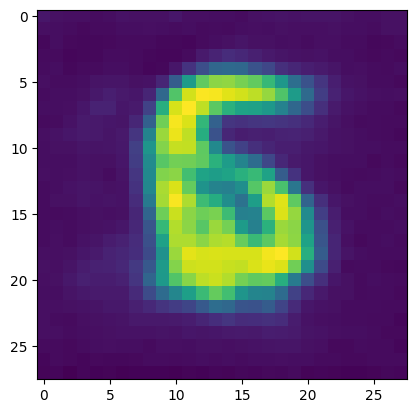

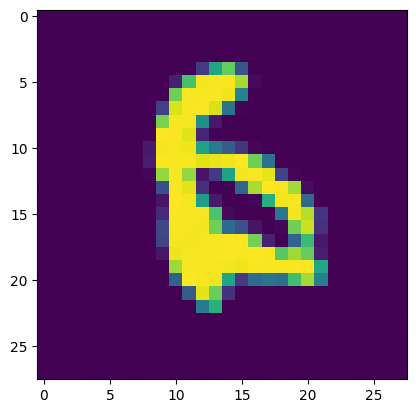

Regularization Term    tensor(-0.2270, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1454, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


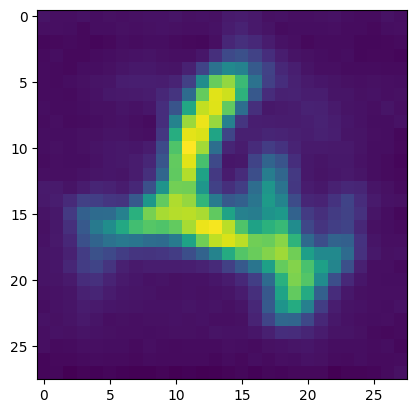

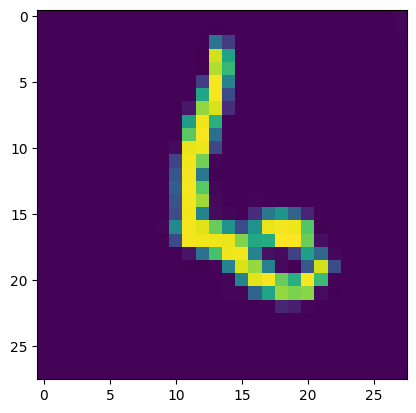

Regularization Term    tensor(-0.2255, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1620, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


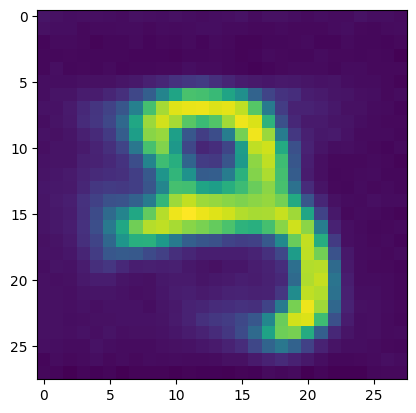

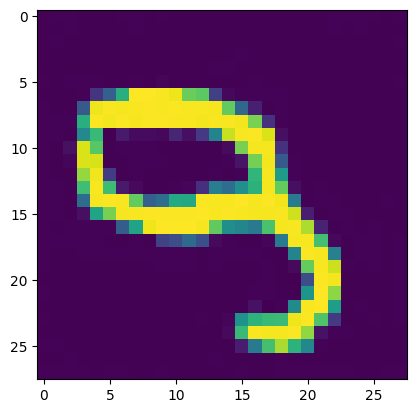

Regularization Term    tensor(-0.2247, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1575, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


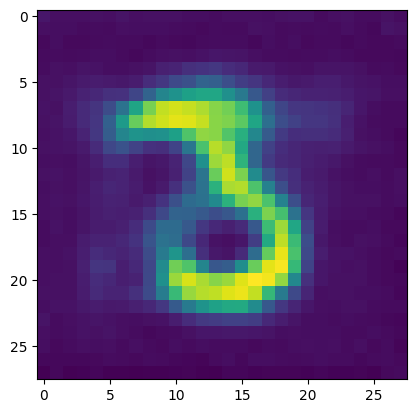

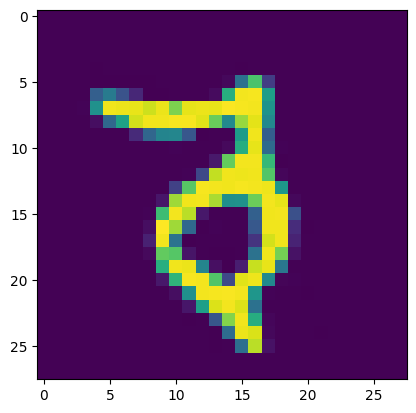

Regularization Term    tensor(-0.2215, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1422, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


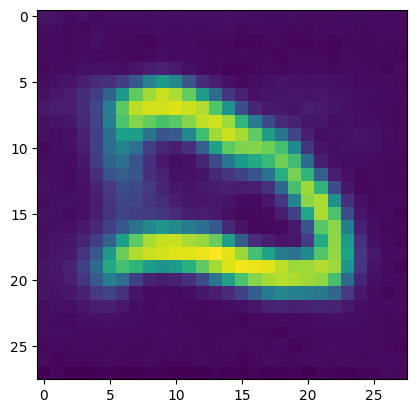

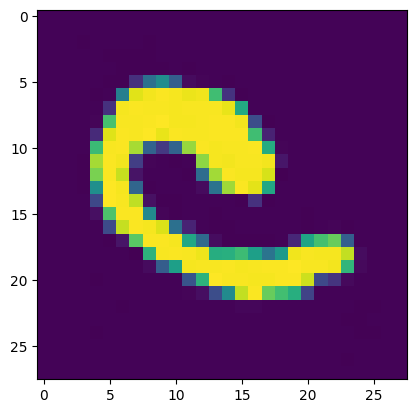

Regularization Term    tensor(-0.2176, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1514, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


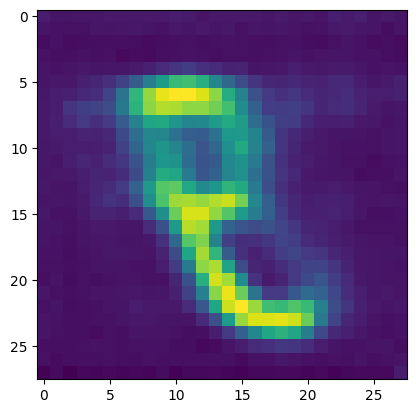

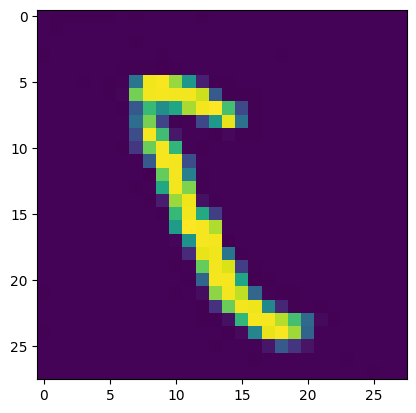

Regularization Term    tensor(-0.2230, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1423, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


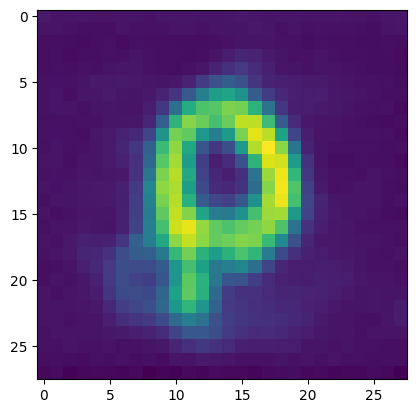

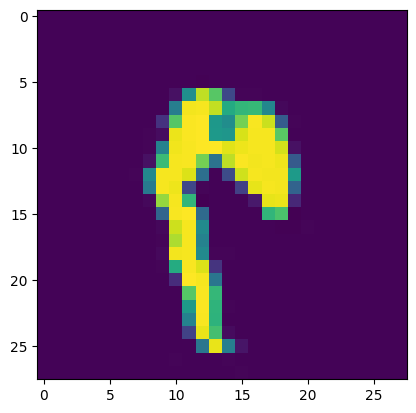

Regularization Term    tensor(-0.2201, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1486, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


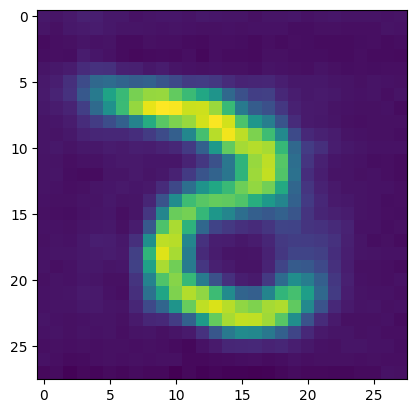

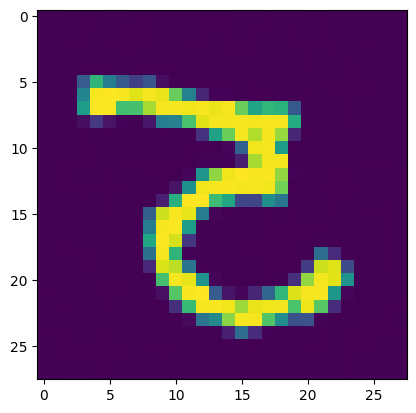

Regularization Term    tensor(-0.2204, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 7   Loss: tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1506, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


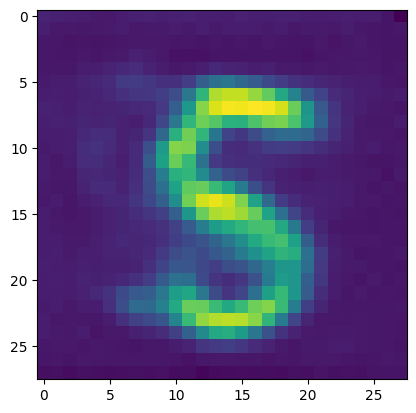

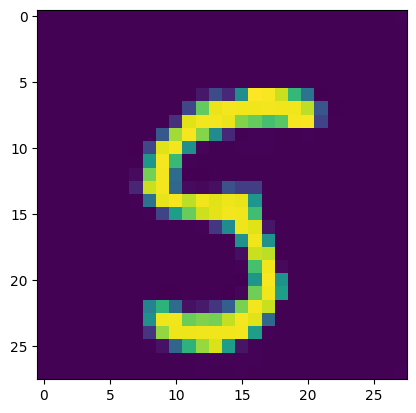

Regularization Term    tensor(-0.2145, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1378, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


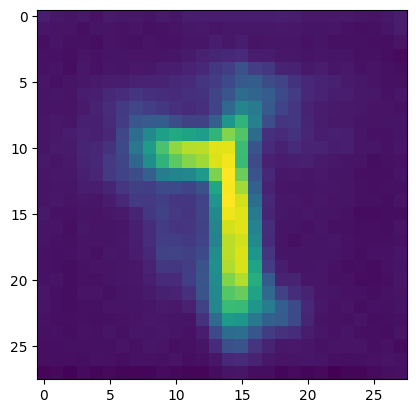

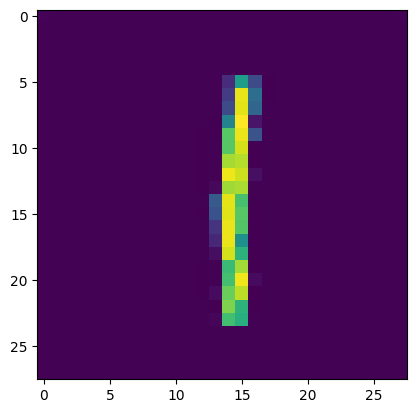

Regularization Term    tensor(-0.2096, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1406, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


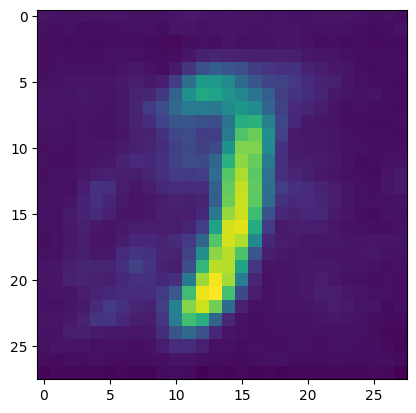

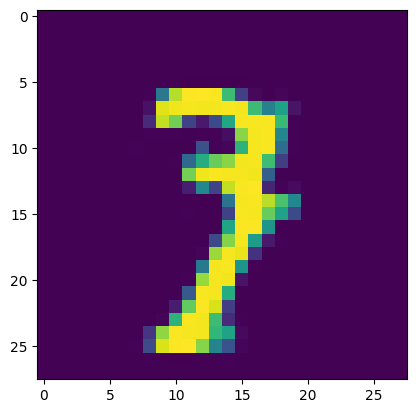

Regularization Term    tensor(-0.2146, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1364, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


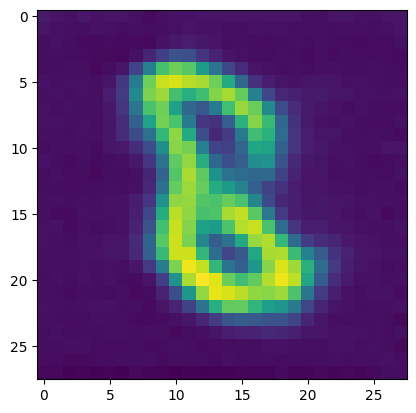

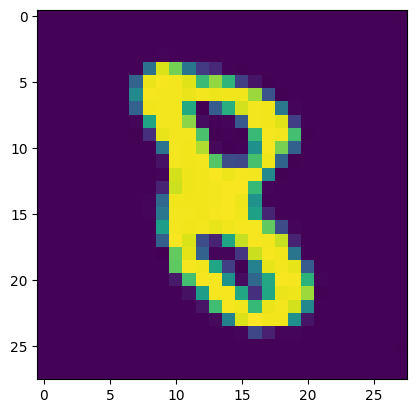

Regularization Term    tensor(-0.2193, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1525, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


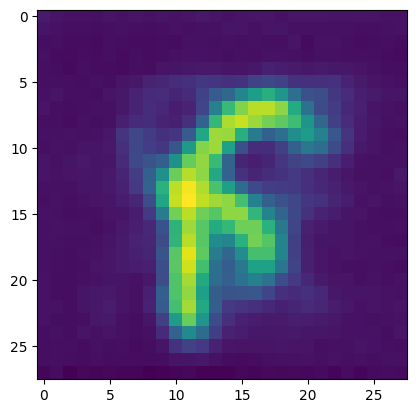

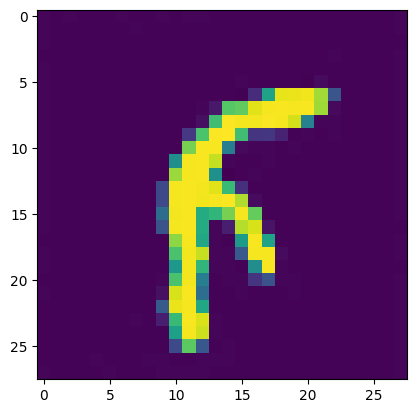

Regularization Term    tensor(-0.2146, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1530, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


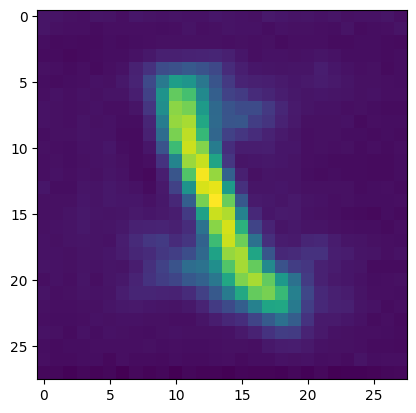

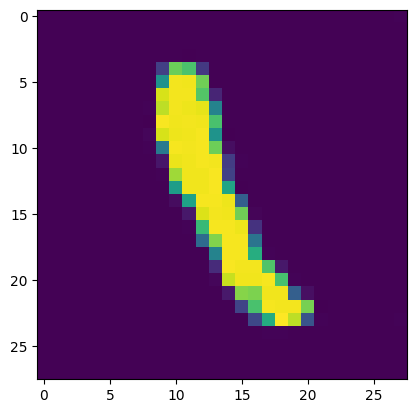

Regularization Term    tensor(-0.2045, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1468, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


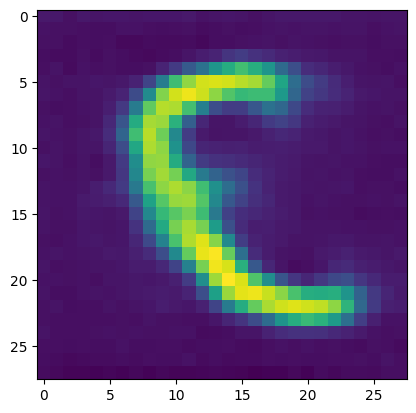

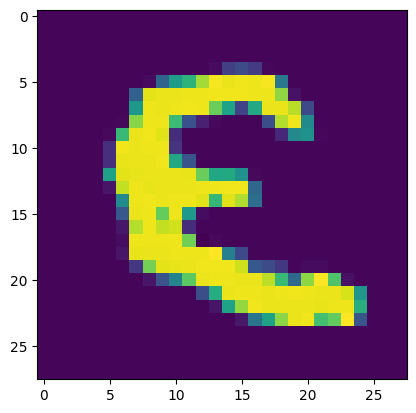

Regularization Term    tensor(-0.1966, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1469, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


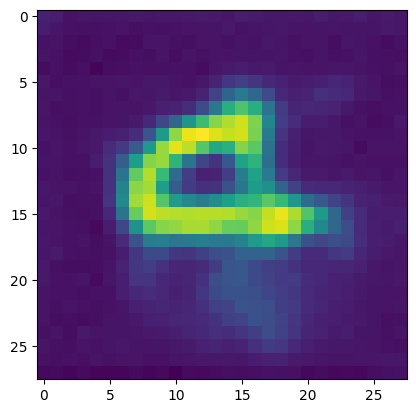

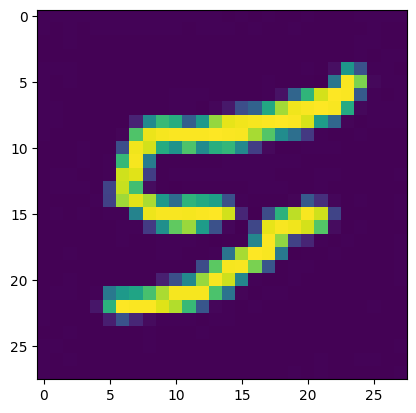

Regularization Term    tensor(-0.2130, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1666, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


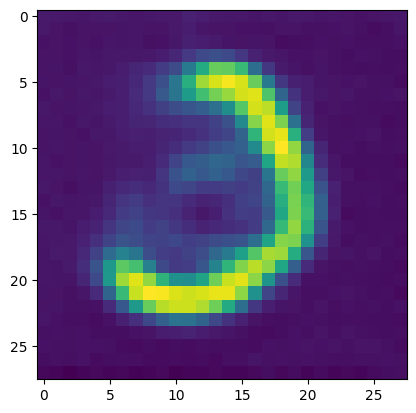

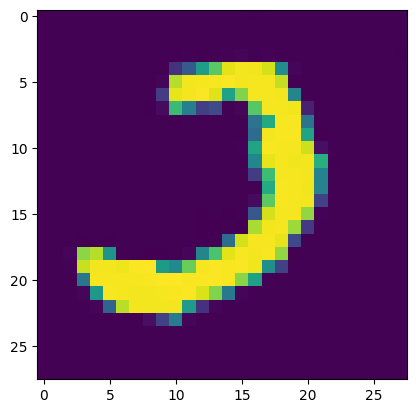

Regularization Term    tensor(-0.2089, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.4635, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1457, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


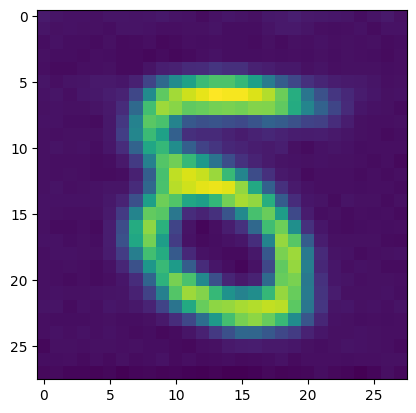

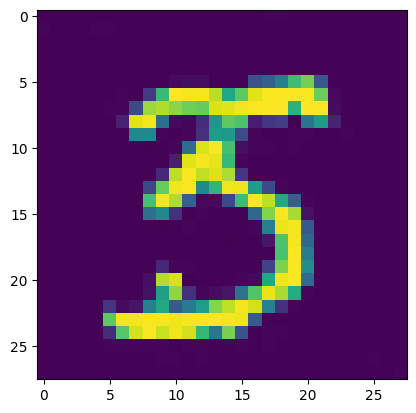

Regularization Term    tensor(-0.1970, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 8   Loss: tensor(0.4697, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1497, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


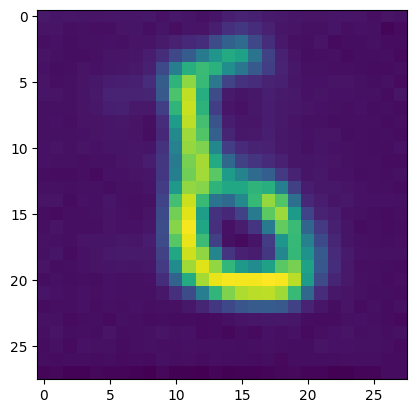

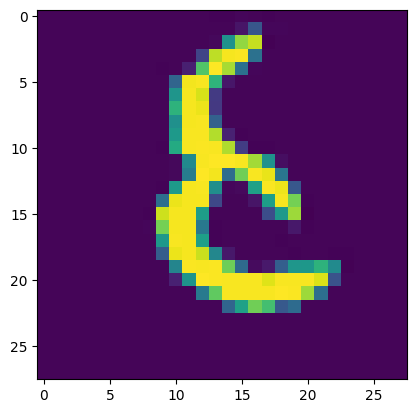

Regularization Term    tensor(-0.2134, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1441, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


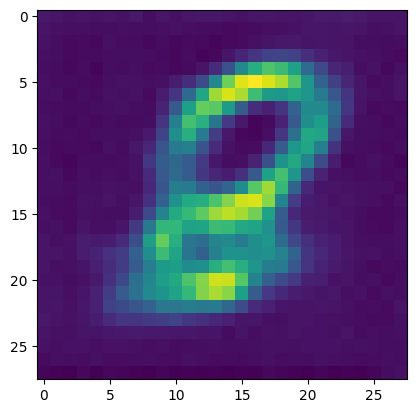

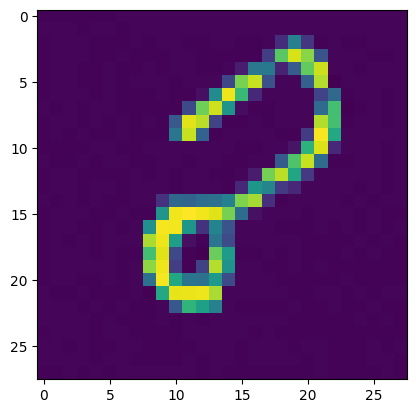

Regularization Term    tensor(-0.1977, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1479, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


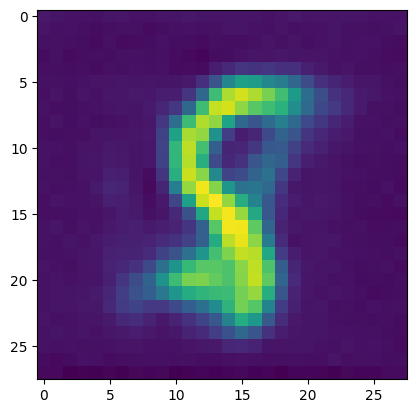

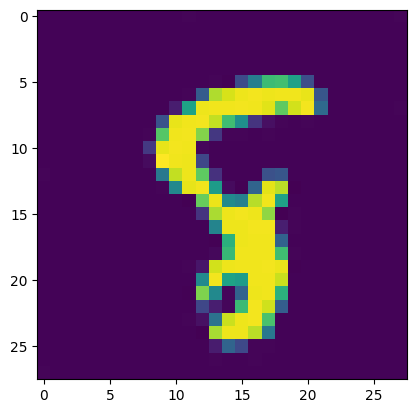

Regularization Term    tensor(-0.2118, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1594, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


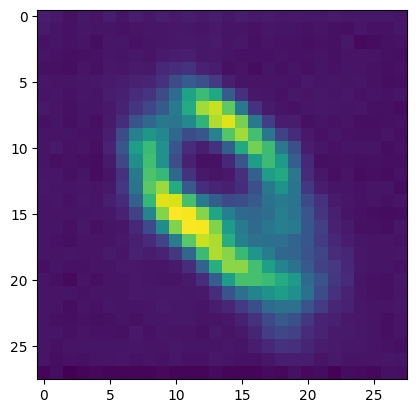

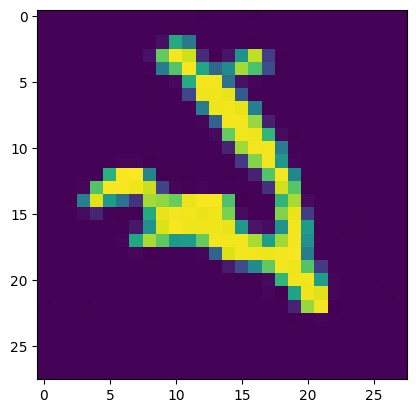

Regularization Term    tensor(-0.2163, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1440, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


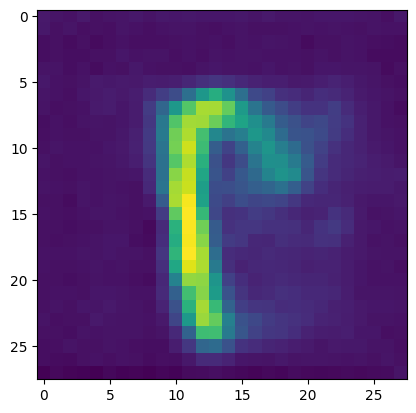

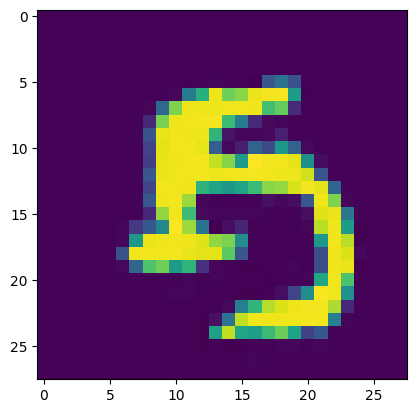

Regularization Term    tensor(-0.2191, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4590, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1433, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


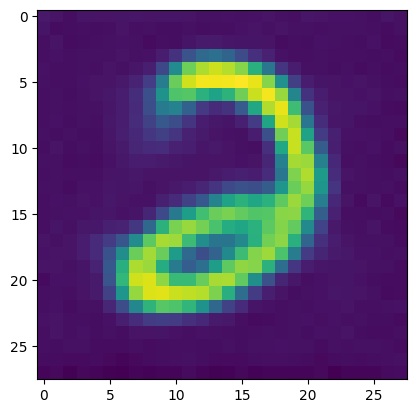

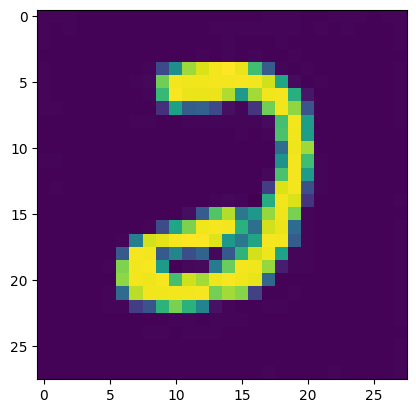

Regularization Term    tensor(-0.2246, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1555, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


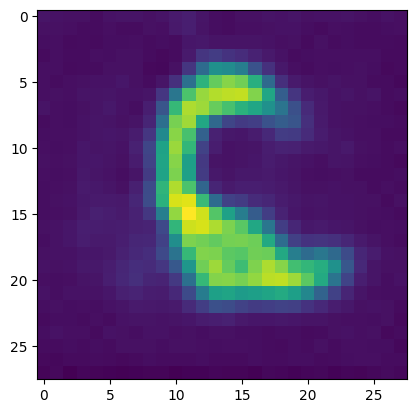

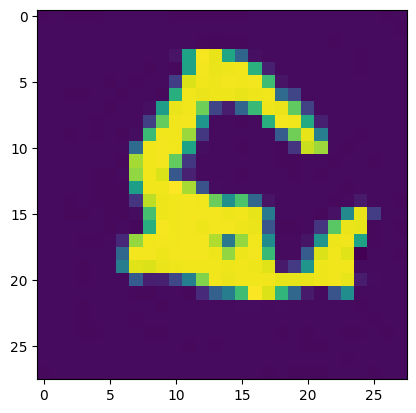

Regularization Term    tensor(-0.2278, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1490, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


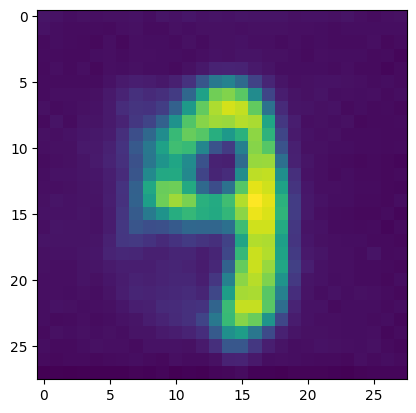

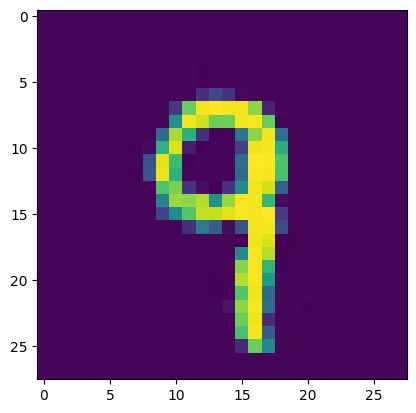

Regularization Term    tensor(-0.2268, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1459, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


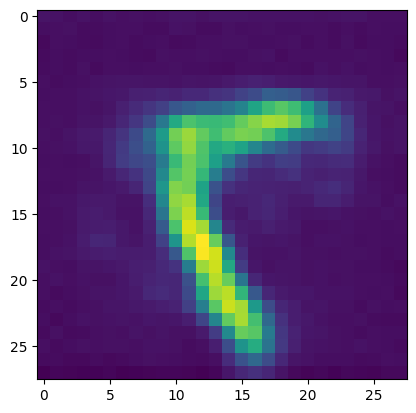

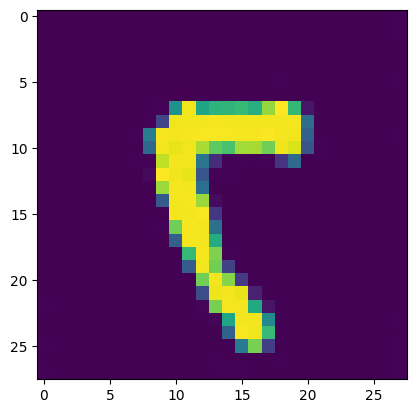

Regularization Term    tensor(-0.2326, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1374, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


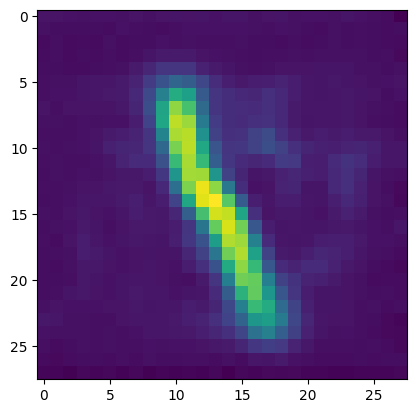

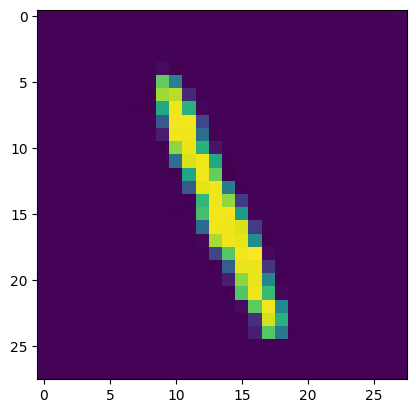

Regularization Term    tensor(-0.2234, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 9   Loss: tensor(0.4317, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1333, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
torch.cuda.empty_cache()
epochs = 10

student_optimizer = Adam(student_model.parameters(), lr=1e-4)
#scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=1, factor=0.05)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 10:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(teacher_timesteps*2-1, teacher_timesteps*2, (batch_size,), device=device).long()
      t_teacher = torch.randint(0, teacher_timesteps*2, (batch_size,), device=device).long()

      noise = torch.randn_like(batch)
      x_noisy_student = q_sample(x_start=batch, t=t_student, noise=noise)

      student_data = sample( student_model, x_noisy_student[0] , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_teacher[0] , image_size, timestep=teacher_timesteps,  batch_size=batch_size, channels=channels)

      #show the results
      random_index = random.randint(0, 63)
      image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
      image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
      plt.imshow(image_data1)
      plt.show()
      plt.imshow(image_data3)
      plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])

      #regularization term useful to avoid mode collapse
      diversity_loss = -torch.mean(torch.abs(student_data[-1]  - student_data[-1].mean(dim=0)))
      print("Regularization Term    " + str(diversity_loss))

      loss = l*distill_loss + loss_fake #+  0.5 * diversity_loss
      losses.append(loss)

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    #scheduler_student.step(loss)

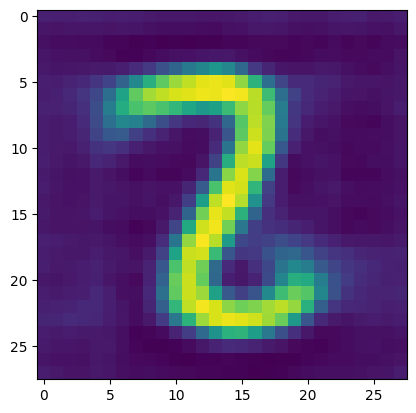

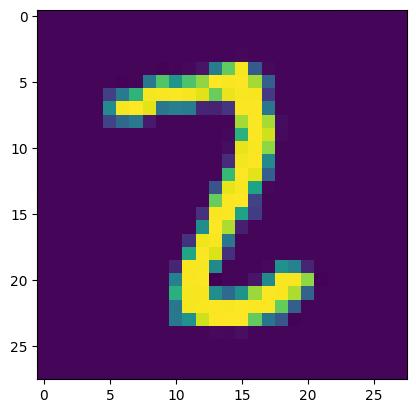

Regularization Term    tensor(-0.3143, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2358, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


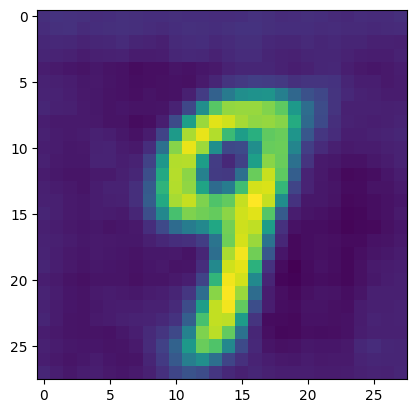

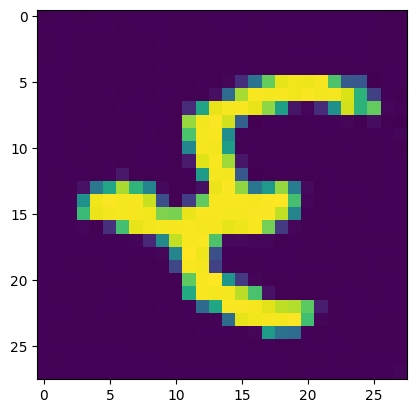

Regularization Term    tensor(-0.2919, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2676, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


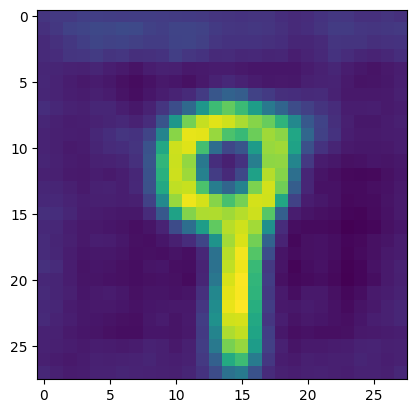

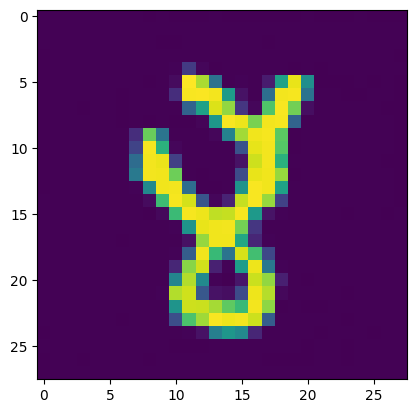

Regularization Term    tensor(-0.2910, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2436, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


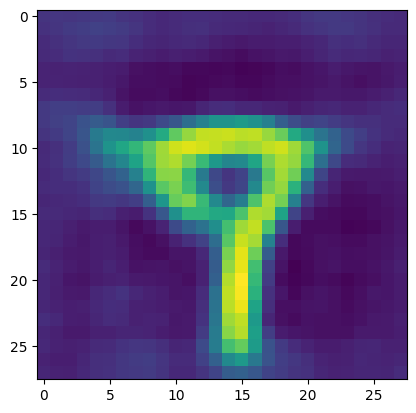

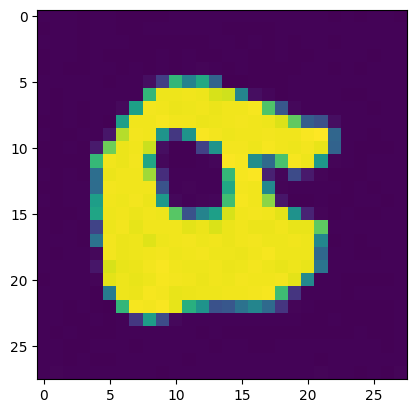

Regularization Term    tensor(-0.3055, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2677, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


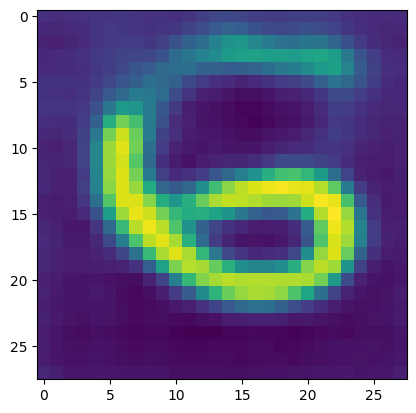

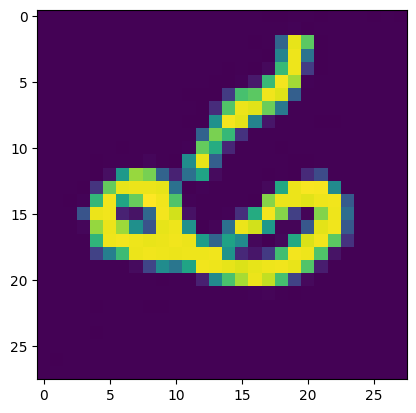

Regularization Term    tensor(-0.3604, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3261, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


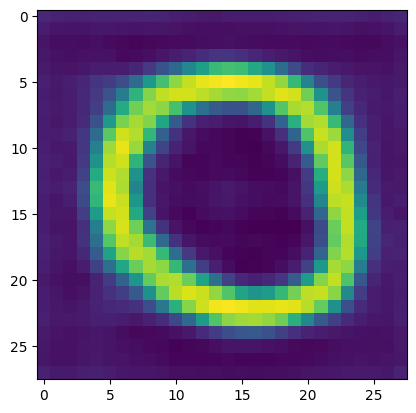

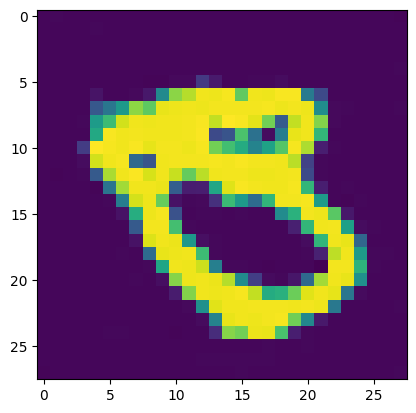

Regularization Term    tensor(-0.3787, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2838, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


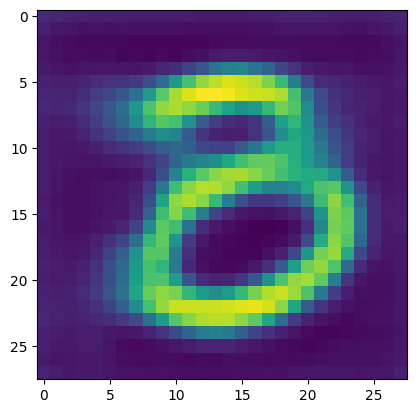

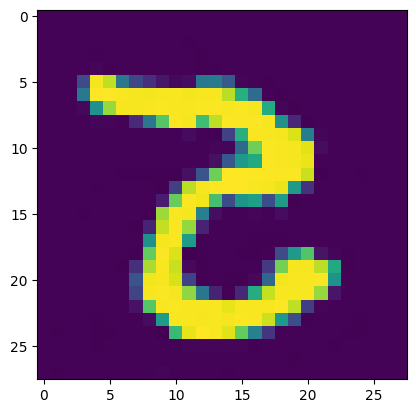

Regularization Term    tensor(-0.3909, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3009, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


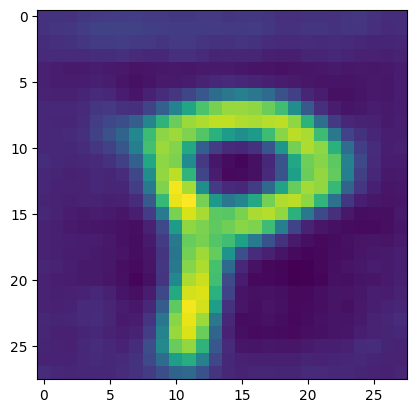

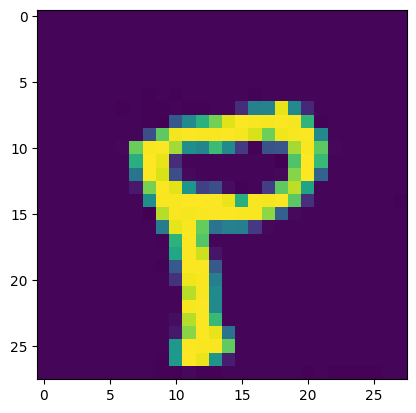

Regularization Term    tensor(-0.3960, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3250, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


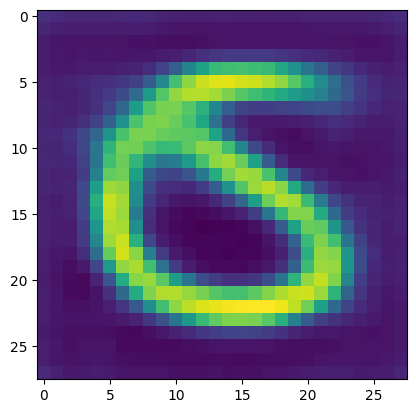

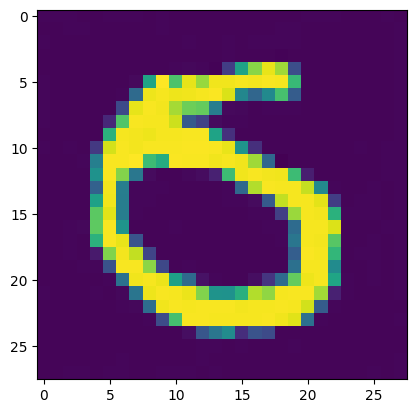

Regularization Term    tensor(-0.3970, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3397, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


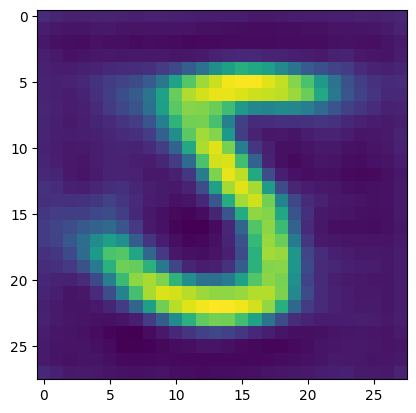

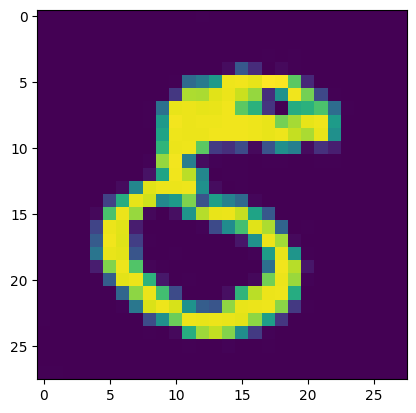

Regularization Term    tensor(-0.3953, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3025, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


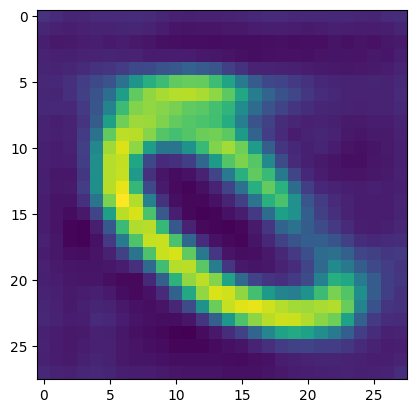

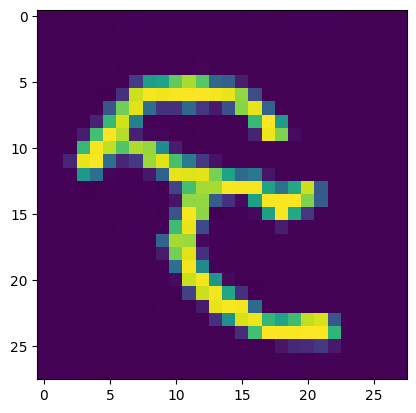

Regularization Term    tensor(-0.4025, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3179, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


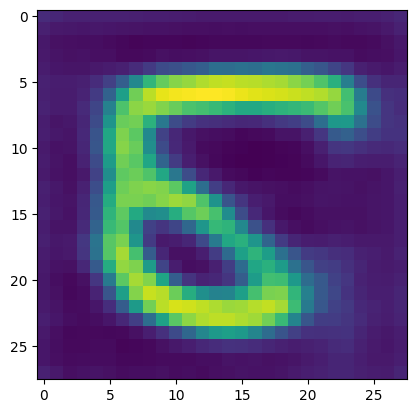

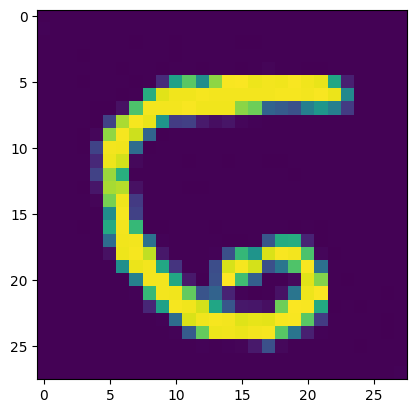

Regularization Term    tensor(-0.3914, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3024, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


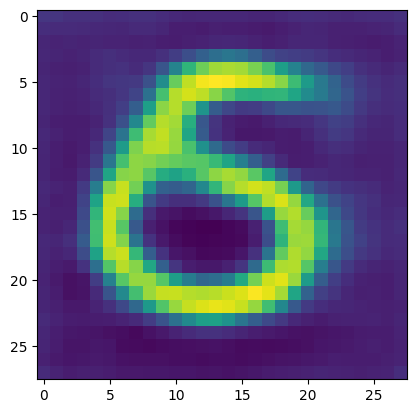

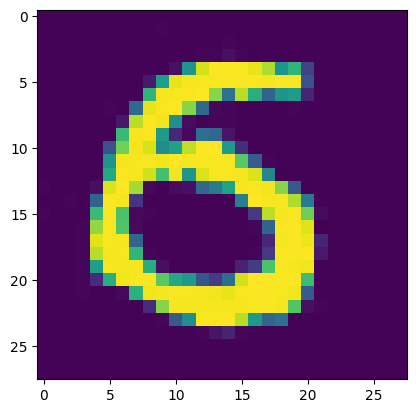

Regularization Term    tensor(-0.3922, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3259, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


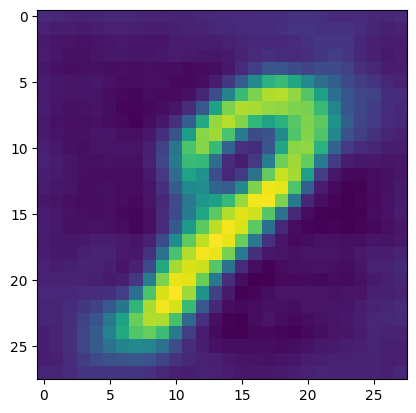

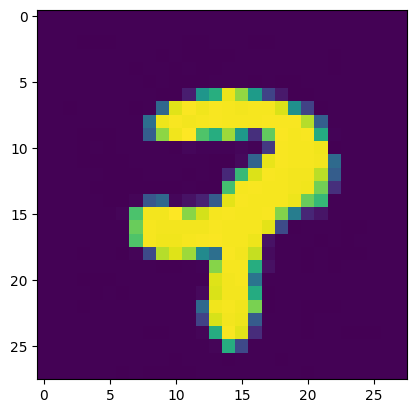

Regularization Term    tensor(-0.3986, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2926, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


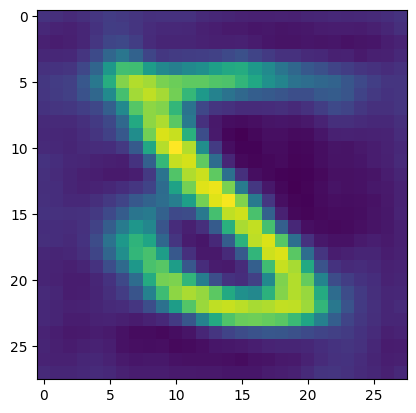

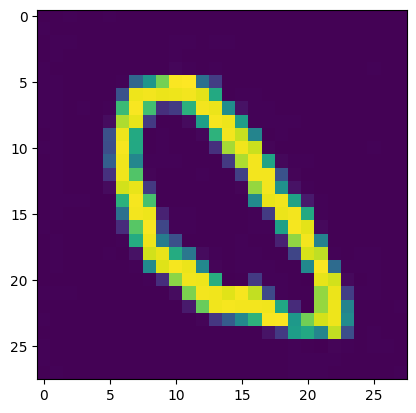

Regularization Term    tensor(-0.3915, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.1948, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3487, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


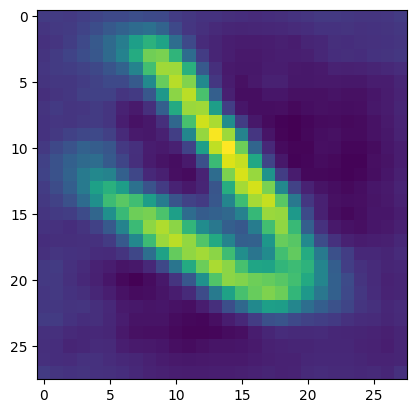

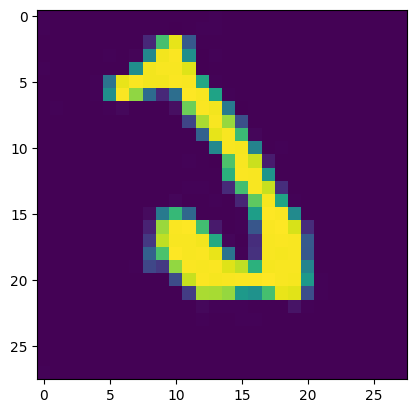

Regularization Term    tensor(-0.3965, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3165, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


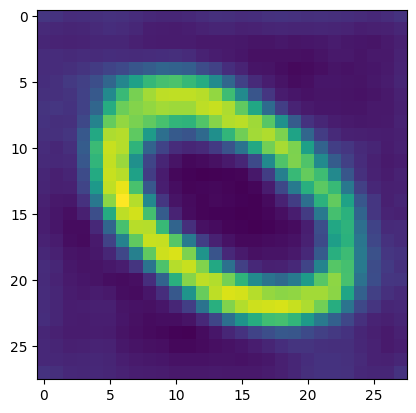

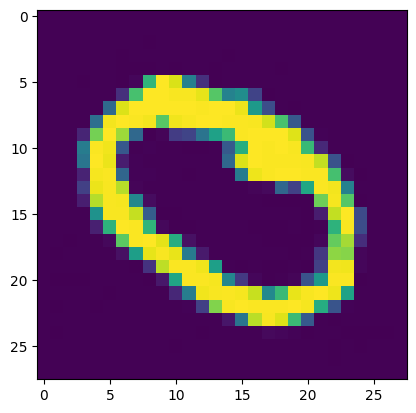

Regularization Term    tensor(-0.3863, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3250, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


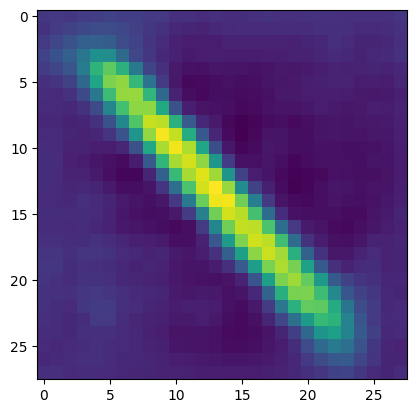

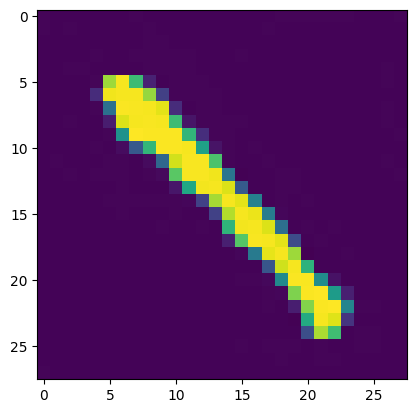

Regularization Term    tensor(-0.3899, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3170, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


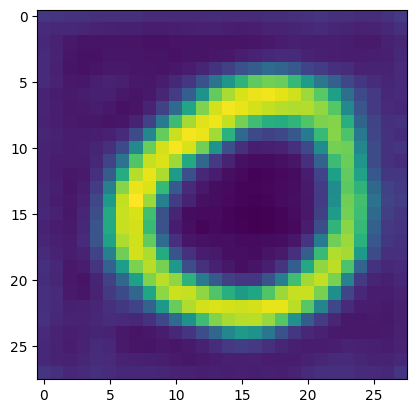

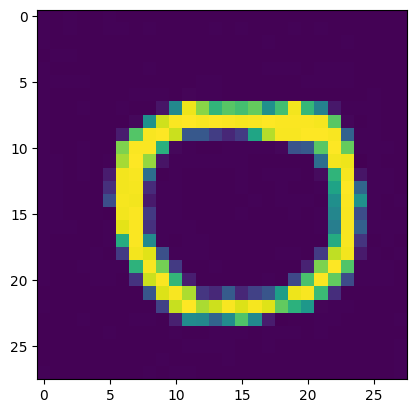

Regularization Term    tensor(-0.3806, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3045, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


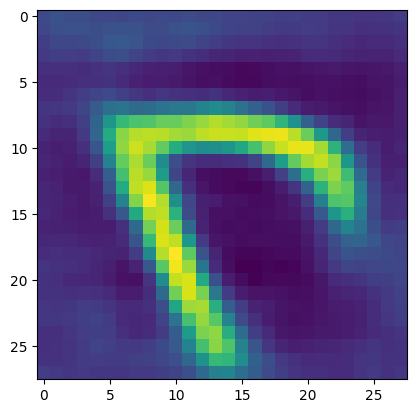

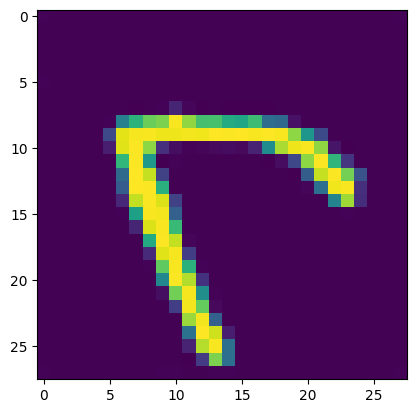

Regularization Term    tensor(-0.3920, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3489, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


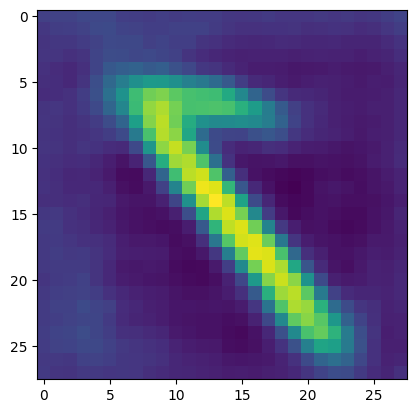

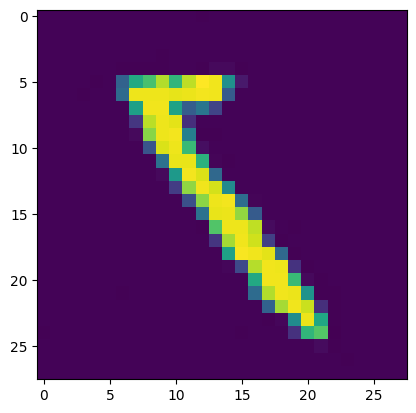

Regularization Term    tensor(-0.3650, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2994, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


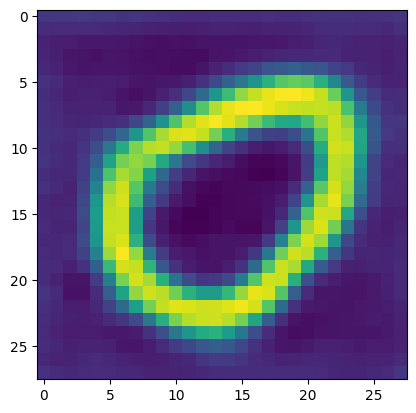

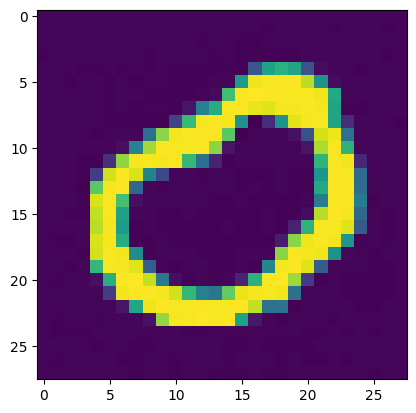

Regularization Term    tensor(-0.3694, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3219, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


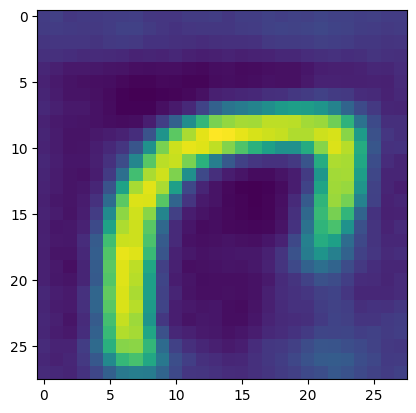

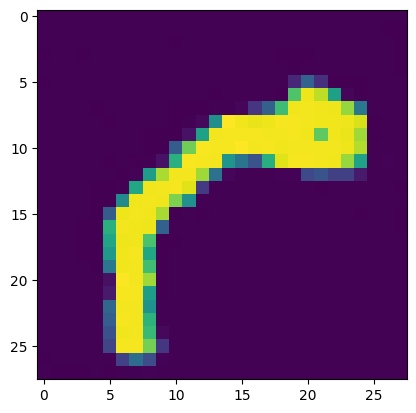

Regularization Term    tensor(-0.3645, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2797, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


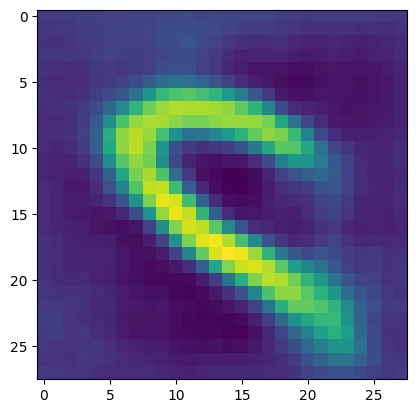

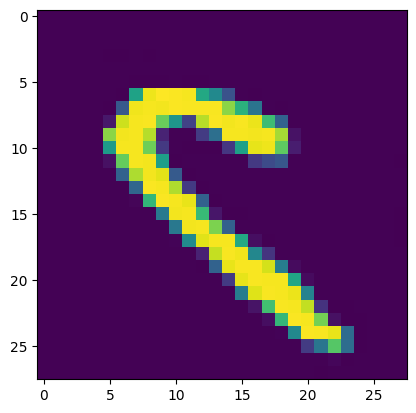

Regularization Term    tensor(-0.3695, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2853, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


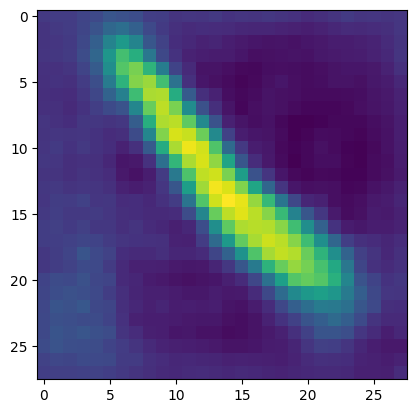

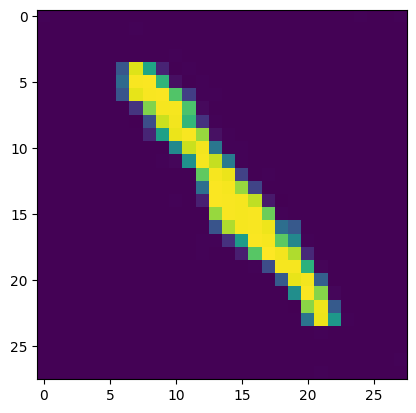

Regularization Term    tensor(-0.3590, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3003, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


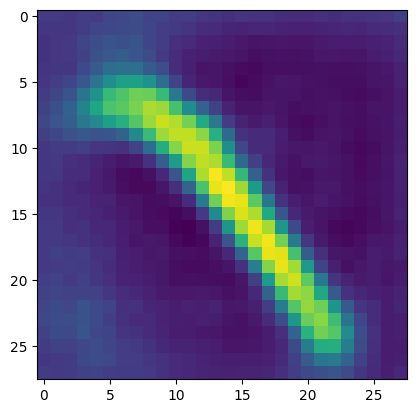

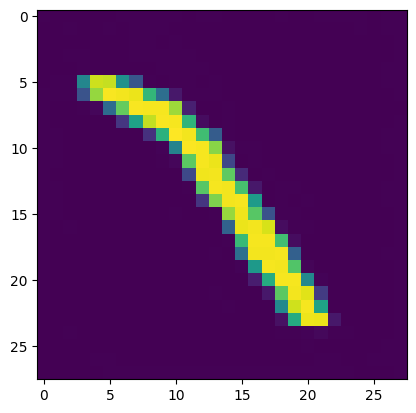

Regularization Term    tensor(-0.3552, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(-0.0301, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2326, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


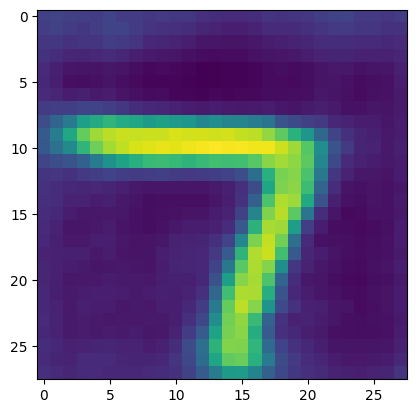

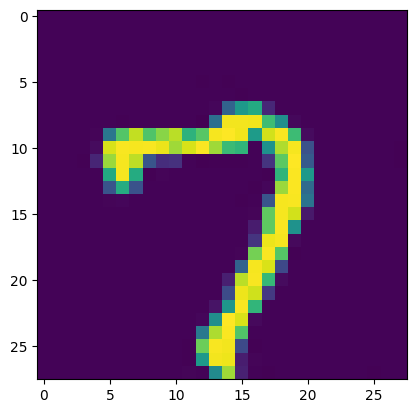

Regularization Term    tensor(-0.3501, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2843, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


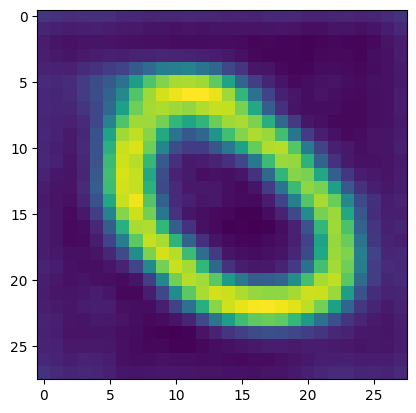

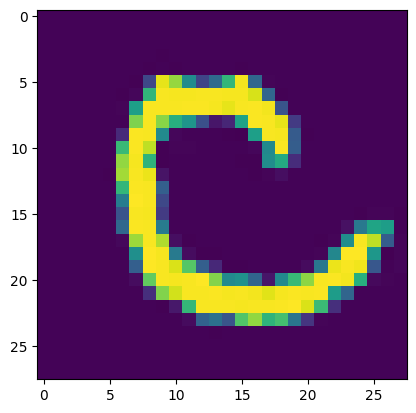

Regularization Term    tensor(-0.3626, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3102, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


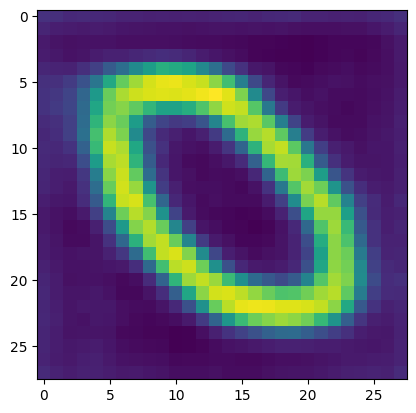

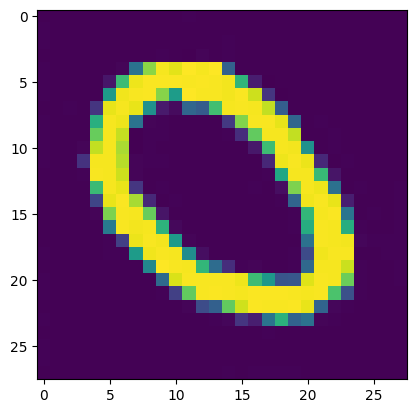

Regularization Term    tensor(-0.3863, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2887, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


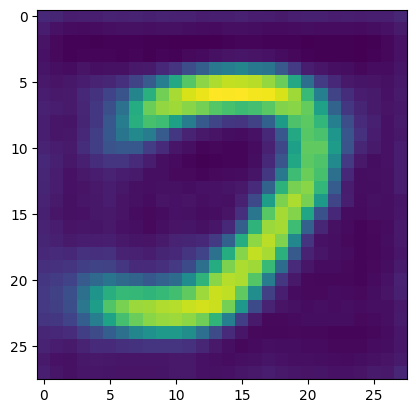

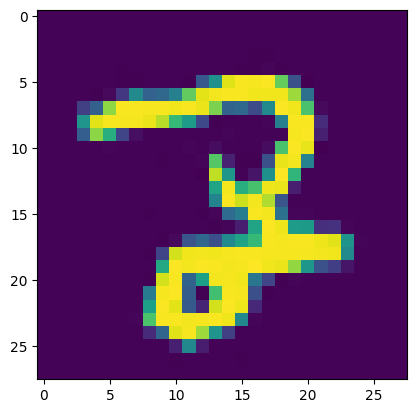

Regularization Term    tensor(-0.3634, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2796, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
torch.cuda.empty_cache()
epochs = 3

student_optimizer = Adam(student_model.parameters(), lr=1e-4)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=1, factor=0.05)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 10:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_teacher = torch.randint(0, teacher_timesteps*2, (batch_size,), device=device).long()

      noise = torch.randn_like(batch)

      input= torch.rand([64,1,28,28]).to(device)

      student_data = sample( student_model,  input , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_teacher[0] , image_size, timestep=teacher_timesteps,  batch_size=batch_size, channels=channels)

      #show the results
      random_index = random.randint(0, 63)
      image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
      image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
      plt.imshow(image_data1)
      plt.show()
      plt.imshow(image_data3)
      plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])

      #regularization term useful to avoid mode collapse
      diversity_loss = -torch.mean(torch.abs(student_data[-1]  - student_data[-1].mean(dim=0)))
      print("Regularization Term    " + str(diversity_loss))

      loss = l*distill_loss + loss_fake +  2 * diversity_loss
      losses.append(loss)

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)

In [ ]:
#discriminator_path = '/content/drive/MyDrive/discriminator_model_last_version.pth'
#student_path = '/content/drive/MyDrive/student_model_last_version.pth'

# Salva il modello
#torch.save(discriminator_model.state_dict(), discriminator_path)
#torch.save(student_model.state_dict(), student_path)

In [ ]:
#path = '/content/drive/MyDrive/diffusion_model_last_version.pth'

# Salva il modello
#torch.save(teacher_model.state_dict(), path)

#Show results

In [ ]:
# path to load the pretrained models
diffusion_path = '../Neural_Network/models/models/diffusion_model_last_version.pth'
discriminator_path = '../Neural_Network/models/models/discriminator_model_last_version.pth'
student_path = '../Neural_Network/models/models/student_model_last_version.pth'


# Load the teacher_model
teacher_model = Unet(  dim=image_size,  channels=channels,  dim_mults=(1, 2, 4,))
teacher_model.load_state_dict(torch.load(diffusion_path))
teacher_model.eval()
teacher_model.to(device)

# Load the discriminator_model
discriminator_model = ViT(64, 512, 1, 1)
discriminator_model.load_state_dict(torch.load(discriminator_path))
discriminator_model.train()
discriminator_model.to(device)

# Load the student_model
student_model = Unet( dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
student_model.load_state_dict(torch.load(student_path))
student_model.train()
student_model.to(device)

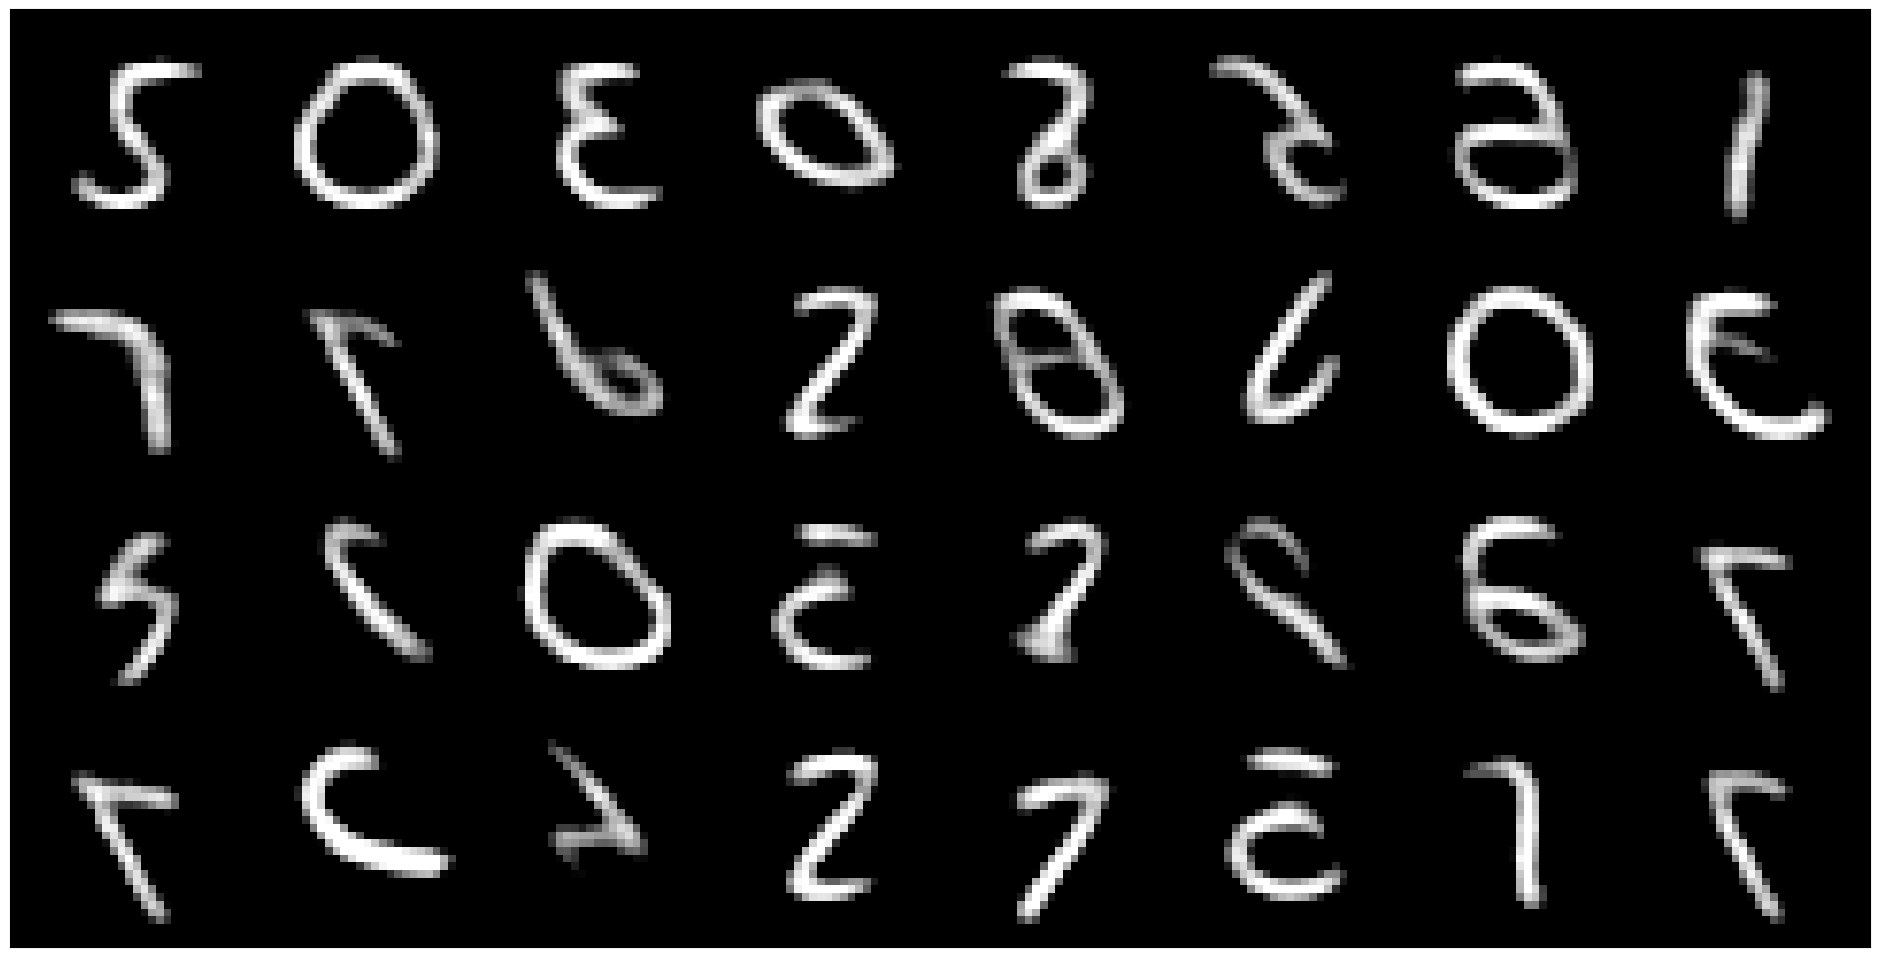

In [26]:
with torch.no_grad():
  pure_noise = torch.rand([64,1,28,28]).to(device)
  student_data = sample(student_model, pure_noise, image_size=image_size, timestep=5,  batch_size=BATCH_SIZE, channels=channels)
  show_batch(student_data[-1].cpu().detach())

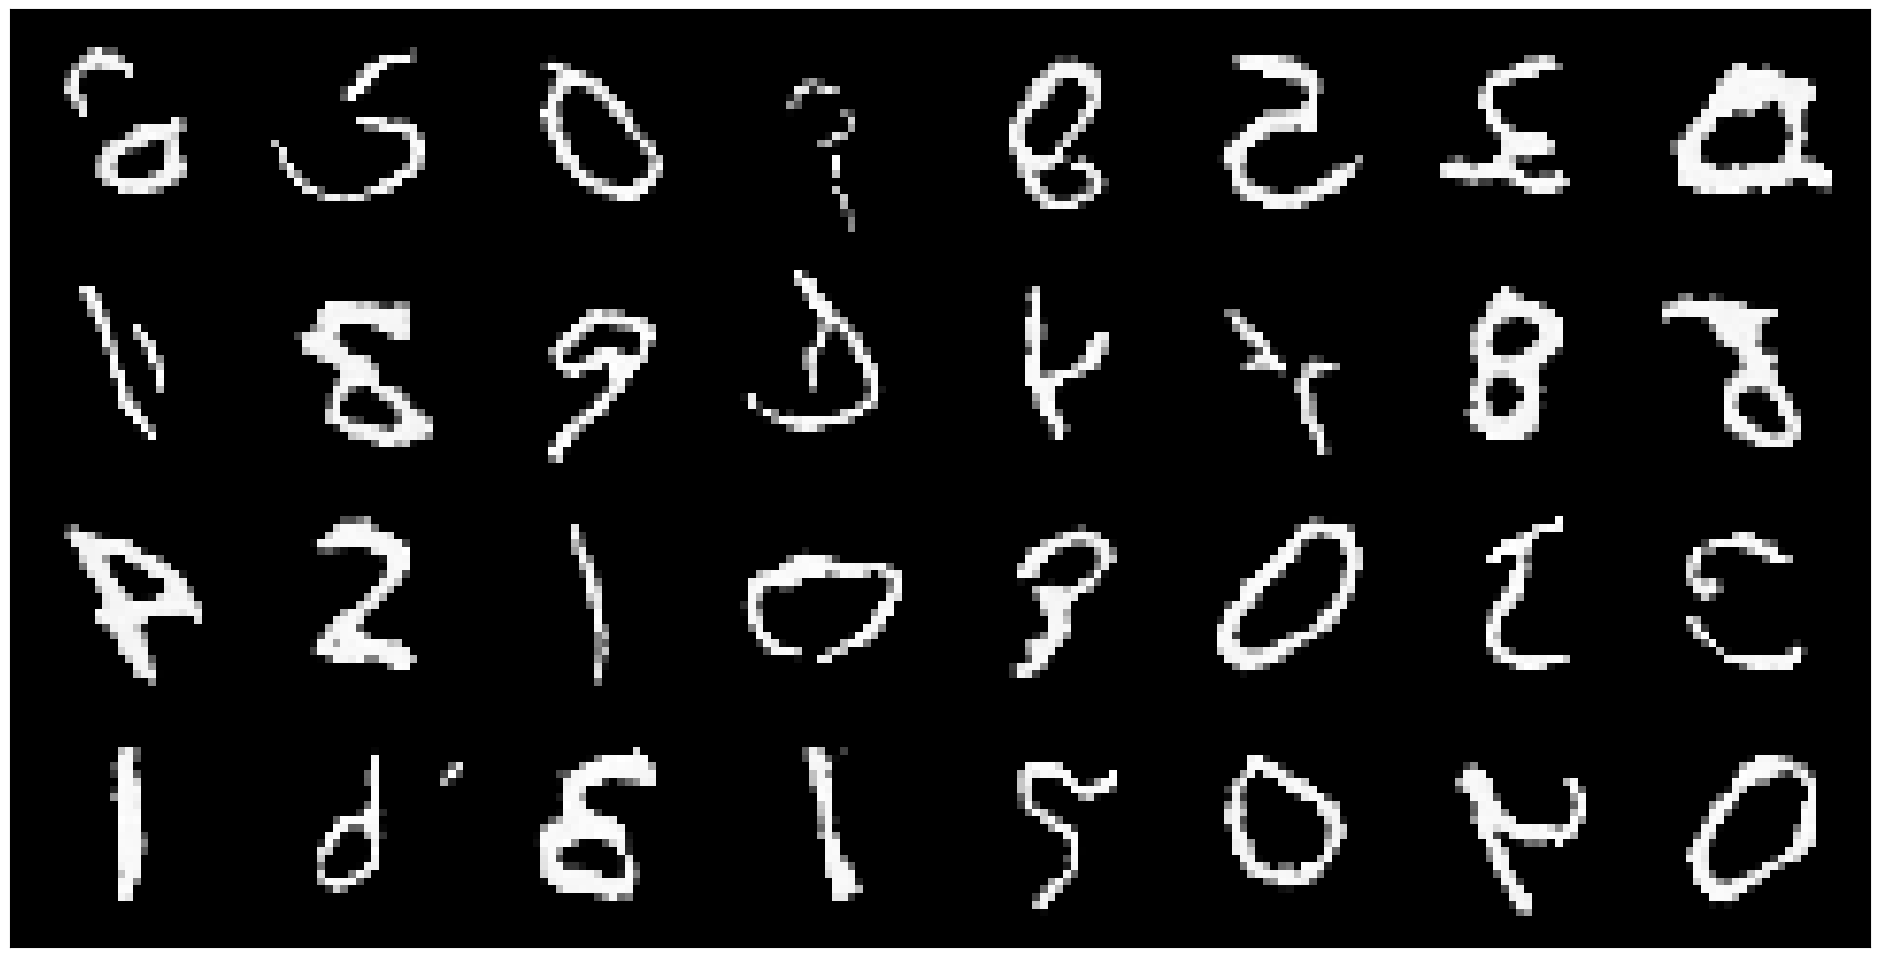

In [ ]:
with torch.no_grad():
  pure_noise = torch.rand([64,1,28,28]).to(device)
  student_data = sample(teacher_model, pure_noise, image_size=image_size, timestep=800,  batch_size=BATCH_SIZE, channels=channels)
  show_batch(student_data[-1].cpu().detach())